# $\chi$EFT EOS results

### Edited by: Alexandra Semposki

### Date: 25 April 2023

Figures in the main text and supplementary material (SM) for (A) _How well do we know the neutron-matter equation of state at the densities inside neutron stars? A Bayesian approach with correlated uncertainties_ by [BUQEYE](https://buqeye.github.io/) members Christian Drischler, Jordan Melendez, Dick Furnstahl, and Daniel Phillips (see [[arXiv:2004.07232]](https://arxiv.org/abs/2004.07232)). Also generated are figures 13 and 14 for (B) _Quantifying uncertainties and correlations in the nuclear-matter equation of state_ by the same authors (see [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805)), which show order-by-order predictions of the pressure and compressibility of symmetric nuclear matter (SNM) for $\Lambda = 500\,$MeV interactions.
The results and figures here can be easily modified and extended.

This notebook uses modules from standard Python packages, third-party packages corner and gptools, and the local nuclear_matter package (install this with the command `pip install -e .` in the root directory of the repository). 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Standard Python modules
import numpy as np
from scipy import stats
from scipy import interpolate
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import matplotlib.patches as mpatches
import pandas as pd
import time

# import source code
import sys
sys.path.append('src/')

from chiral import Chiral

import corner  # https://corner.readthedocs.io/en/latest/

# To use gptools with Python 3, clone from GitHub repository 
#   https://github.com/markchil/gptools (development version)
# and install with 'pip install .' from inside repo. 
import gptools   # https://gptools.readthedocs.io/en/latest/

sys.path.append('nuclear-matter-convergence/')

from nuclear_matter import fermi_momentum, nuclear_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov
from nuclear_matter.graphs import add_top_order_legend, compute_filled_handles, plot_empirical_saturation

## Set up the defaults for figures <a id="figure_defaults"></a>

The appearance of figures can be adjusted by changing `setup_rc_params` in `nuclear_matter` or by overriding those choices here. 

In [2]:
setup_rc_params()

In [3]:
COLOR_68 = 'darkgrey'   # color for 1 sigma bands
COLOR_95 = 'lightgrey'  # color for 2 sigma bands

def curve_plus_bands_plot(ax, x, y, std, color_68=None, color_95=None, 
                          zorder=None, edgecolor=None, **kwargs):
    """
    Plot y vs. x with one sigma and two sigma bands based on std on axis ax.
     Add any other keyword pairs to style the main curve.
    """
#     if color_68 is None:
#         color_68 = COLOR_68
#     if color_95 is None:
#         color_95 = COLOR_95
    ax.plot(x, y, zorder=zorder, **kwargs)
    if color_95 is not None:
        ax.fill_between(x, y + 2*std, y - 2*std, facecolor=color_95, 
                        edgecolor=edgecolor, zorder=zorder)
    if color_68 is not None:
        ax.fill_between(x, y + std, y - std, facecolor=color_68,
                        edgecolor=edgecolor, zorder=zorder, alpha=0.7)
    return ax


## Standard Case <a id="standard_case"></a>

We have data and would like to find a function that best captures the relationship between the inputs and outputs.
A popular nonparametric tool for regression is a Gaussian process (GP).
One of the neat things about a GP is that you automatically get uncertainty quantification along with the line of best fit.
But what is less well known is that it also provides derivatives of the best fit line, and corresponding uncertainty estimates, for free!

The derivative is a linear operator, so the distributions for derivatives follow similarly to how one transforms a Gaussian random variable by scalars or matrices.
Suppose $f$ is distributed as a ($n$-dimensional, for genalizability) Gaussian random variable,
\begin{align}
    f \sim N(0, \Sigma).
\end{align}
Then for some $N\times n$ matrix $C = [1, D]^T$,
\begin{align}
    C f = \begin{bmatrix} 1 \\ D \end{bmatrix} f
    \sim N(0, C \Sigma C^T)
\end{align}
Suppose now that $D = d/dx$ and $f$ is some function of $x$, distributed as a Gaussian process:
\begin{align}
    f(x) \sim GP[0, \kappa(x, x')].
\end{align}
The above logic allows us to find how $f$ correlates with its derivative:
\begin{align}
    \begin{bmatrix} f(x) \\ f'(x) \end{bmatrix}
    & \sim GP[0, K(x, x')] \\
    K(x, x') & =
    \begin{bmatrix}
        K_{00}(x, x') & K_{01}(x, x') \\
        K_{10}(x, x') & K_{11}(x, x')
    \end{bmatrix} =
    \begin{bmatrix}
        \kappa(x, x') & \frac{d}{dx'}\kappa(x, x') \\
        \frac{d}{dx}\kappa(x, x') & \frac{d^2}{dxdx'}\kappa(x, x')
    \end{bmatrix}
\end{align}
It will be useful later to know how to add a function with its derivative, while propagating uncertainties.
For this, we will need
\begin{align}
    Af + Bf' \sim GP[0, AK_{00}A^T + BK_{11}B^T + AK_{01}B^T + BK_{10}A^T]
\end{align}



In [4]:
def draw_func_and_derivative(Xstar, kernel, X=None, y=None, err_y=None, draws=1, extra_kernel=None):
    n = Xstar.shape[0]
    XsXs = np.concatenate((Xstar, Xstar), axis=0)
    derivs = np.concatenate((np.zeros(Xstar.shape), np.ones(Xstar.shape)), axis=0)

    gp = GaussianProcess(k=kernel)
    if X is not None and y is not None:
        gp.add_data(X, y, err_y=err_y)
        gp.optimize_hyperparameters(max_tries=10)
        mean, K = gp.predict(XsXs, n=derivs, return_cov=True)
    else:
        K = gp.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)
        mean = np.zeros(2*n)
        
    if extra_kernel is not None:  # We will use this for the truncation error later
        gp_extra = GaussianProcess(k=extra_kernel)
        K += gp_extra.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)

    # The draw_sample function is much more numerically stable than
    # just using stats.multivariate_normal
    # Since we pass mean and cov, the first arguments aren't used.
    samples = gp.draw_sample(XsXs, derivs, mean=mean, cov=K, num_samp=draws)  # shape = (2n, draws)
    return samples.reshape(2, n, draws)  # separate f and f_prime by first dimension

# Nuclear Matter Application <a id="nuclear_matter"></a>

Our specific use case is similar to the example above: we fit a GP to data, in this case from a physics simulation.
But there is one additional source of uncertainty from the theory error. This will also involve us creating our own custom GP kernel!

## Import the data <a id="import_data"></a>

Choices to make here:
* Select $\Lambda = 450$ or $500\,$MeV interactions with `Lambda`. (See [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805) for details.)
* Select low or high density data by setting `high_density` to `False` or `True`.

The calculated nuclear matter data for input is in the `data` directory in csv files.

In [5]:
#Lambda = 450 #MeV
# Lambda = 500 # MeV

# high_density = True
# if high_density:
#     filename = 'nuclear-matter-convergence/data/all_matter_data_high_density.csv'
# else:
#     filename = 'nuclear-matter-convergence/data/all_matter_data.csv'
    
# data = InputData(filename, Lambda)

# class function
#density_input = np.linspace(0.16, 16.0, 600) 
density_input = np.linspace(0.05,16.0,600)
chiral = Chiral(density_input=density_input, Lambda = 500, high_density=True)

print(chiral.Lambda)
# pull the density to make sure it works
print(chiral.density)
print(chiral.density_all)
print(chiral.density_all[54])

500
[0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18
 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32
 0.33 0.34]
[ 0.05        0.07662771  0.10325543  0.12988314  0.15651085  0.18313856
  0.20976628  0.23639399  0.2630217   0.28964942  0.31627713  0.34290484
  0.36953255  0.39616027  0.42278798  0.44941569  0.47604341  0.50267112
  0.52929883  0.55592654  0.58255426  0.60918197  0.63580968  0.6624374
  0.68906511  0.71569282  0.74232053  0.76894825  0.79557596  0.82220367
  0.84883139  0.8754591   0.90208681  0.92871452  0.95534224  0.98196995
  1.00859766  1.03522538  1.06185309  1.0884808   1.11510851  1.14173623
  1.16836394  1.19499165  1.22161937  1.24824708  1.27487479  1.3015025
  1.32813022  1.35475793  1.38138564  1.40801336  1.43464107  1.46126878
  1.48789649  1.51452421  1.54115192  1.56777963  1.59440735  1.62103506
  1.64766277  1.67429048  1.7009182   1.72754591  1.75417362  1.78080134
  1.80742905  1.83405676  1.86068447  1.8

In [6]:
# orders = np.array([0, 2, 3, 4])
# train = slice(None, None, 5)
# valid = slice(2, None, 5)

# breakdown = 600 # MeV

In [7]:
# kf_n = data.kf_n
# Kf_n = data.Kf_n
# kf_s = data.kf_s
# Kf_s = data.Kf_s
# kf_d = data.kf_avg
# Kf_d = data.Kf_avg

# density = data.density

# ref_2bf = data.ref_2bf
# ref_n_3bf = data.ref_n_3bf
# ref_s_3bf = data.ref_s_3bf
# ref_d_3bf = data.ref_avg_3bf

# y_s_2_plus_3bf = data.y_s_2_plus_3bf
# y_n_2_plus_3bf = data.y_n_2_plus_3bf
# y_d_2_plus_3bf = data.y_d_2_plus_3bf

# y_s_2bf = data.y_s_2bf
# y_n_2bf = data.y_n_2bf
# y_d_2bf = data.y_d_2bf

# y_s_3bf = data.y_s_3bf
# y_n_3bf = data.y_n_3bf
# y_d_3bf = data.y_d_3bf

# fit_n2lo = data.fit_n2lo
# fit_n3lo = data.fit_n3lo

In [8]:
# class variables check
chiral.breakdown

600

Visualize the EOS.

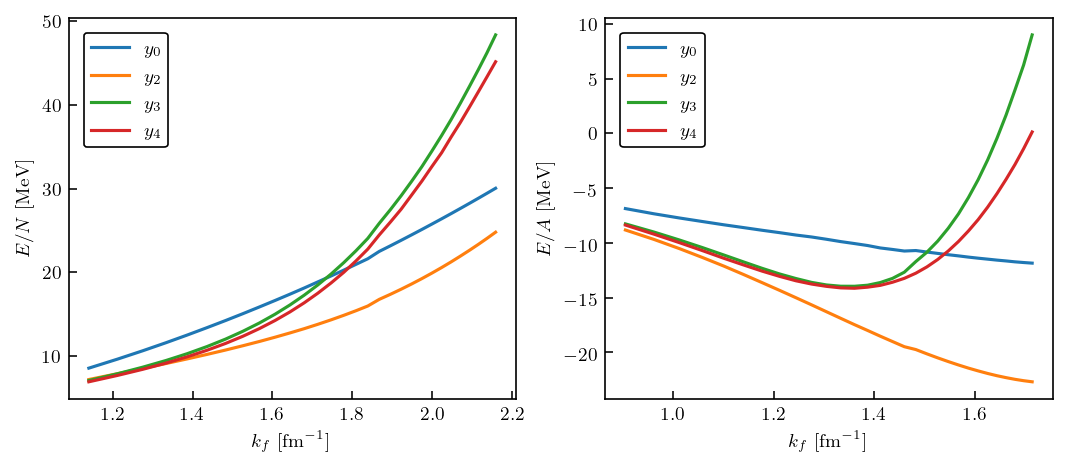

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
# fig.tight_layout(pad=2.5) 

# first neutron matter
for i, n in enumerate(chiral.orders):
    ax[0].plot(chiral.kf_n, chiral.y_n_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[0].legend()
ax[0].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[0].set_ylabel(r'$E/N$ [MeV]');

# then symmetric matter
for i, n in enumerate(chiral.orders):
    ax[1].plot(chiral.kf_s, chiral.y_s_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[1].legend()
ax[1].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[1].set_ylabel(r'$E/A$ [MeV]');

In [10]:
# density_all = np.arange(density[0], density[-1], 0.005)
# N_all = len(density_all)

# #neutron matter
# # kf_n_all = np.linspace(kf_n[0], kf_n[-1], N_all)
# kf_n_all = fermi_momentum(density_all, degeneracy=2)
# Kf_n_all = kf_n_all[:, None]

# #symmetric matter
# # kf_s_all = np.linspace(kf_s[0], kf_s[-1], N_all)
# kf_s_all = fermi_momentum(density_all, degeneracy=4)
# Kf_s_all = kf_s_all[:, None]

# #symmetry energy
# # kf_d_all = np.linspace(kf_d[0], kf_d[-1], N_all)
# kf_d_all = (kf_n_all + kf_s_all) / 2.
# Kf_d_all = kf_d_all[:, None]

In [11]:
density_all = chiral.density_all
print(density_all)

[ 0.05        0.07662771  0.10325543  0.12988314  0.15651085  0.18313856
  0.20976628  0.23639399  0.2630217   0.28964942  0.31627713  0.34290484
  0.36953255  0.39616027  0.42278798  0.44941569  0.47604341  0.50267112
  0.52929883  0.55592654  0.58255426  0.60918197  0.63580968  0.6624374
  0.68906511  0.71569282  0.74232053  0.76894825  0.79557596  0.82220367
  0.84883139  0.8754591   0.90208681  0.92871452  0.95534224  0.98196995
  1.00859766  1.03522538  1.06185309  1.0884808   1.11510851  1.14173623
  1.16836394  1.19499165  1.22161937  1.24824708  1.27487479  1.3015025
  1.32813022  1.35475793  1.38138564  1.40801336  1.43464107  1.46126878
  1.48789649  1.51452421  1.54115192  1.56777963  1.59440735  1.62103506
  1.64766277  1.67429048  1.7009182   1.72754591  1.75417362  1.78080134
  1.80742905  1.83405676  1.86068447  1.88731219  1.9139399   1.94056761
  1.96719533  1.99382304  2.02045075  2.04707846  2.07370618  2.10033389
  2.1269616   2.15358932  2.18021703  2.20684474  2.2

In [12]:
len(density_all) #N_all

600

Begin by interpolating the data points we plotted above. This does not include truncation error yet. Also compute its derivative as before.

In [13]:
from nuclear_matter.derivatives import ObservableContainer, SymmetryEnergyContainer

In [14]:
# min_uncertainty = 0.02  # Twenty keV
# uncertainty_factor = 0.001  # 0.1%
# uncertainty_factor = 0.005  # 0.5%

In [15]:
# err_y_n = np.abs(y_n_2_plus_3bf[:, -1]) * uncertainty_factor
# err_y_n[np.abs(err_y_n) < min_uncertainty] = min_uncertainty
# err_y_n

In [16]:
# err_y_s = np.abs(y_s_2_plus_3bf[:, -1]) * uncertainty_factor
# err_y_s[np.abs(err_y_s) < min_uncertainty] = min_uncertainty
# err_y_s

In [17]:
# err_y_d = np.abs(y_d_2_plus_3bf[:, -1]) * uncertainty_factor
# err_y_d[np.abs(err_y_d) < min_uncertainty] = min_uncertainty
# err_y_d

In [18]:
# err_y_d = np.sqrt(err_y_n**2 + err_y_s**2)

In [19]:
# err_y_d

In [20]:
# kf0_n = fermi_momentum(0.16, 2)
# kf0_s = fermi_momentum(0.16, 4)

# ref_neutron = 16 / kf0_n**2
# ref_nuclear = 16 / kf0_s**2

# if Lambda == 500:
#     std_neutron = 1.00
#     ls_neutron = 0.973
    
#     std_nuclear = 2.95
#     ls_nuclear = 0.484

# elif Lambda == 450:
#     std_neutron = 0.8684060649936118
#     ls_neutron = 0.7631421388401067
#     std_nuclear = 2.6146499024837073
#     ls_nuclear = 0.46603268529311087

# if Lambda == 450:
#     rho = 0.95
#     ls_n_sym = (ls_neutron + ls_nuclear) / 2
#     ls_s_sym = None
# elif Lambda == 500:
#     rho = None
#     ls_n_sym = ls_neutron
#     ls_s_sym = ls_nuclear

In [21]:
##### UP TO HERE everything is the same; this is the only spot where we change things for the inversion
# setup_time_start = time.time()
verbose = True

# print('Setting up neutron matter...', flush=True)
# obs_neutron = ObservableContainer(
#     density=density,
#     kf=kf_n,
#     y=y_n_2_plus_3bf,
#     orders=orders,
#     density_interp=density_all,
#     kf_interp=kf_n_all,
#     std=std_neutron,
#     ls=ls_neutron,
#     ref=ref_neutron,
#     breakdown=breakdown,
#     err_y=err_y_n,
#     include_3bf=False,
#     derivs=[0, 1, 2],
#     verbose=verbose,
# )

# print('Setting up nuclear matter...', flush=True)
# obs_nuclear = ObservableContainer(
#     density=density,
#     kf=kf_s,
#     y=y_s_2_plus_3bf,
#     orders=orders,
#     density_interp=density_all,    
#     kf_interp=kf_s_all,
#     std=std_nuclear,
#     ls=ls_nuclear,
#     ref=ref_nuclear,
#     breakdown=breakdown,
#     err_y=err_y_s,
#     include_3bf=False,
#     derivs=[0, 1, 2],
#     verbose=verbose,
# )

# print('Setting up symmetry energy...', flush=True)
# obs_sym_energy = SymmetryEnergyContainer(
#     density=density,
#     y=y_d_2_plus_3bf,
#     orders=orders,
#     density_interp=density_all,
#     std_n=std_neutron,
#     ls_n=ls_n_sym,
#     std_s=std_nuclear,
#     ls_s=ls_s_sym,
#     ref_n=ref_neutron,
#     ref_s=ref_nuclear,
#     breakdown=breakdown,
#     err_y=err_y_d,
#     include_3bf=False,
#     derivs=[0, 1],
#     verbose=verbose,
#     rho=rho,
# )

# print('Setup time:', time.time() - setup_time_start)

# array size -> (192, 192) -> (64,64) * 3 because of [0,1,2]

# all above using class function
obs_neutron, obs_nuclear, obs_sym_energy = chiral.data_interpolation(density_int=None, kf_s_int=None, extend=True)

Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
0.973 0.484 0.8119689713375328
For EFT order 0, the best polynomial has max nu = 7


/Users/alexandra/Documents/EOSBMM/buqeyenm/../buqeyenm/nuclear-matter-convergence/nuclear_matter/derivatives.py:318: RuntimeWarning: invalid value encountered in sqrt
  d[i] = np.sqrt(np.diag(cov_ij))


For EFT order 2, the best polynomial has max nu = 7
For EFT order 3, the best polynomial has max nu = 7
For EFT order 4, the best polynomial has max nu = 7
Setup time: 87.98048281669617


These are the coefficients $c_\nu$ from fitting the functional
\begin{align}
    \sum_{\nu = 2}^M c_\nu \left(\frac{n}{n_0}\right)^{\nu/3}
\end{align}
to each energy per particle

In [22]:
obs_neutron.compute_functional_coefficients_df()

EFT Order 0   EFT Order 2   EFT Order 3   EFT Order 4
nu                                                        
2     759.229963    699.122741    990.719394    864.545793
3   -4634.367170  -4250.871209  -6114.920712  -5268.733693
4   11942.992922  10946.510640  15827.762238  13464.197598
5  -16214.622767 -14877.315405 -21587.959764 -18069.673224
6   12227.109812  11211.897090  16304.800359  13359.449723
7   -4856.110466  -4437.146011  -6446.166308  -5133.389607
8     793.906921    721.086359   1043.035276    799.969067

In [23]:
obs_nuclear.compute_functional_coefficients_df()

EFT Order 0  EFT Order 2   EFT Order 3  EFT Order 4
nu                                                      
2     980.673156   -98.090599   1421.213530   -21.998838
3   -6257.633109   300.621100  -9241.190893  -134.811873
4   16051.389510  -419.970475  24176.712118   597.871564
5  -21601.111973   256.801796 -33008.155359  -930.534044
6   16152.501174   -56.252969  24834.243219   621.638137
7   -6373.578079          NaN  -9781.346047  -146.263986
8    1037.845376          NaN   1584.516616          NaN

In [24]:
obs_sym_energy.compute_functional_coefficients_df()

EFT Order 0  EFT Order 2  EFT Order 3  EFT Order 4
nu                                                    
2    -49.016361   138.587699   -14.829379   192.670191
3    498.804042  -438.913294   456.070579  -767.819939
4  -1084.767608   777.343423 -1272.501213  1532.661889
5   1094.306775  -738.428830  1515.222074 -1599.454884
6   -532.503006   365.783224  -805.115294   864.365750
7    101.200848   -74.191715   152.410752  -191.954401

Let's see how we did. The light grey error bands represent 2 standard deviations.
The left plot shows the interpolant alone, with error bands that are so small they can't be seen.
The right plot is the same as the left, except truncation bands are added.

In [25]:
def highlight_nsat(ax, nsat=0.164, zorder=0, band=False):
    ax.axvline(nsat, ls="--", lw=0.8, c='0.1', zorder=zorder)
    if band:
        import matplotlib.transforms as transforms
        trans = transforms.blended_transform_factory(
            ax.transData, ax.transAxes)
        n0_std = 0.007
        rect = mpatches.Rectangle(
            (nsat-n0_std, 0), width=2*n0_std, height=1,
            transform=trans, facecolor='0.85', edgecolor='0.6',
            linewidth=0.6,
            alpha=0.7, zorder=zorder-0.01
        )
        ax.add_patch(rect)


density_label = r'Density $n$ [fm$^{-3}$]'
kf_label = r'Fermi momentum $k_{F}$ [fm$^{-1}$]'


def plot_with_and_without_truncation(
    density, y, std, std_with_trunc, density_data=None, y_data=None, add_nsat=True, axes=None, c=None, zorder=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
    ax1, ax2 = axes
    plot_obs_vs_density(
        density=density, y=y, std=std, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax1, c=c, zorder=zorder,
        **kwargs
    )
    plot_obs_vs_density(
        density=density, y=y, std=std_with_trunc, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax2, c=c, zorder=zorder,
        **kwargs
    )
    return axes

def plot_obs_vs_density(
    density, y, std, density_data=None, y_data=None, add_nsat=True, ax=None, c='k',
    color_68=None, color_95=None, markersize=3, edgecolor=None, zorder=0, wrt_kf=False,
    **kwargs
):
    if wrt_kf is True:
        kf = fermi_momentum(density,4)
    if ax is None:
        fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3), dpi=600) 
    curve_plus_bands_plot(
        ax, density, y, std, c=c, color_68=color_68, color_95=color_95,
        edgecolor=edgecolor, zorder=zorder, **kwargs
    )
    ax.set_xlabel(density_label)
    ax.margins(x=0)
    
    if y_data is not None:
        c_marker = c if c is not None else 'k'
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
    if add_nsat:
        highlight_nsat(ax, zorder=zorder)

    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    return ax


def plot_obs_panels(density, y, dy, orders, density_data=None, y_data=None, colors=None, axes=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(2, 2, figsize=(5, 5), dpi=600) 
    fig = plt.gcf()
    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
    
    if colors is None:
        color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
        cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
        colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
    
    light_colors = [lighten_color(color) for color in colors]
    dark_colors = [lighten_color(color, 1.5) for color in colors]

    for j, ax in enumerate(axes.ravel()):
        for i, n in enumerate(orders[:j+1]): 
            if y_data is not None:
                y_data_i = y_data[:, i]
            else:
                y_data_i = None

            plot_obs_vs_density(
                density,
                y[:, i],
                dy[:, i],
                ax=ax,
                c=colors[i],
                color_68=light_colors[i],
                edgecolor=colors[i], 
                add_nsat=i==j, 
                zorder=i/3,
                density_data=density_data,
                y_data=y_data_i,
                markersize=3,
                **kwargs
            )
        ax.axhline(0, 0, 1, c='k', lw=0.8)
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(right=True, top=True, which='both') # stop for loop after line
    add_top_order_legend(fig, axes[0, 0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
    axes[0,0].set_xlabel('')
    axes[0,1].set_xlabel('')
    return fig, axes

In [26]:
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [27]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

In [28]:
from os.path import join

In [29]:
order_labels = ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO']

This is proof that finite differences can perform poorly for second derivatives:

In [30]:
# convert array from density to kf
d = density_all
kf = (3.0 * np.pi**2.0 * d/2.0)**(1.0/3.0)

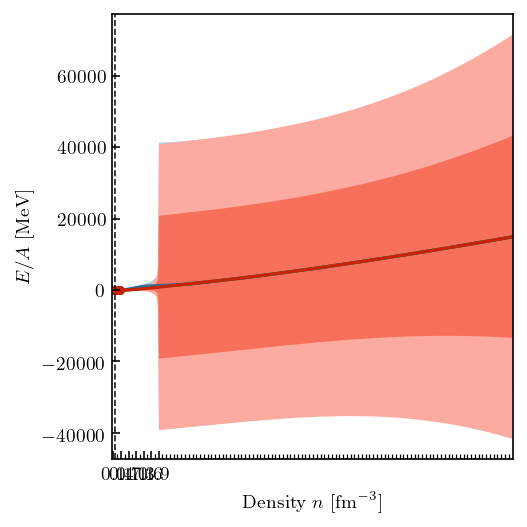

In [31]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True), # just proof of finite difference failing
        wrt_kf=True,
    )
    
ax.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9])#, 2.2, 2.5, 2.8, 3.1])
#ax.set_ylim(-2000, 2000)
ax.set_xlim(0.05,16.0)
#ax.set_xlim(0.05,0.34)
#ax.set_ylim(-1000,1000)
ax.set_ylabel(r'$E/A$ [MeV]');

#print('E/A:', [obs_nuclear.get_pred(order=n, deriv=0) for n in chiral.orders])
# calculate Q wrt kf instead of n 
hbarc = 197.327 
kf_cutoff = 600/hbarc
#print(chiral.obs_nuclear.get_std(order=2,deriv=0,include_trunc=True))
#print(np.shape(chiral.obs_nuclear.get_std(order=2,deriv=0,include_trunc=True)))

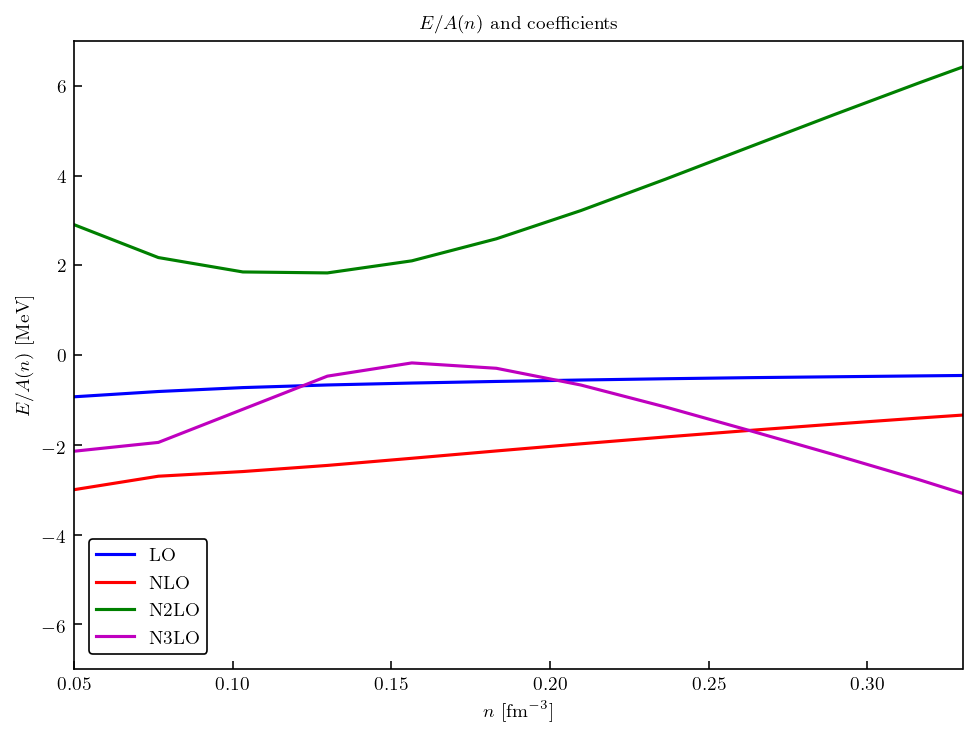

In [32]:
epp = [obs_nuclear.get_pred(order=n, deriv=0) for n in chiral.orders]

hbarc = 197.327 # MeV fm

# we want to see if the coefficients at each order are naturally sized
# check LO from here (easy)
kf_s = hbarc * (3.0 * np.pi**2.0 * chiral.density_all/2.0)**(1.0/3.0)  #[MeV]
kf_0 = hbarc * (3.0 * np.pi**2.0 * 0.16/2.0)**(1.0/3.0)    # [MeV]
yref_n = 16.0 * (kf_s/kf_0)**(2.0)    # [MeV]

# try dividing by yref here (simple test for mean results)
LO_coeff = epp[0]/yref_n

# Q
exp_Q = (kf_s/chiral.breakdown)   # [dimensionless]

# second one (now mindful of Q)
NLO_coeff = ((epp[1]/yref_n) - LO_coeff)/(exp_Q)**2.0

# third one (N2LO)
N2LO_coeff = ((epp[2]/yref_n) - NLO_coeff*(exp_Q)**2.0 - LO_coeff)/(exp_Q)**3.0

# fourth one (N3LO)
N3LO_coeff = ((epp[3]/yref_n) - N2LO_coeff*(exp_Q)**3.0 - NLO_coeff*(exp_Q)**2.0 - LO_coeff)/(exp_Q)**4.0

plt.xlim(0.05, 0.33)
plt.ylim(-7,7)
plt.xlabel(r'$n$ [fm$^{-3}$]')
plt.ylabel(r'$E/A(n)$ [MeV]')
plt.title(r'$E/A(n)$ and coefficients')
#plt.plot(chiral.density_all, epp[0], 'b.')
plt.plot(chiral.density_all, LO_coeff, 'b', label='LO')
#plt.plot(chiral.density_all, epp[1], 'r.')
plt.plot(chiral.density_all, NLO_coeff, 'r', label='NLO')
#plt.plot(chiral.density_all, epp[2], 'g.')
plt.plot(chiral.density_all, N2LO_coeff, 'g', label='N2LO')
#plt.plot(chiral.density_all, epp[3], 'm.')
plt.plot(chiral.density_all, N3LO_coeff, 'm', label='N3LO')
plt.legend(loc='lower left')
plt.show()

Now that we have a handle on the EFT itself, we will move to the truncation errors. For each order, they should be on the order of the next power. 

Using only truncation error:


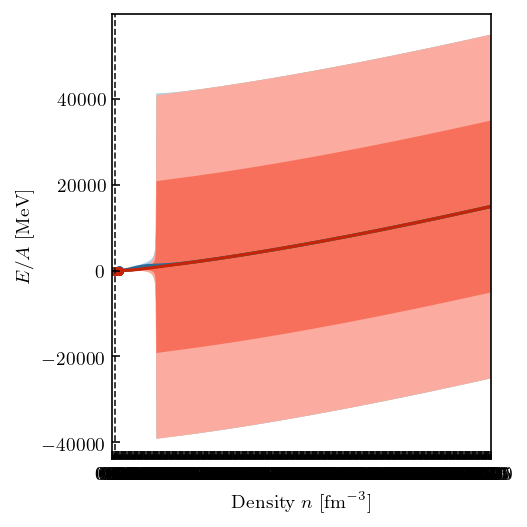

Using only interpolation error:


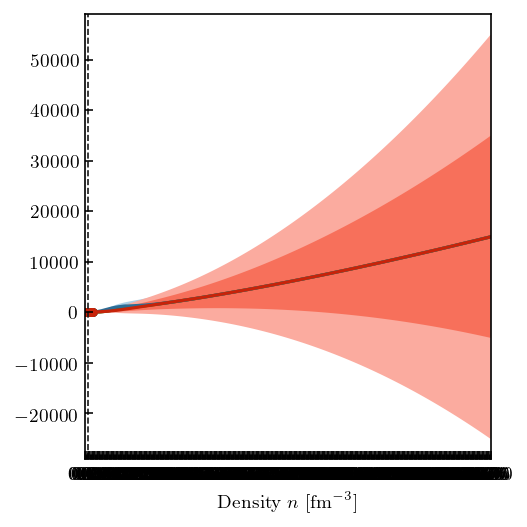

Using both truncation and interpolation error:


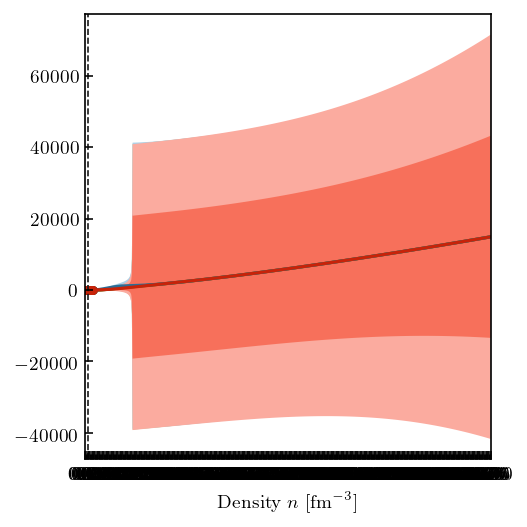

In [33]:
# look at the truncation error bands now at each order and test their scaling
trunc_std = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
for i, n in enumerate(chiral.orders):
    trunc_std[i] = obs_nuclear.get_trunc_std(order=n, deriv=0)

# now take this and plot it 
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))

#ax.set_ylim(-50, 50)
#ax.set_ylim(-1000, 1000)
print('Using only truncation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_trunc_std(order=n, deriv=0),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        #zorder=i/10,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
#ax.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1]);
ax.set_ylabel(r'$E/A$ [MeV]');
plt.show()

# now only plot the interpolation GP errors
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
# ax.set_ylim(-50,50)
# ax.set_ylim(-1000, 1000)
print('Using only interpolation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=False),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        #zorder=i/10,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
#ax.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1]);
plt.show()

# now plot both
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
#ax.set_ylim(-50,50)
#ax.set_ylim(-1000, 1000)
print('Using both truncation and interpolation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        #zorder=i/10,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
#ax.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1]);
plt.show()

In [34]:
#print the covariance matrices for deriv=0 out here (start with LO, where the deviation is largest)
# print('Cov_total_all_derivs[3]')
# print(chiral.obs_nuclear._cov_total_all_derivs[3])
# print(np.shape(chiral.obs_nuclear._cov_total_all_derivs[3]))
# print()
# print()
#print(chiral.obs_nuclear.cov_trunc_all_derivs_n[:59,:59])
# print()
# print()
#print(chiral.obs_nuclear.cov_total_all_derivs_n[:59,:59])

# now look at it after extract_blocks is run and cov_blocks_map
#print(chiral.obs_nuclear._cov_total_blocks[3])   # --> this is where we could REALLY truncate stuff!

# now look at the get_std_map results
#print(chiral.obs_nuclear._std_total_vecs[3])

Text(0, 0.5, 'E/A [MeV]')

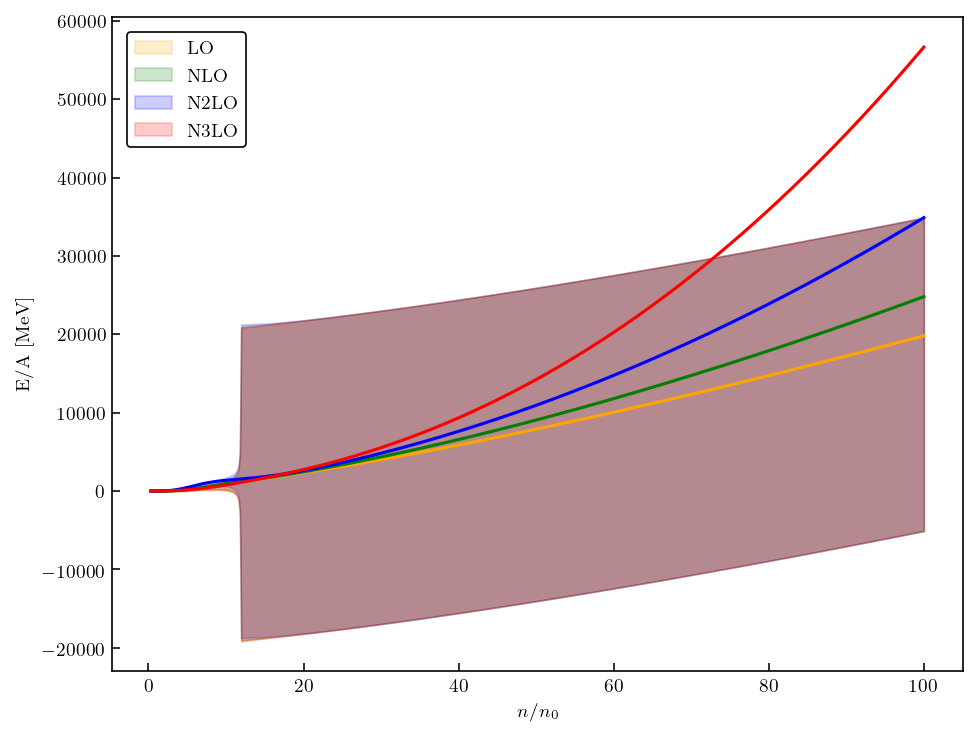

In [35]:
# now we want to look at the powers with which these functions' errors increase, so we look
# at the truncation error band and how it grows with density
# add the truncation error band to the mean
high_edge = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
low_edge = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
trunc_values = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
# analyse dict for std_trunc_vecs (1 does not exist)
for i,n in enumerate(chiral.orders):
    trunc_values[i] = obs_nuclear.get_trunc_std(order=n, deriv=0)
    
# plot these without the mean to see what happens
# plt.plot(density_all, trunc_values[3], 'm')
# plt.plot(density_all, 0.9*(chiral.density_all/0.16)**(7.0/3.0), 'k')
# plt.show()
    
# now we add this to the current means
for i,n in enumerate(chiral.orders):
    high_edge[i] = 1.0 * trunc_values[i] + epp[i]
    low_edge[i] = -1.0 * trunc_values[i] + epp[i]

# plot this
# plt.plot(density_all, high_edge[0], color='orange',  linewidth=0, marker='.', label='LO')
# plt.plot(density_all, low_edge[0], color='orange', linewidth=0, marker='.')
plt.fill_between(density_all/0.16, low_edge[0], high_edge[0], color='orange', alpha=0.2, edgecolor=None, label='LO')
#plt.plot(density_all, epp[0], 'b.')
# plt.plot(density_all, high_edge[1], 'g.', label='NLO')
# plt.plot(density_all, low_edge[1], 'g.')
plt.fill_between(density_all/0.16, low_edge[1], high_edge[1], color='g', alpha=0.2, edgecolor=None, label='NLO')
#plt.plot(density_all, epp[1], 'r.')
# plt.plot(density_all, high_edge[2], 'b.', label='N2LO')
# plt.plot(density_all, low_edge[2], 'b.')
plt.fill_between(density_all/0.16, low_edge[2], high_edge[2], color='b', alpha=0.2, edgecolor=None, label='N2LO')
#plt.plot(density_all, epp[2], 'g.')
# plt.plot(density_all, high_edge[3], 'r.', label='N3LO')
# plt.plot(density_all, low_edge[3], 'r.')
plt.fill_between(density_all/0.16, low_edge[3], high_edge[3], color='r', alpha=0.2, edgecolor=None, label='N3LO')
#plt.plot(density_all, epp[3], 'm.')
plt.legend(loc='upper left')

# just the density dependence now
dens_LO = (chiral.density_all/0.16)**(4.0/3.0)
dens_NLO = (chiral.density_all/0.16)**(5.0/3.0)
dens_N2LO = (chiral.density_all/0.16)**(6.0/3.0)
dens_N3LO = (chiral.density_all/0.16)**(7.0/3.0)

# matching density dependence 
func_form_LO = 10.6 * (chiral.density_all/0.16)**(4.0/3.0) + epp[0] 
func_form_NLO = 4.6 * (chiral.density_all/0.16)**(5.0/3.0) + epp[1]
func_form_N2LO = 2.0 * (chiral.density_all/0.16)**(6.0/3.0) + epp[2]
func_form_N3LO = 0.9 * (chiral.density_all/0.16)**(7.0/3.0) + epp[3]

# add the bands in quadrature to see what happens (N3LO case only)
interp_only = obs_nuclear.get_std(order=4, deriv=0, include_trunc=False)
trunc_interp = obs_nuclear.get_std(order=4, deriv=0, include_trunc=True)
quad_error = np.sqrt(np.square(interp_only) + np.square(0.9 * dens_N3LO))

# now map the density**5/3 and see if it overlays well
# plt.xlim(0.05/0.16, 0.33/0.16)
# plt.ylim(-20,20)
plt.plot(density_all/0.16, func_form_LO, 'orange')
plt.plot(density_all/0.16, func_form_NLO, 'g')
plt.plot(density_all/0.16, func_form_N2LO, 'b')
plt.plot(density_all/0.16, func_form_N3LO, 'r')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel('E/A [MeV]')

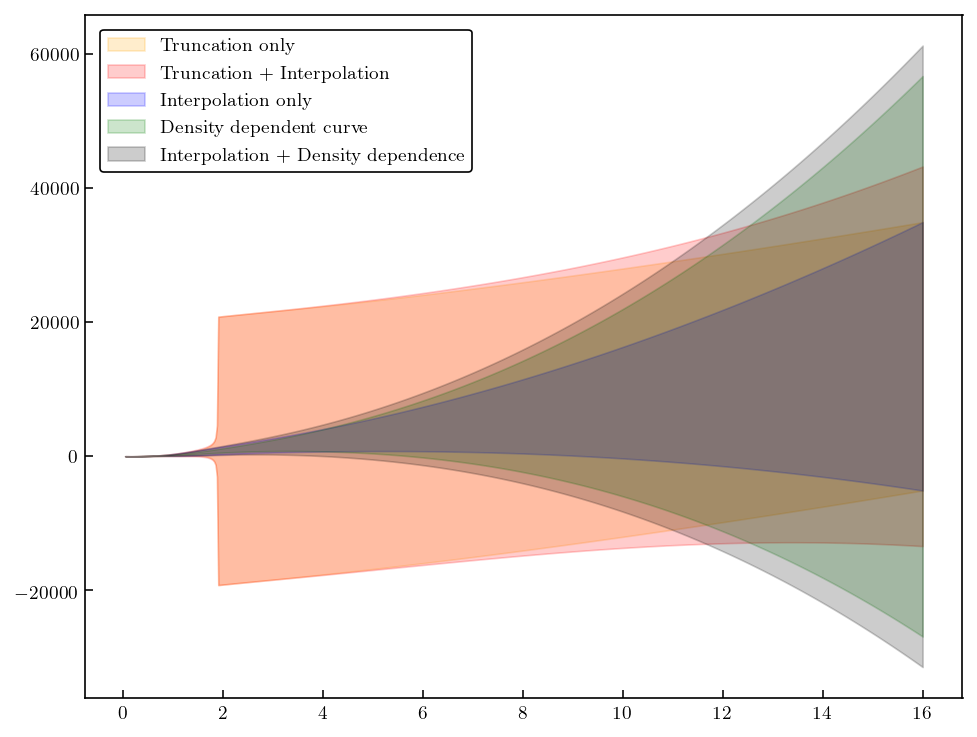

In [36]:
# overlay truncation + interp and only interp to see differences farther out
plt.fill_between(density_all, epp[3] - chiral.obs_nuclear.get_trunc_std(order=4, deriv=0), epp[3] + chiral.obs_nuclear.get_trunc_std(order=4, deriv=0), \
                 color='orange', alpha=0.2, label='Truncation only')
plt.fill_between(density_all, epp[3] - chiral.obs_nuclear.get_std(order=4, deriv=0, include_trunc=True), \
                 epp[3] + chiral.obs_nuclear.get_std(order=4, deriv=0, include_trunc=True), color='r', alpha=0.2, \
                label='Truncation + Interpolation')
plt.fill_between(density_all, epp[3] - chiral.obs_nuclear.get_std(order=4, deriv=0, include_trunc=False), \
                 epp[3] + chiral.obs_nuclear.get_std(order=4, deriv=0, include_trunc=False), color='b', alpha=0.2, \
                label='Interpolation only')
plt.fill_between(density_all, epp[3] - 0.9 * dens_N3LO, epp[3] + 0.9 * dens_N3LO, color='g', alpha=0.2, \
                 label='Density dependent curve')
plt.fill_between(density_all, epp[3] - quad_error, epp[3] + quad_error, color='k', alpha=0.2, \
                 label='Interpolation + Density dependence')
plt.legend(loc='upper left')

#plt.ylim(-20,20)
#plt.xlim(0.0, 0.5)

# plot the Q = 0.5 line
dens_Q_12 =(0.5 * chiral.breakdown)**(3.0) * 2.0/(3.0*np.pi**2)/hbarc**3.0
#plt.axvline(x=dens_Q_12, color = 'k', linestyle = 'dotted')

__Interesting to note above that the density dependence does take over farther out and beats our current cutoff. Would it be more realistic to take a piecewise polytrope kind of approach and use the density dependence when it takes over?__

Create a Gaussian random variable based on the posterior for the saturation density found for our Hamiltonians.
Sample saturation densities from it.

In [37]:
sat_density_ham_dist = stats.norm(0.17, 0.01)
sat_density_ham_dist_n2lo = stats.norm(0.17, 0.02)
num_sats = 101

np.random.seed(1)
d_sats = sat_density_ham_dist.rvs(num_sats)
d_sats_n2lo = sat_density_ham_dist_n2lo.rvs(num_sats)
D_sats = d_sats[:, None]

kf_n_sats = fermi_momentum(d_sats, 2)
Kf_n_sats = kf_n_sats[:, None]

kf_s_sats = fermi_momentum(d_sats, 4)
Kf_s_sats = kf_s_sats[:, None]

These will be used later on to get posteriors with full uncertainties for the incompressibility $K$, and $S_v$--$L$ correlations

## Make Order-by-Order Predictions with Uncertainties <a id="order_by_order"></a>

Our GPs are defined to be stationary over momentum, but most formula for EOS properties use derivatives with respect to density.
So our derivatives must make use of the chain rule.
This is all handled inside functions like `compute_pressure`, `compute_pressure_cov`, etc., which can all be told whether the inputs use `kf` or `n` as the space for derivatives.

In [38]:
from nuclear_matter import kf_derivative_wrt_density

The pressure is given by
$$ 
P = n^2 \frac{d}{dn} \frac{E}{A} = n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = n \frac{k_f}{3} \frac{d}{dk_f}  \frac{E}{A}
$$
where $k_f = \sqrt[3]{3\pi^2\, n/2}$ ($k_f = \sqrt[3]{3\pi^2\, n}$) for symmetric (neutron) matter.

It is useful to note that
\begin{align}
    \frac{dk}{dn} & = \frac{k}{3n} \\
    \frac{d^2k}{dn^2} & = -\frac{2k}{9n^2}
\end{align}

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


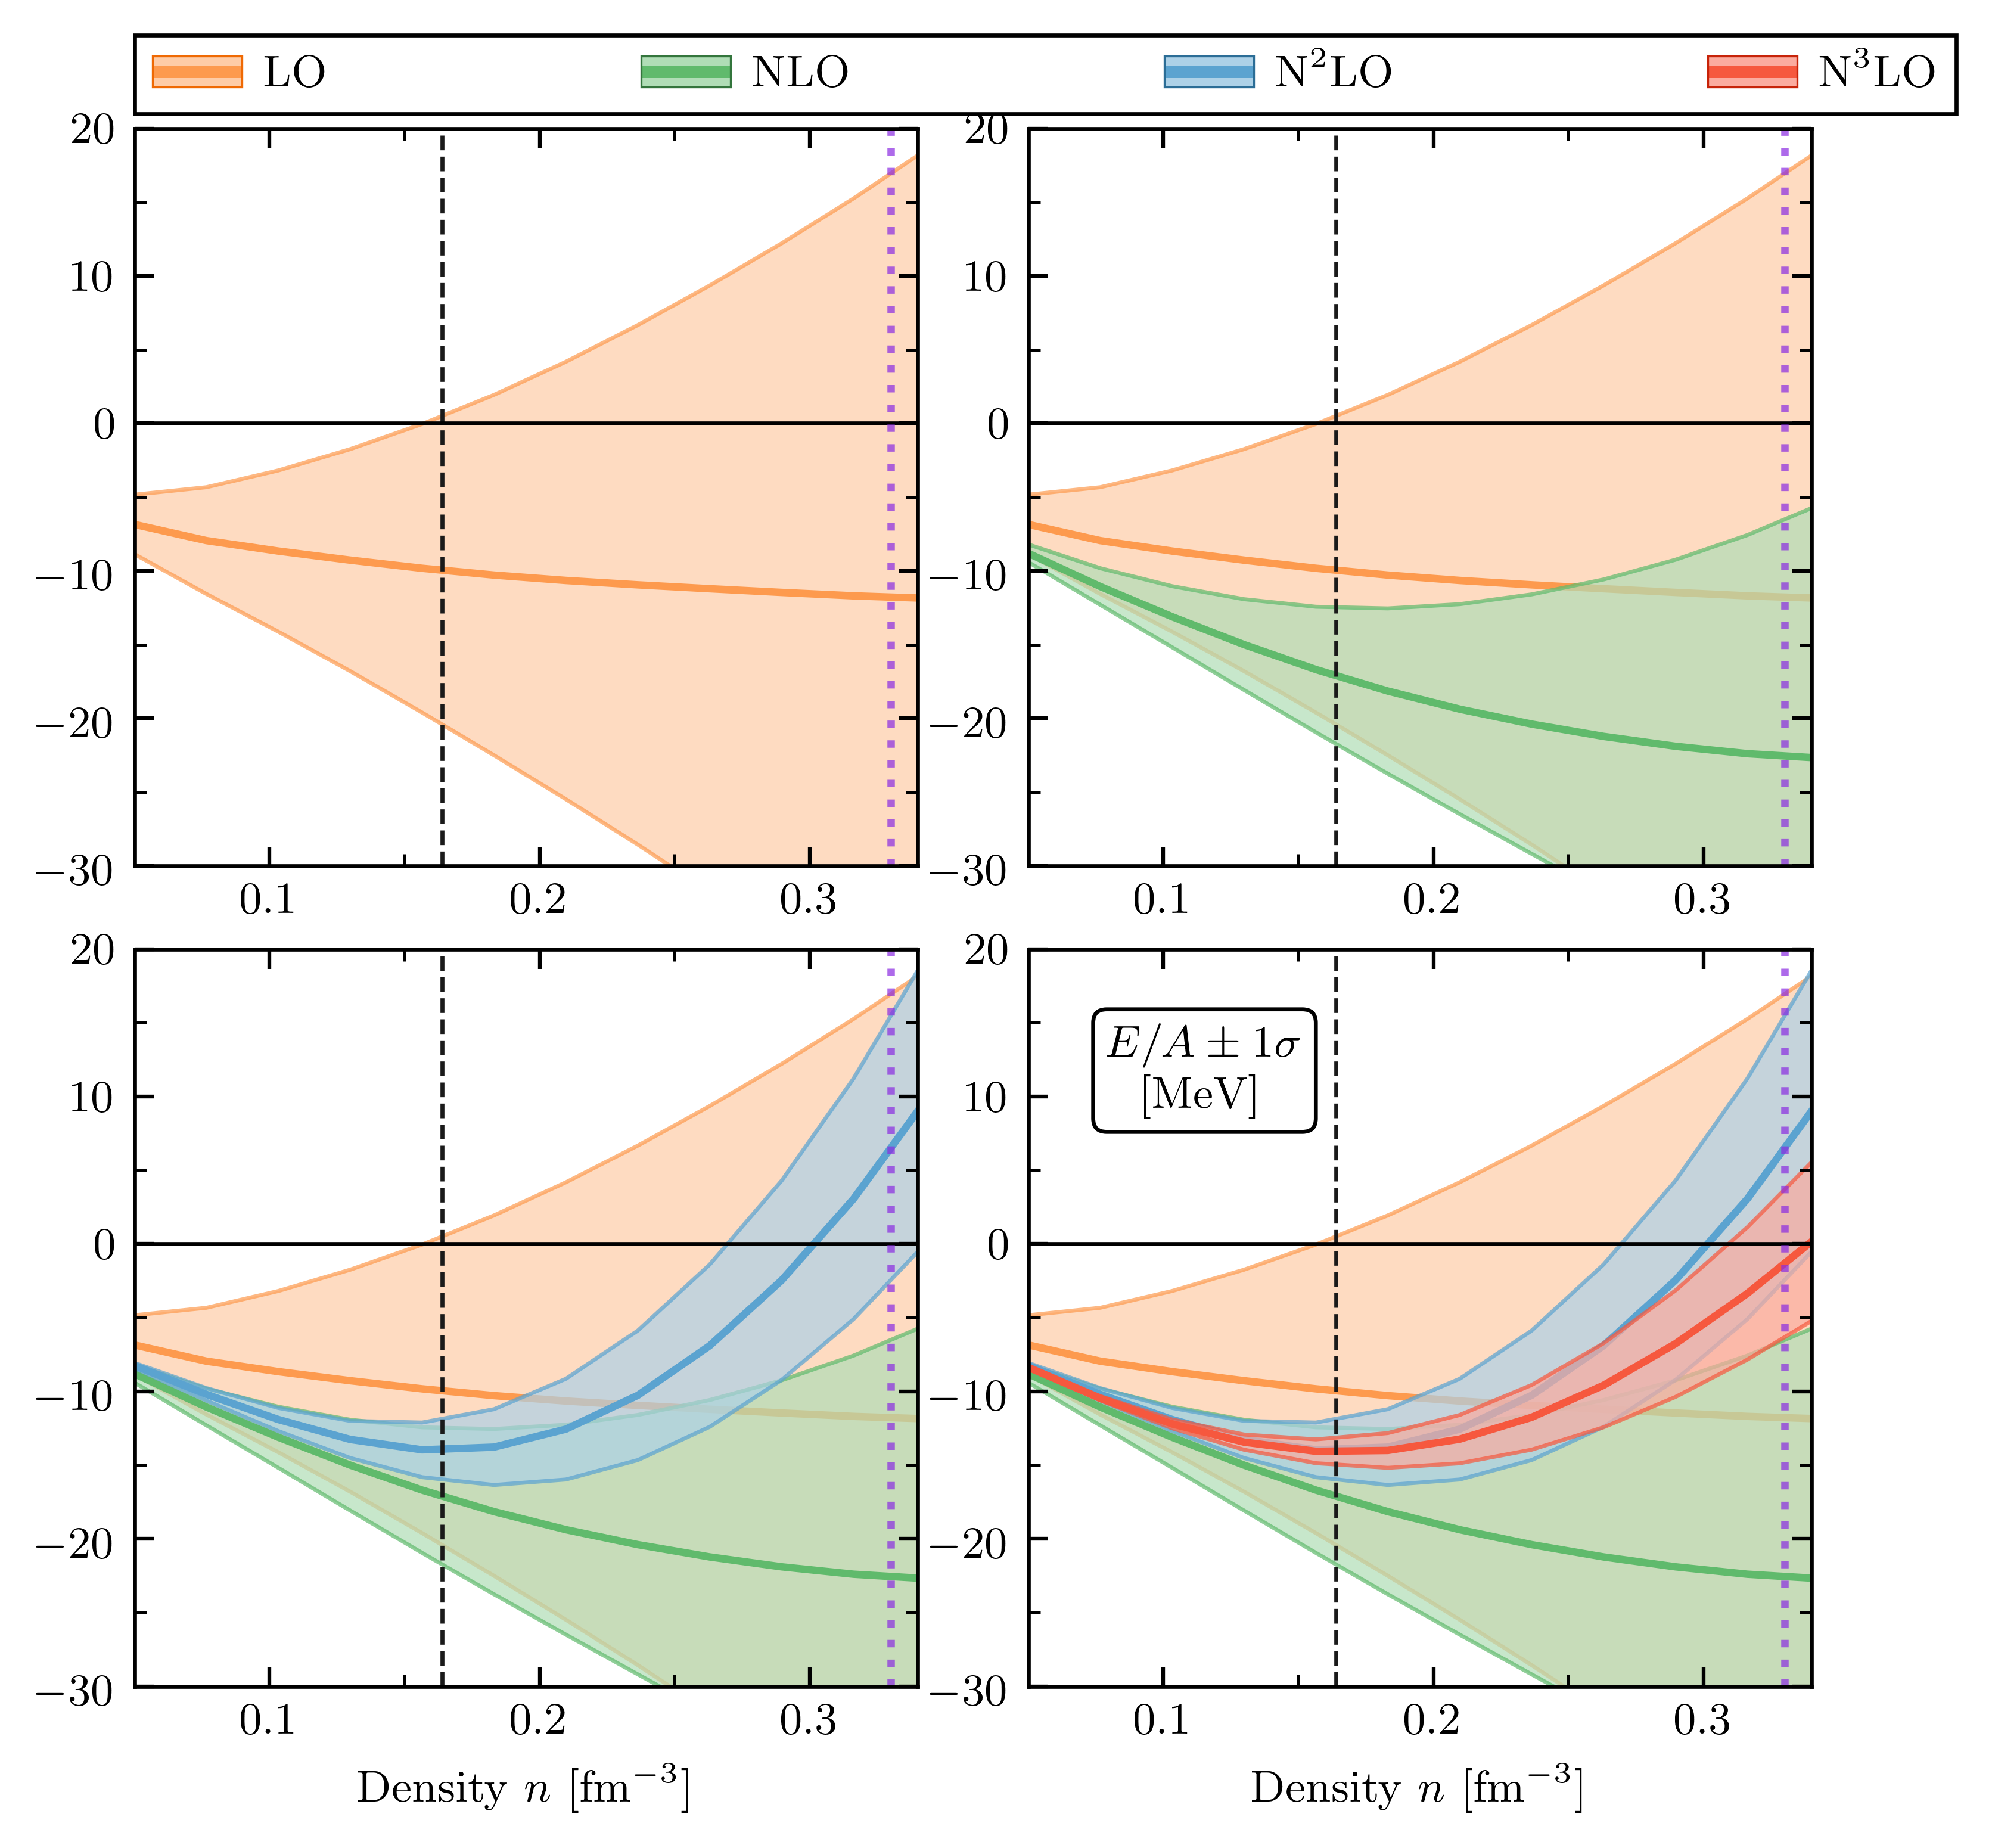

-14.065863097271347


In [39]:
# energies_s = np.array([obs_nuclear.get_pred(order=n, deriv=0) for n in orders]).T
# energy_s_stds = np.array([obs_nuclear.get_std(order=n, deriv=0, include_trunc=True) for n in orders]).T

# # adding the rest mass in (average p,n)
# rest_mass = 938.91875434       # MeV

# # multiply all quantities in E/A arrays at all orders
# energies_s_mn = energies_s + rest_mass

energies_s_mn, energy_s_stds = chiral.energy_per_particle(add_rest_mass=False)

fig, axes = plot_obs_panels(
    density_all, y=energies_s_mn, dy=energy_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

# axes[0, 0].set_ylim(915, 950-1e-5)
# axes[1, 0].set_ylim(915, 950-1e-5)
# axes[0, 0].set_ylim(-1000, 3000-1e-5)
# axes[1, 0].set_ylim(-1000, 3000-1e-5)
axes[0, 0].set_ylim(-30, 20)
axes[1, 0].set_ylim(-30, 20)
axes[1, 1].set_ylim(-30, 20)
axes[0, 1].set_ylim(-30, 20)
for ax in axes.reshape(-1):
    ax.set_xlim(0.05, 0.34)
    #ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

label = r"""$E/A \pm 1\sigma$
[MeV]""" # axes[0,0]
ax.text( 
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()
print(min(energies_s_mn[:,3]))

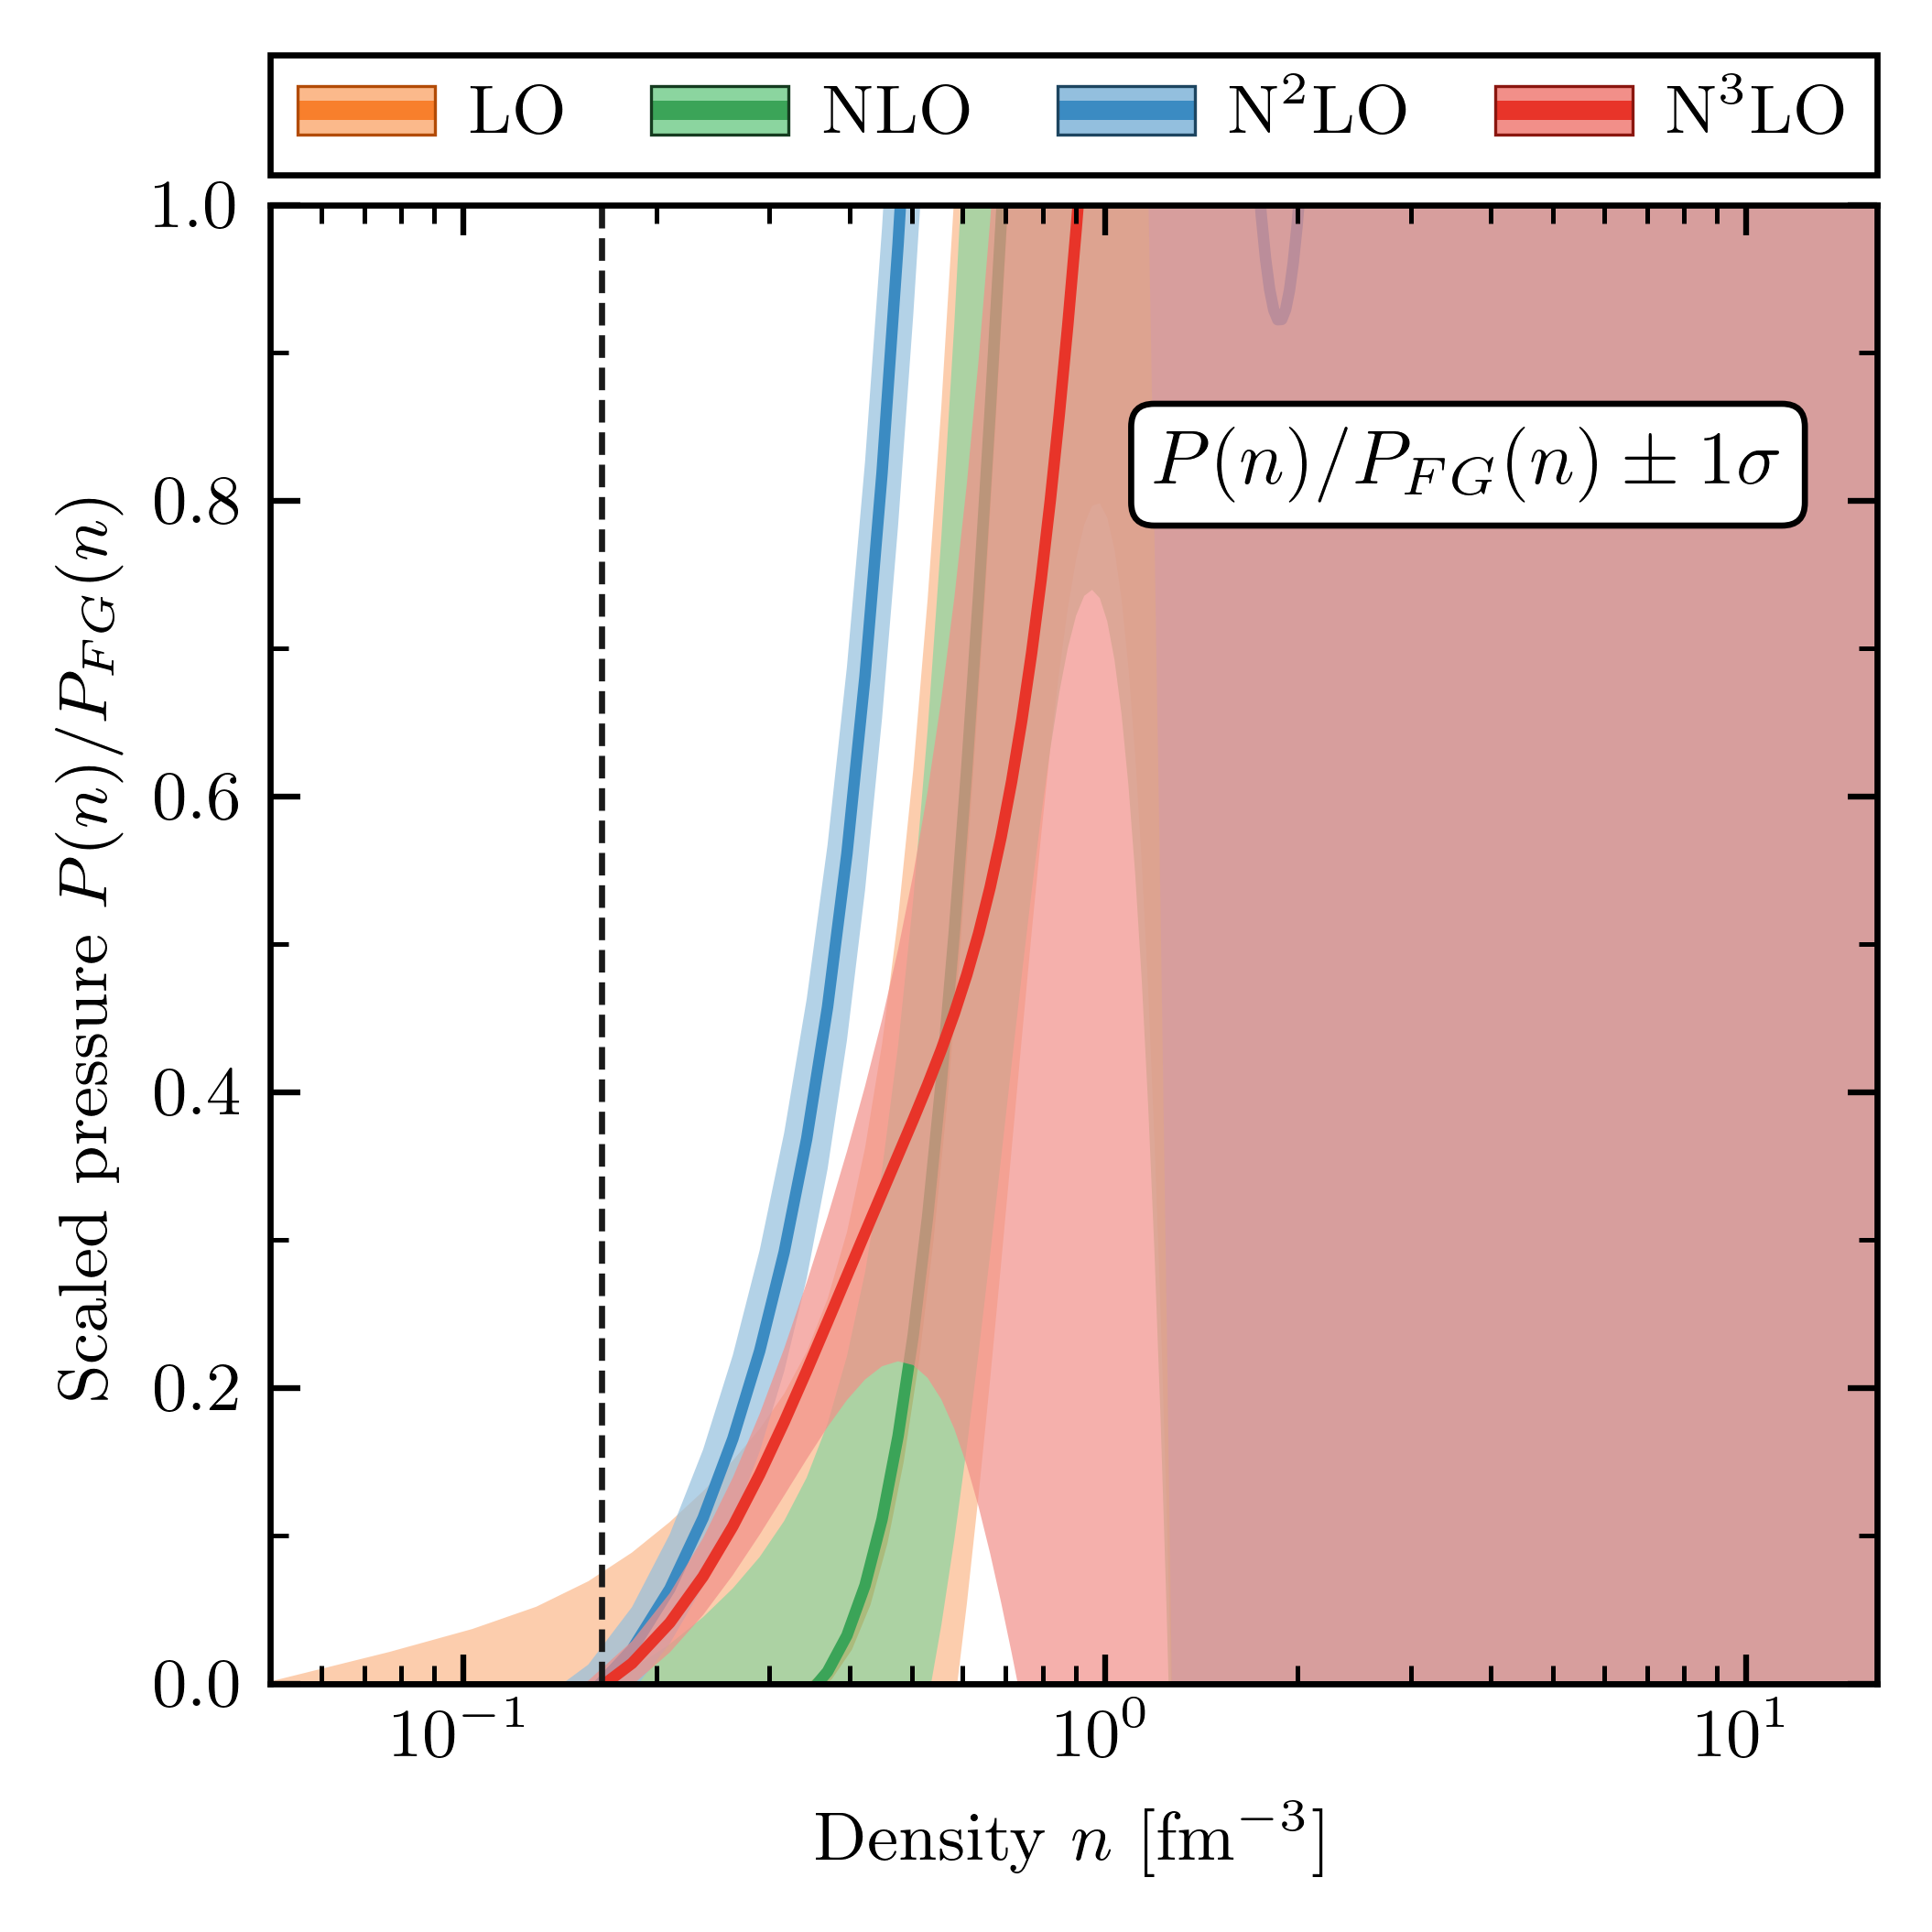

In [40]:
# (B) figure 13 and SM 8
# pressures_s = []
# pressure_s_stds = []
# pressure_s_fits = []
# for i, n in enumerate(orders):
#     pressure_s = compute_pressure(
#         obs_nuclear.density_interp,
#         obs_nuclear.kf_interp,
#         dE=obs_nuclear.get_pred(order=n, deriv=1)
#     )
#     pressure_s_cov = compute_pressure_cov(
#         obs_nuclear.density_interp,
#         obs_nuclear.kf_interp,
#         dE_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1)
#     )
#     pressure_s_std = np.sqrt(np.diag(pressure_s_cov))

#     pressure_alt_diff_s = compute_pressure(
#         obs_nuclear.density,
#         obs_nuclear.kf,
#         dE=obs_nuclear.poly_interp(order=n, deriv=1, wrt_kf=False),
#         wrt_kf=False
#     )
#     pressures_s.append(pressure_s)
#     pressure_s_stds.append(pressure_s_std)
#     pressure_s_fits.append(pressure_alt_diff_s)

# pressures_s = np.array(pressures_s).T
# pressure_s_stds = np.array(pressure_s_stds).T
# pressure_s_fits = np.array(pressure_s_fits).T

# call the chiral pressure function 
pressures_s, pressure_s_stds, pressure_s_cov = chiral.pressure(orders='all')

# fill std with zeros for initial plot
pressure_s_stds_0 = np.zeros([len(density_all), len(chiral.orders)])

# fig, axes = plot_obs_panels(
#     density_all, y=pressures_s, dy=pressure_s_stds, orders=chiral.orders,
# #     density_data=density[::3], y_data=pressure_s_fits[::3],
#     colors=colors, fillstyle='none', markeredgewidth=0.5,
# )

# axes[0, 0].set_ylim(-10, 25-1e-5)
# axes[1, 0].set_ylim(-10, 25-1e-5)
# axes[1, 1].set_ylim(-10, 25-1e-5)
# axes[0, 1].set_ylim(-10, 25-1e-5)

# for the old range of truncation error
# fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
# from nuclear_matter import lighten_color
# color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
# cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
# colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
# light_colors = [lighten_color(color, 0.55) for color in colors]
# dark_colors = [lighten_color(color, 1.5) for color in colors]
# for i, n in enumerate(chiral.orders):
#     plot_obs_vs_density(
#         density_all,
#         pressures_s[:,i],
#         pressure_s_stds[:,i],
#         ax=ax,
#         color_68=light_colors[i],
#    #     color_95=light_colors[i],
#         c=colors[i],
#         add_nsat=i==len(chiral.orders)-1,
#         zorder=i/10,
#     )
# ax.xaxis.set_major_locator(MultipleLocator(0.05))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.tick_params(right=True, top=True, which='both') # stop for loop after line
# ax.axhline(0, 0, 1, c='k', lw=0.8);
# ax.set_ylabel(r'$\textrm{Pressure}~P(n)$ [MeV/fm$^{3}$]');
# ax.set_ylim(-10, 25-1e-5);
# label = r"""$P \pm 1\sigma$
# [MeV\,fm$^{-3}$]"""
# ax.text(
#     0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
#     multialignment='center', zorder=10, fontsize=10,
#     bbox=dict(facecolor='w', boxstyle='round')
# )
# add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
# #fig.savefig('pressure_n_2n0.pdf')
# plt.show()

pressure_free = np.zeros([len(density_all), 4])
hbarc = 197.327 # MeV fm

for i in range(4):
    pressure_free[:,i] = ((1.0/(2.0*np.square(np.pi)))*(chiral.kf_s_all**4.0))*(hbarc)

# for the newer, more expanded code
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        pressures_s[:,i]/pressure_free[:,i],
        pressure_s_stds[:,i]/pressure_free[:,i],
        ax=ax,
        color_68=light_colors[i],
   #     color_95=light_colors[i],
        c=colors[i],
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
    )
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both') # stop for loop after line
ax.axhline(0, 0, 1, c='k', lw=0.8);
#ax.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1]);
ax.set_xlim(0.05, 16.0)
ax.set_xscale('log')
ax.set_ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$');
#ax.set_ylim(-10, 25-1e-5);  # old one
ax.set_ylim(0.0, 1.0)
label = r"""$P(n)/P_{FG}(n) \pm 1\sigma$"""
ax.text(
    0.55, 0.85, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
#fig.savefig('pressure_scaled_trunc.pdf')
plt.show()

In [41]:
# # saving the mean, std_dev, and cov for E/A
n0 = 0.16 
# # mean_chiral_EA = obs_nuclear.get_pred(order=4, deriv=0)
# # std_dev_chiral_EA = obs_nuclear.get_std(order=4, deriv=0, include_trunc=True)
# # cov_matrix_chiral_EA = obs_nuclear.get_cov(order=4, deriv1=0, include_trunc=True)

# # saving the mean, std_dev, and cov for E/A
# # call pressure from chiral.py
pressure_s, pressure_s_stds, pressure_s_cov = chiral.pressure(orders='all')
mean_chiral_pressure = pressure_s
std_dev_chiral_pressure = pressure_s_stds
cov_matrix_chiral_pressure = pressure_s_cov

# write this to a file
if density_all.size >= 600:
    np.savez('pressure_chiral_data', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure, std_dev=std_dev_chiral_pressure, \
             cov=cov_matrix_chiral_pressure)

    # open the file here and check it
    npzfile = np.load('pressure_chiral_data.npz')
    npzfile.files

    print(npzfile['mean'].shape, npzfile['std_dev'].shape, npzfile['cov'].shape)

    std_from_cov = np.sqrt(np.diag(npzfile['cov'][:,:,3]))
    print(std_from_cov - npzfile['std_dev'][:,3])
else:
    print('Not saved.')

(600, 4) (600, 4) (600, 600, 4)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 

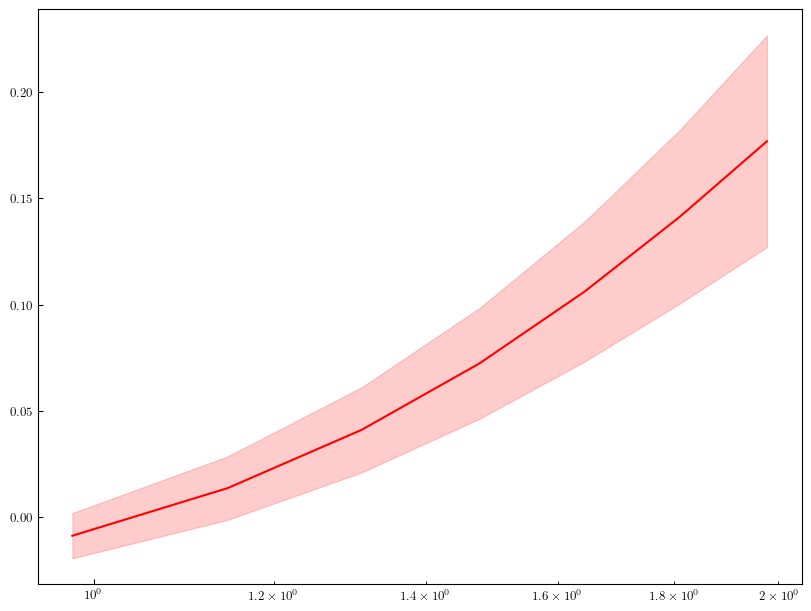

In [42]:
# divide out by the free quark pressure (checking against the plot in chiral EFT in the SNM paper)
pressure_free = np.zeros([len(density_all), 4])
hbarc = 197.327 # MeV fm

for i in range(4):
    pressure_free[:,i] = ((1.0/(2.0*np.square(np.pi)))*(chiral.kf_s_all**4.0))*(hbarc)
        
n0 = 0.16
dens_scale = density_all/n0
min_dens = np.where(dens_scale>=1.)[0][0]
max_dens = np.where(dens_scale>=2.)[0][0]
dens_scale = dens_scale[min_dens-1:max_dens]

fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.plot(dens_scale, pressures_s[min_dens-1:max_dens,3]/pressure_free[min_dens-1:max_dens,3], color='red')
ax.fill_between(dens_scale, \
                (pressures_s[min_dens-1:max_dens,3]-pressure_s_stds[min_dens-1:max_dens,3])/pressure_free[min_dens-1:max_dens,3], \
                (pressures_s[min_dens-1:max_dens,3]+pressure_s_stds[min_dens-1:max_dens,3])/pressure_free[min_dens-1:max_dens,3], \
                color='red', alpha=0.2)
ax.set_xscale('log')
axes[0, 0].set_ylim(-20, 25)
axes[1, 0].set_ylim(-20, 25)
label = r"""$P \pm 1\sigma$
[MeV\,fm$^{-3}$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

In [43]:
# # saving the scaled results also to an npz file (efficiency)
mean_chiral_pressure_scaled = np.zeros([len(density_all,), 4])
std_dev_chiral_pressure_scaled = np.zeros([len(density_all), 4])
cov_matrix_chiral_pressure_scaled = np.zeros([len(density_all), len(density_all), 4])

for i in range(len(chiral.orders)):
    mean_chiral_pressure_scaled[:,i] = pressure_s[:,i]/pressure_free[:,i]
    std_dev_chiral_pressure_scaled[:,i] = pressure_s_stds[:,i]/pressure_free[:,i]
                            
for i in range(len(chiral.orders)):
    for j in range(len(density_all)):
        for k in range(len(density_all)):
            cov_matrix_chiral_pressure_scaled[j,k,i] = pressure_s_cov[j,k,i]/(pressure_free[j,i]*pressure_free[k,i])
    
# write this to a file
if density_all.size >= 600:
    np.savez('data/eos_data/pressure_chiral_data_scaled_cpk', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure_scaled, std_dev=std_dev_chiral_pressure_scaled, \
             cov=cov_matrix_chiral_pressure_scaled)

    # open the file here and check it
    npzfile_scaled = np.load('pressure_chiral_data_scaled_cpk.npz')
    npzfile_scaled.files

    print(npzfile_scaled['mean'].shape, npzfile_scaled['std_dev'].shape, npzfile_scaled['cov'].shape)

    # checking the correctness
    print(np.sqrt(np.diag(npzfile_scaled['cov'][:,:,3])) - npzfile_scaled['std_dev'][:,3])
else:
    print('Not saved.')

(600, 4) (600, 4) (600, 600, 4)
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.73472348e-18 -3.46944695e-18  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.93889390e-18  0.00000000e+00
  0.00000000e+00 -1.38777878e-17  0.00000000e+00  0.00000000e+00
 -2.77555756e-17 -2.77555756e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.55111512e-17  5.55111512e-17
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.22044605e-16  2.22044605e-16  2.22044605e-16  0.00000000e+00
  2.22044605e-16  2.22044605e-16 -2.22044605e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.44089210e-16
  4.44089210e-16  4.44089210e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.44089210e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.88178420e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

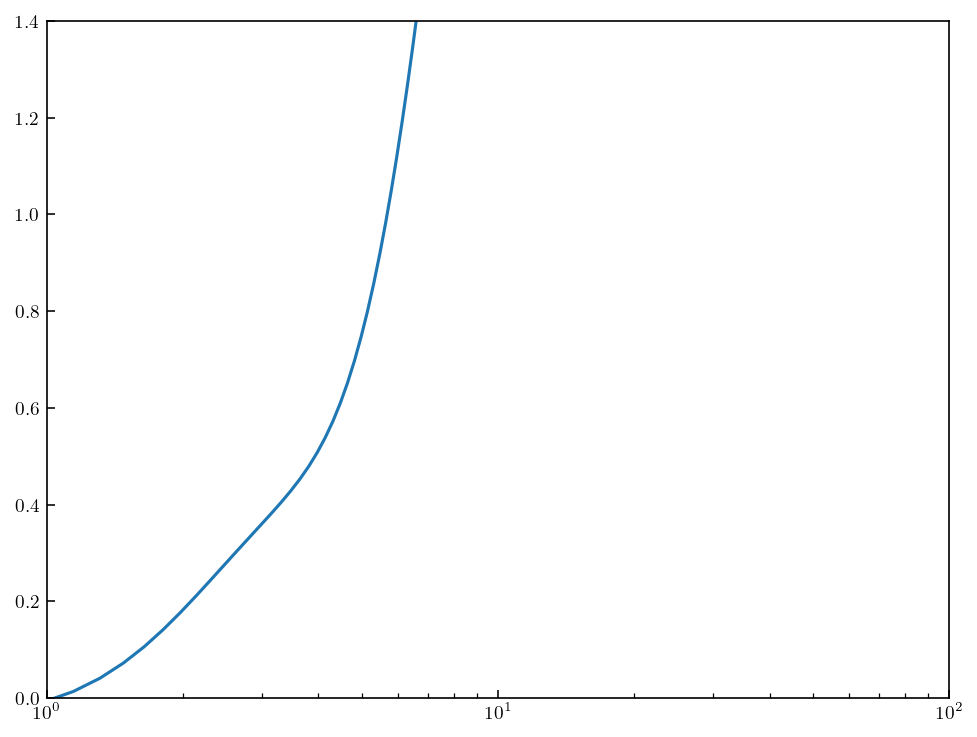

In [44]:
# plot the pressure scaled to see what's up
plt.xscale('log')
plt.ylim(0.0,1.4)
plt.xlim(1,max(density_all)/n0)
plt.plot(density_all/n0, mean_chiral_pressure_scaled[:,3])

---
## Obtaining $n(\mu)$ 

The first and known thing to do is to determine $\mu(n)$, which is simple enough by taking the information from above and plotting it with respect to n.

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


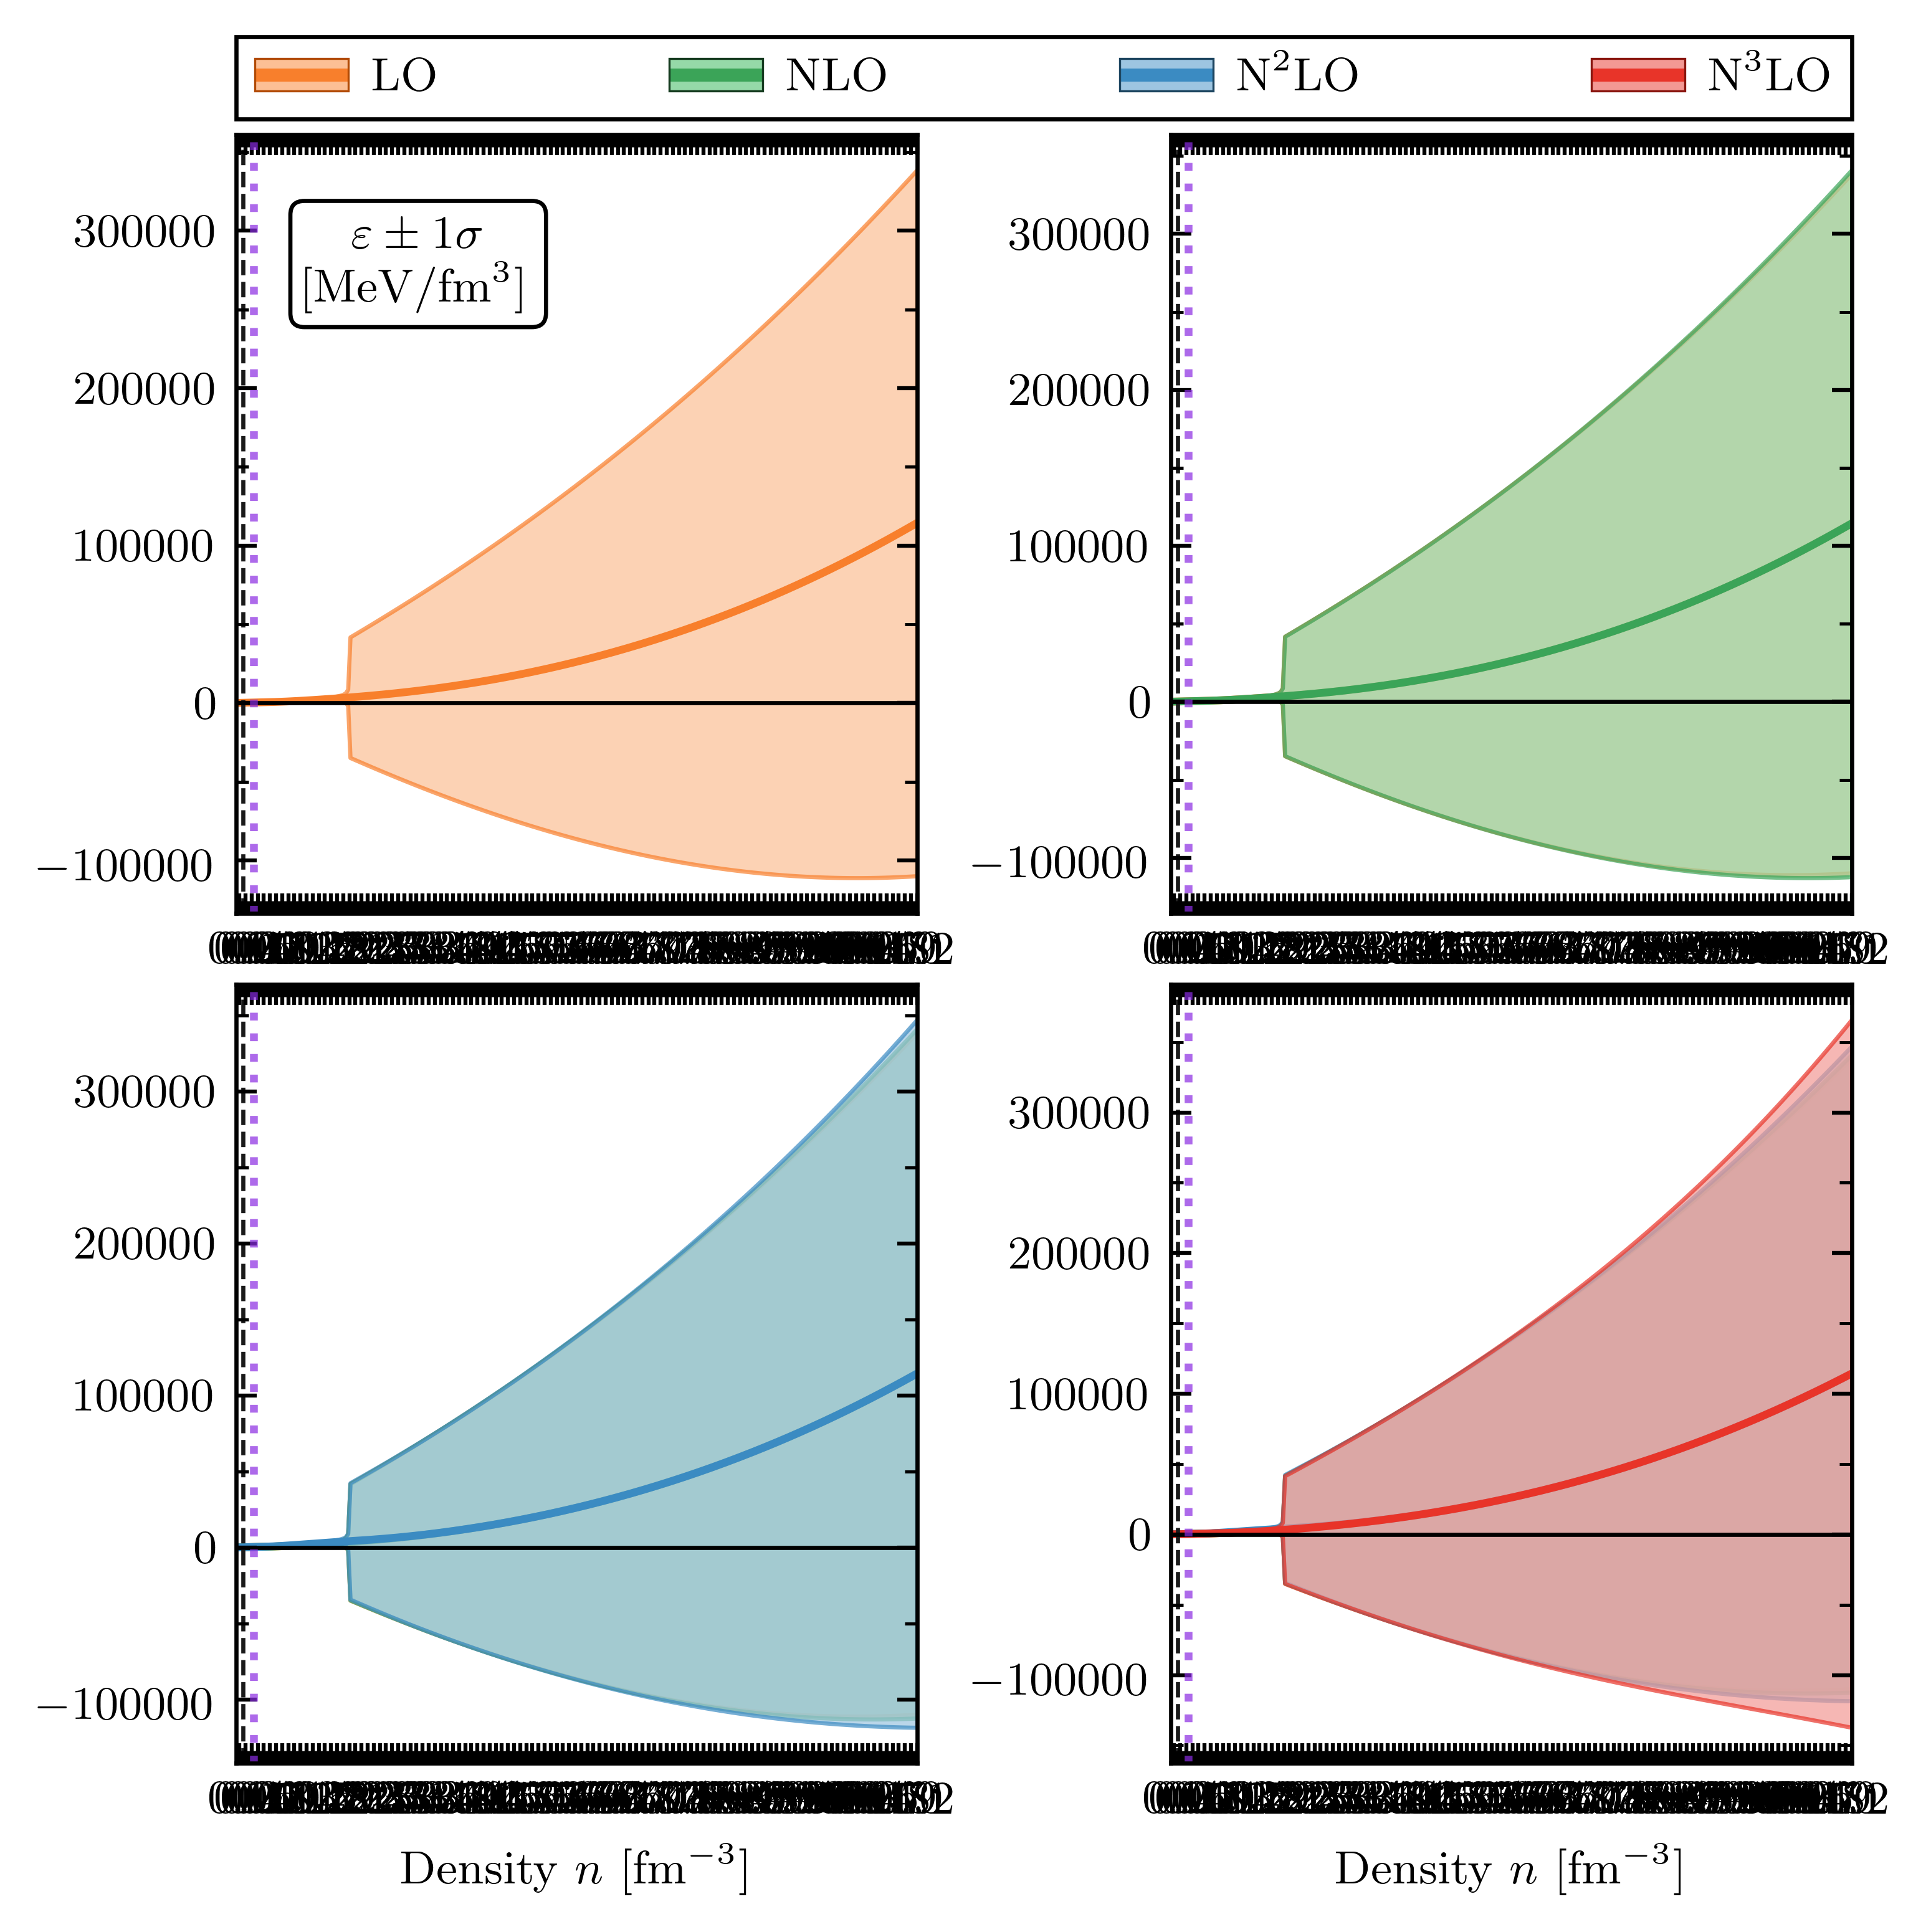

11.2
114395.63429713718
366068.5963649615
-137277.32777068714


In [47]:
# # look at the densities we have 
# print('Our densities, n, are: \n', density_all)

# # obtain energy density via (E/A) * n by multiplying each order
# energy_density_s = np.zeros([len(energies_s_mn), 4])
# energy_density_s_stds = np.zeros([len(energy_s_stds), 4])

# for i in range(4):
#     energy_density_s[:,i] = energies_s_mn[:,i] * density_all 
#     energy_density_s_stds[:,i] = energy_s_stds[:,i] * density_all 

# call the chiral function
energy_density_s, energy_density_s_stds = chiral.energy_dens(add_rest_mass=True)
    
# plot the energy density now wrt n 
fig, axes = plot_obs_panels(
    density_all, y=energy_density_s, dy=energy_density_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

# axes[0, 0].set_ylim(-500, 4000-1e-5)
# axes[1, 0].set_ylim(-500, 4000-1e-5)
for ax in axes.reshape(-1):
#     ax.set_xlim(0.05, 3.2)
#     ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

# axes[0, 0].set_ylim(-15, 7.5-1e-5)
# axes[1, 0].set_ylim(-15, 7.5-1e-5)
label = r"""$\varepsilon \pm 1\sigma$
[MeV/fm$^3$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

print(density_all[-1])
print(energy_density_s[-1,3])
print(energy_density_s[-1,3]+energy_density_s_stds[-1,3])
print(energy_density_s[-1,3]-energy_density_s_stds[-1,3])

Now we want to get the result for $\mu(n)$. This can be done two different ways: by calculating the form from the thermodynamic identity, which includes terms we entirely possess,
$$
\mu(n) = \frac{P(n) + \varepsilon(n)}{n},
$$

or we can take the derivative of the energy density above,
$$
\mu(n) = \frac{\partial \varepsilon(n)}{\partial n} = n \frac{\partial(E/A)}{\partial n} + \frac{\varepsilon(n)}{n} = \frac{k_{F}}{3} \frac{\partial(E/A)}{\partial k_{F}} + \frac{\varepsilon(n)}{n}.
$$

Here $k_{F} = (3 \pi^{2} n/2)^{1/3}$. We'll compute both to check that we understand how this code operates.

In [46]:
# compute the first equation above (from TI)
# ti_upper = pressures_s + energy_density_s
# ti_upper_stds = pressure_s_stds + energy_density_s_stds
# mu_s = np.zeros([len(ti_upper), 4])
# mu_s_stds = np.zeros([len(ti_upper), 4])

# for i in range(4):
#     mu_s[:,i] = ti_upper[:,i]/density_all
#     mu_s_stds[:,i] = ti_upper_stds[:,i]/density_all
    
# # compute the second equation above (derivative of energy density)
k_F = (3.0/2.0 * np.pi**2.0 * density_all)**(1.0/3.0)

# dE = np.zeros([len(mu_s), 4])
# dE_cov = np.zeros([len(dE), len(dE)])
# dE_std = np.zeros([len(dE), 4])

# mu_s_deriv = np.zeros([len(mu_s), 4])
# mu_s_deriv_stds = np.zeros([len(mu_s_stds), 4])

# for i, n in enumerate(orders):
#     dE[:,i] = obs_nuclear.get_pred(order=n, deriv=1) # same as dE in code above; derivative of E/A wrt k_F
#     dE_cov = obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1)
#     dE_std[:,i] = np.sqrt(np.diag(dE_cov))
    
# for i in range(4):
#     mu_s_deriv[:,i] = (k_F * dE[:,i])/3.0 + (energy_density_s[:,i]/density_all)
#     mu_s_deriv_stds[:,i] = (k_F * dE_std[:,i])/3.0 + (energy_density_s_stds[:,i]/density_all)

Now we can plot both results of $\mu(n)$ and see if they are equal. 

mu(n) using the thermodynamic identity


/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


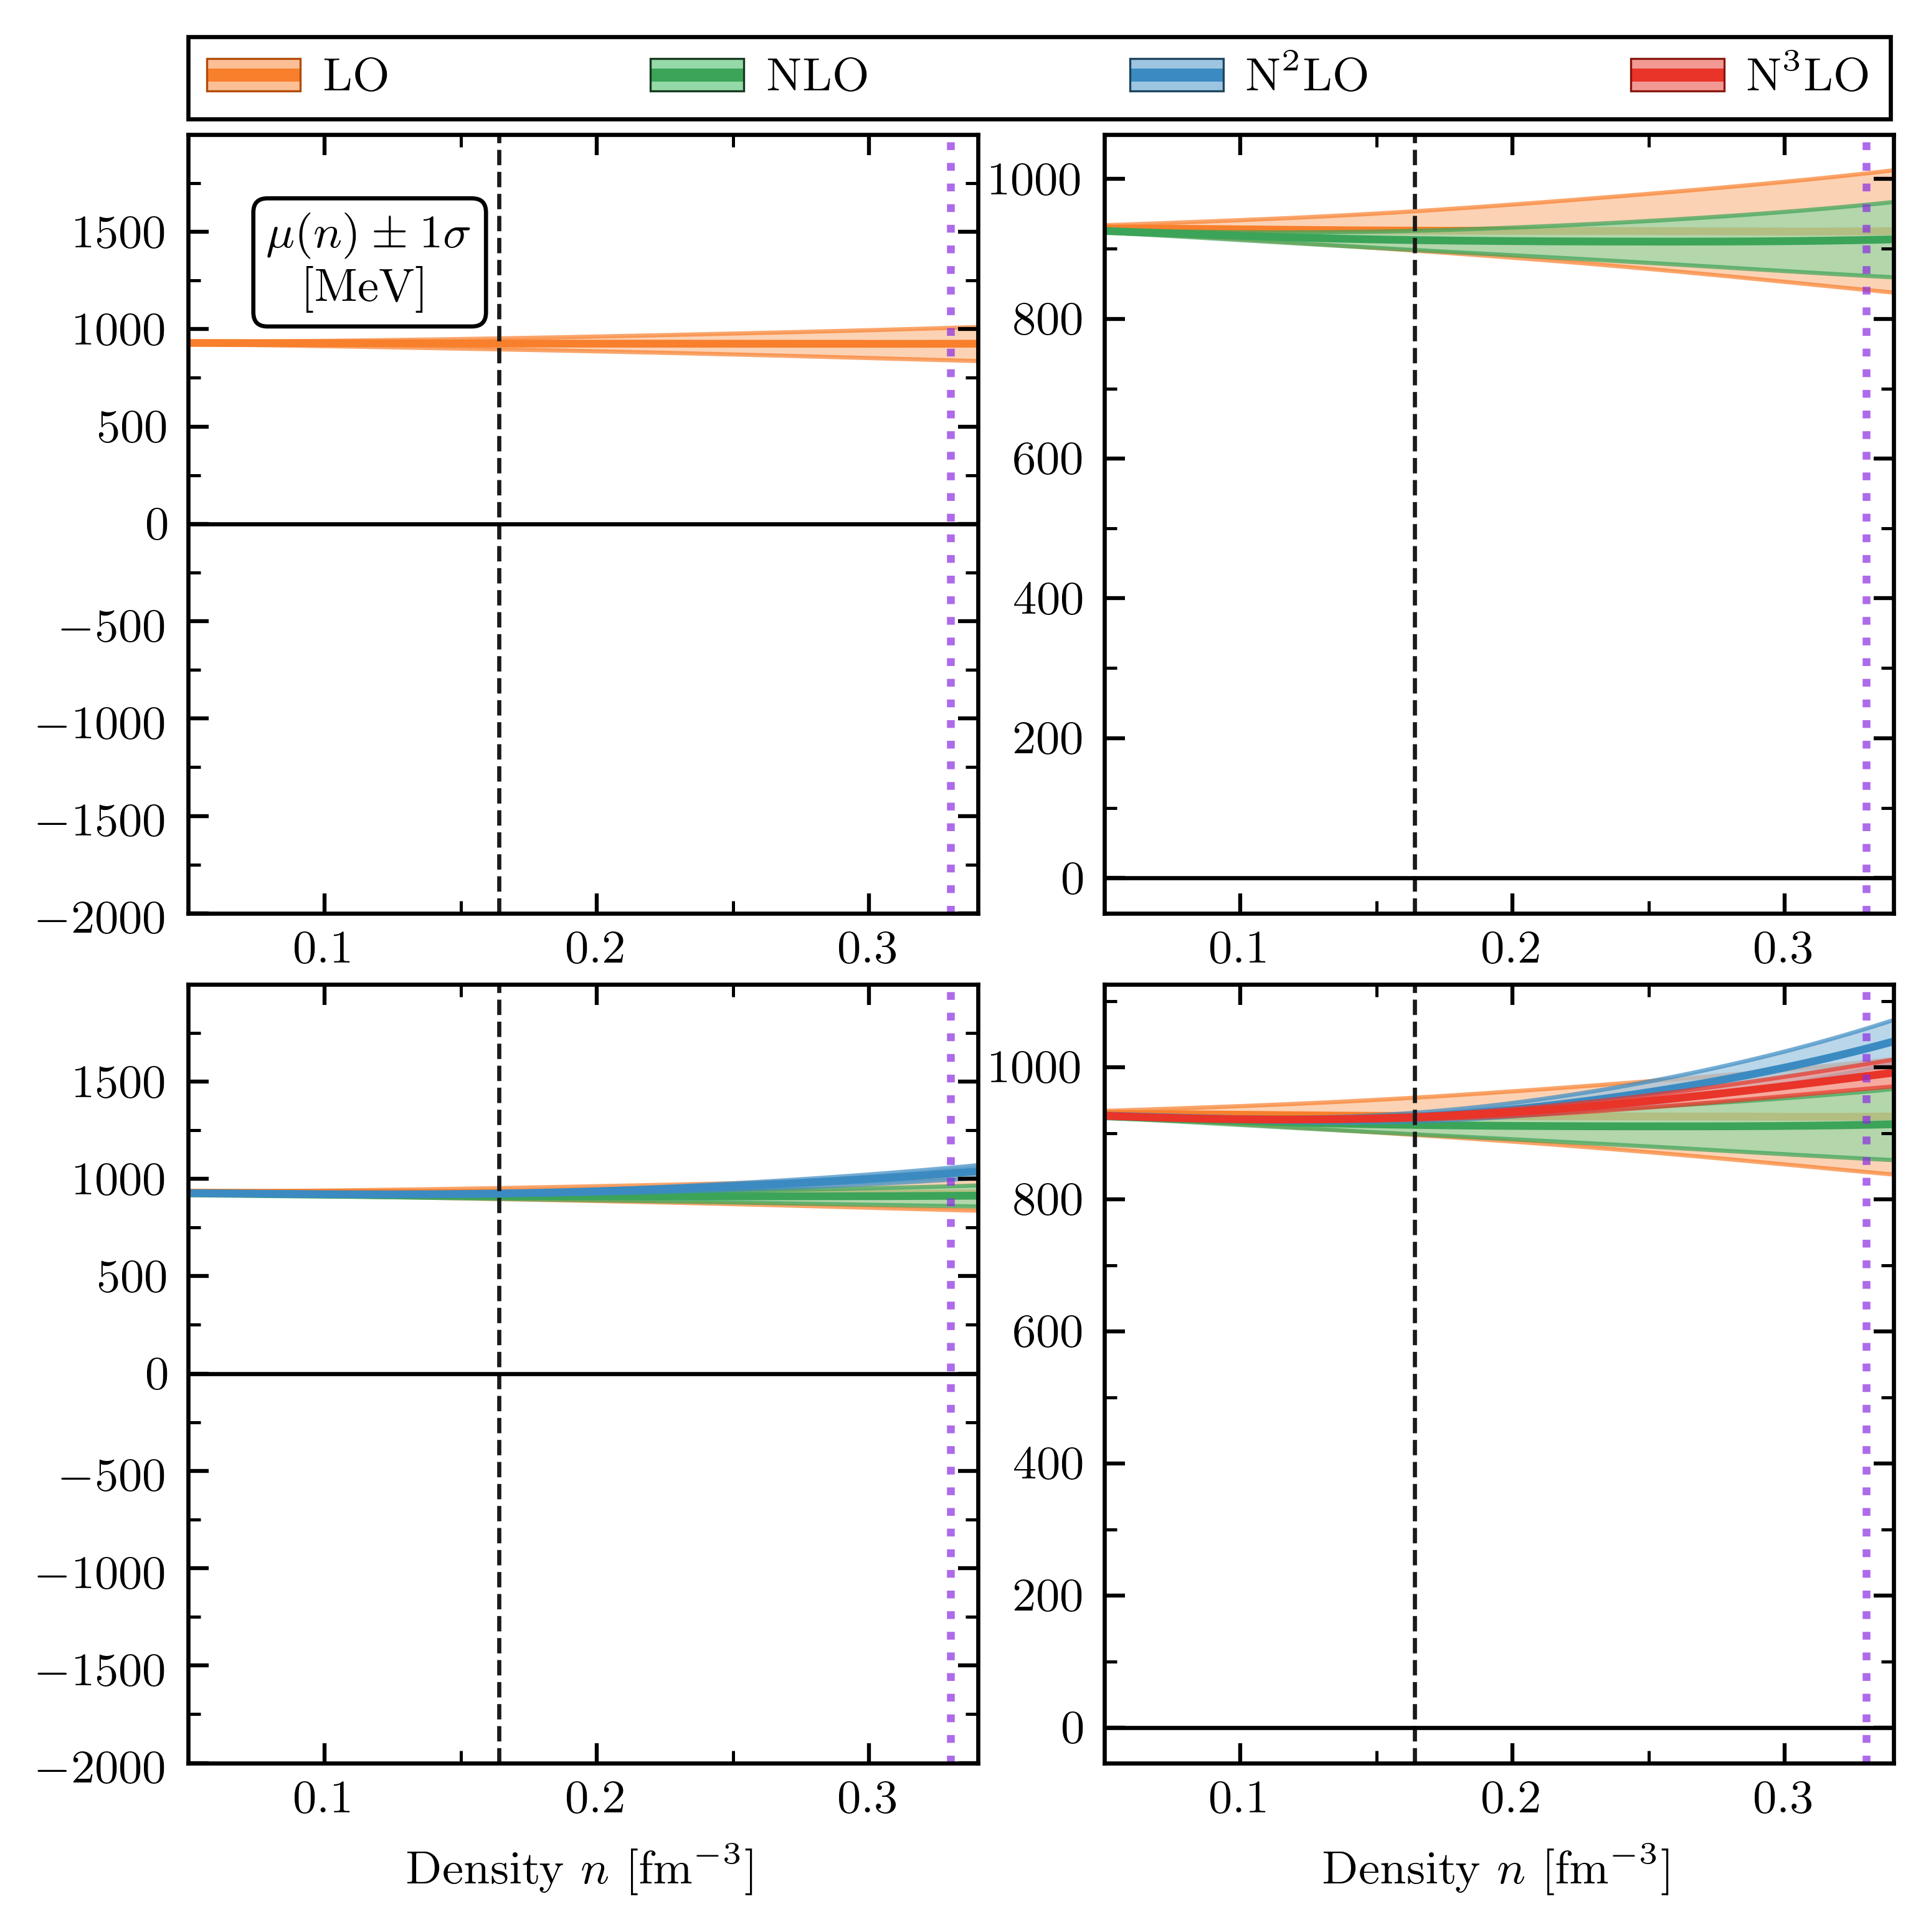

In [47]:
# plot mu(n) using thermodynamic identity
# call chiral function first
mu_s, mu_s_stds = chiral.chemical_potential(method=1, add_rest_mass=True)
fig, axes = plot_obs_panels(
    density_all, y=mu_s, dy=mu_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(-2000, 2000-1e-5)
axes[1, 0].set_ylim(-2000, 2000-1e-5)
#axes[0, 0].set_ylim(-1000, 3000-1e-5)
#axes[1, 0].set_ylim(-1000, 3000-1e-5)
for ax in axes.reshape(-1):
  #  ax.set_xlim(0.05, 3.2)
   # ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])    
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

# axes[0, 0].set_ylim(-25, 20-1e-5)
# axes[1, 0].set_ylim(-25, 20-1e-5)
label = r"""$\mu(n) \pm 1\sigma$
[MeV]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
#fig.savefig(join(fig_path, f'energy_obs-s_panels_Lambda-{Lambda}'))
print('mu(n) using the thermodynamic identity')
plt.show()

mu(n) using the derivative of epsilon


/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


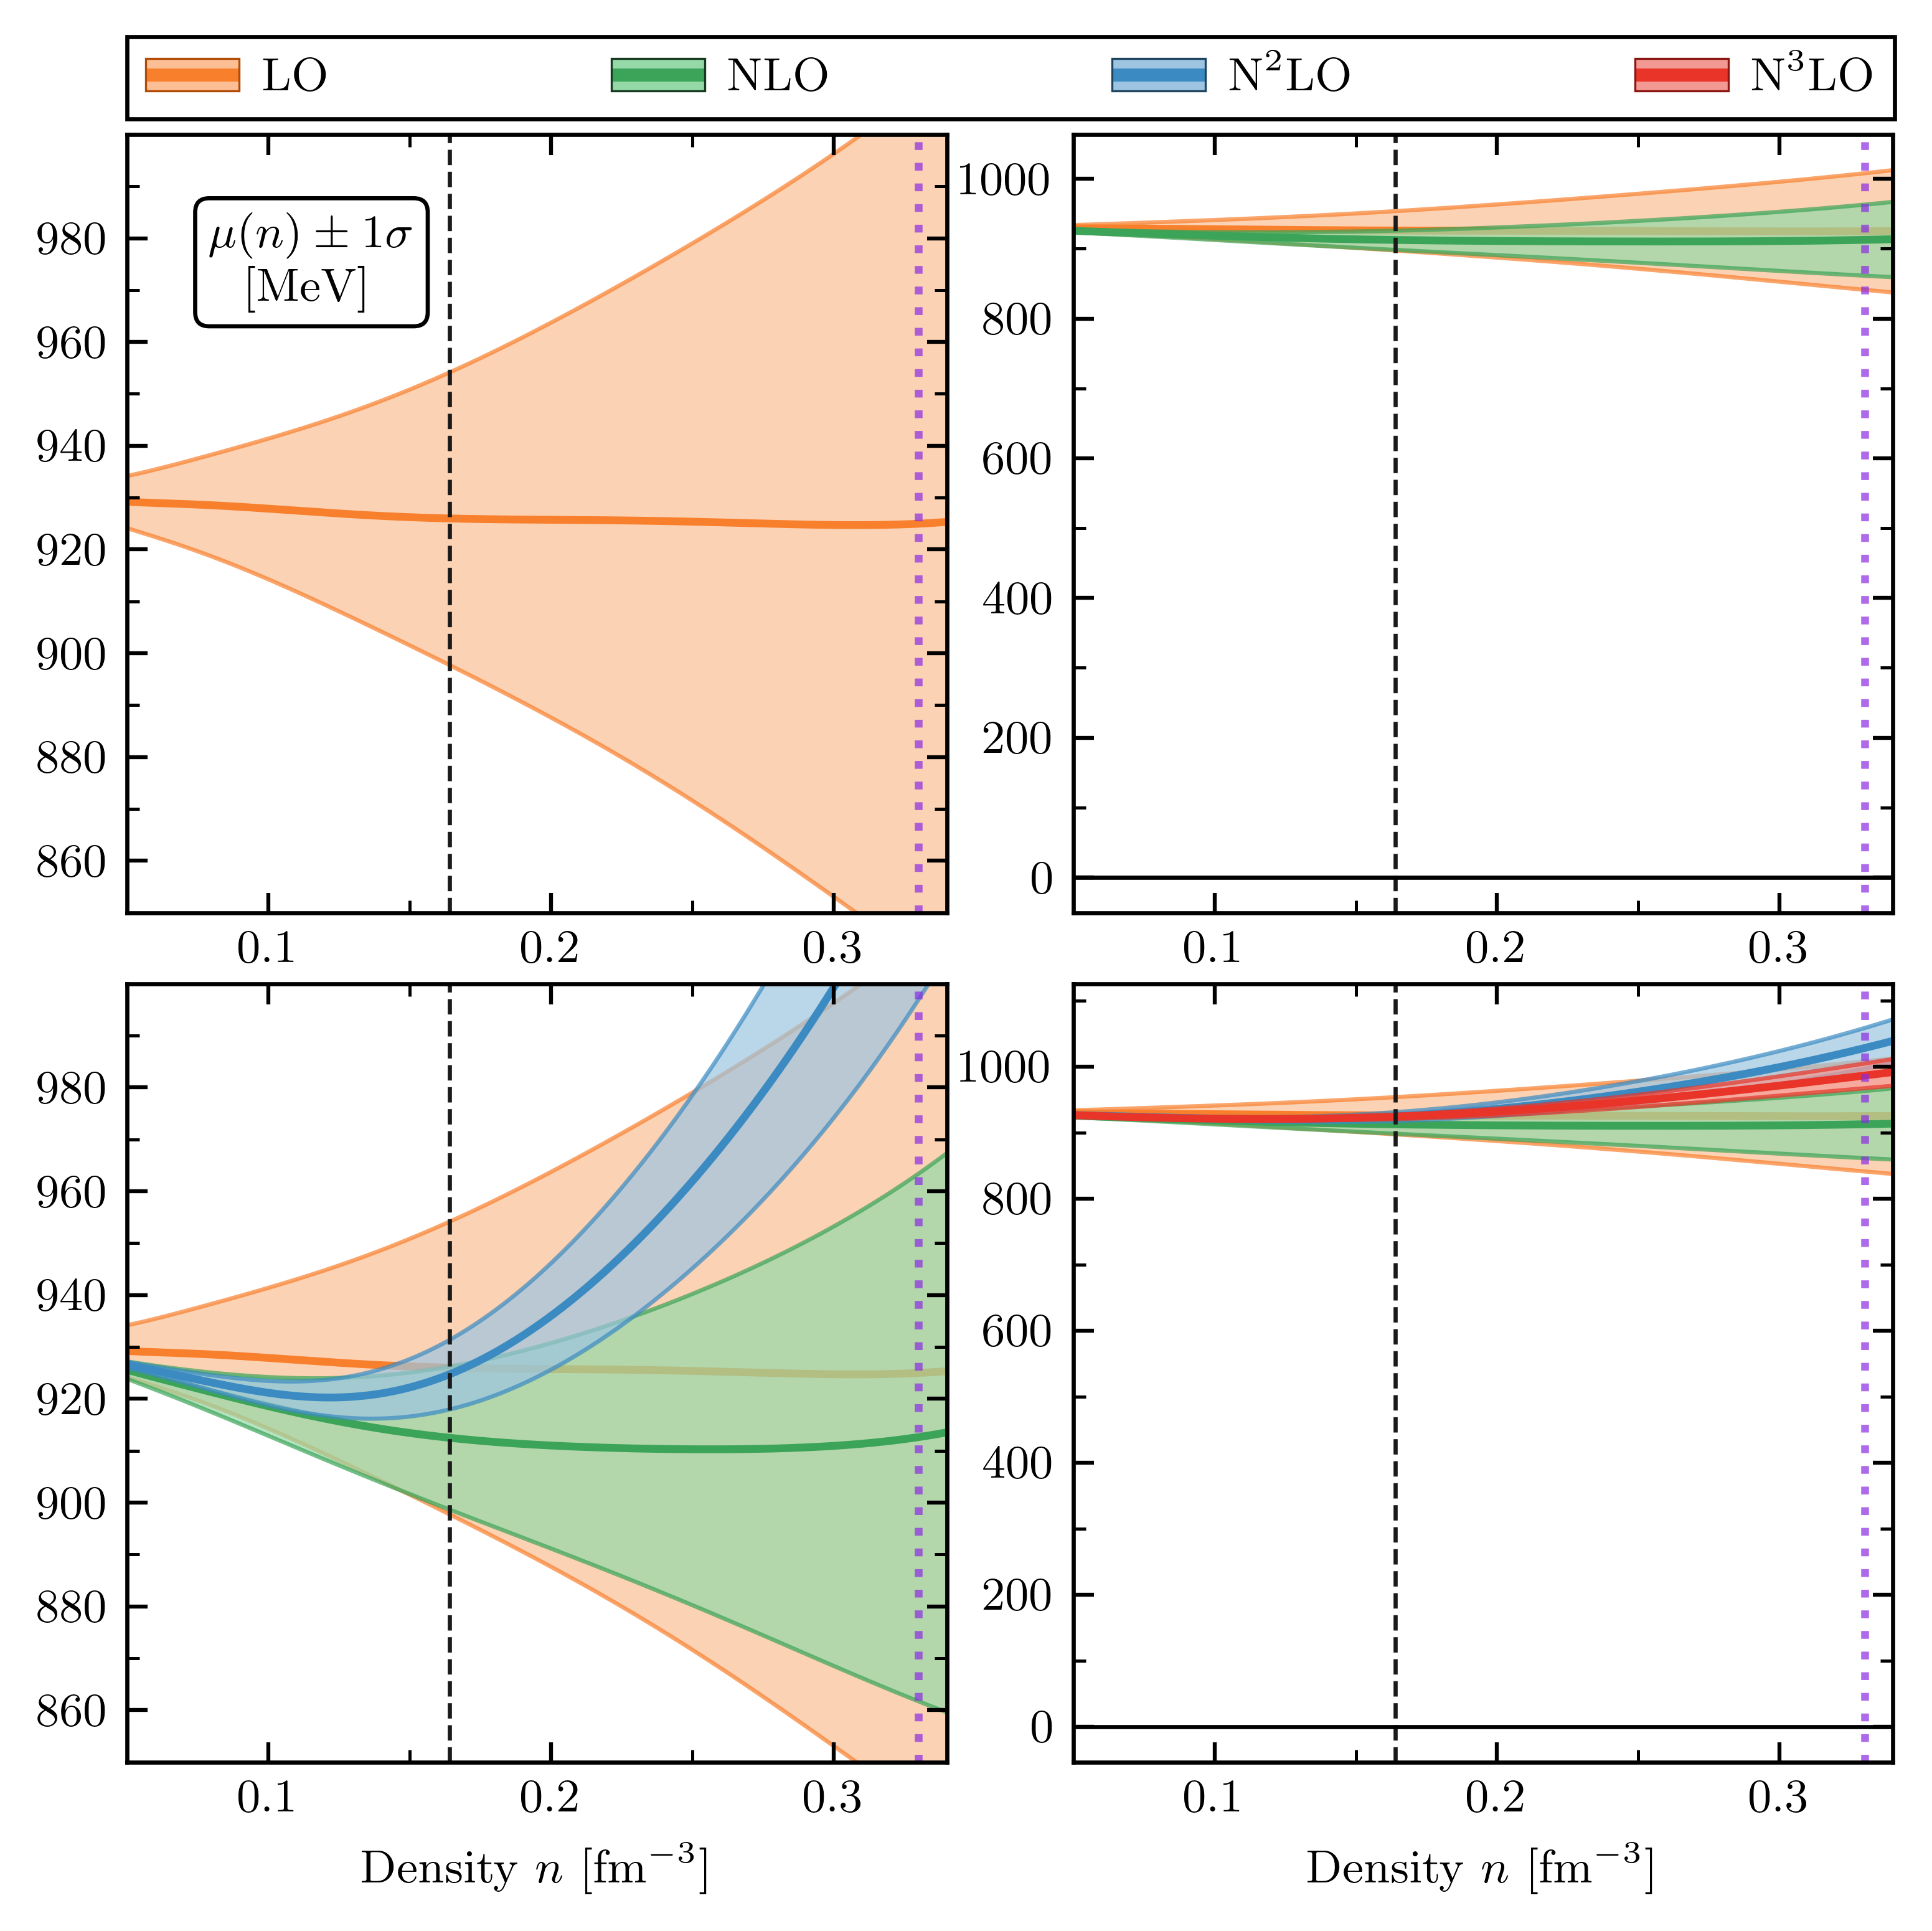

[[ 929.198711    925.5511143   926.58405731  926.31960282]
 [ 929.17200023  925.40839153  926.47119471  926.17978177]
 [ 929.14670747  925.26610812  926.35861014  926.04055593]
 ...
 [ 925.24097988  913.33233029 1036.75051345  990.60056137]
 [ 925.28066379  913.4280297  1037.82694113  991.10659131]
 [ 925.32205738  913.5257582  1038.90993119  991.61289969]]


In [48]:
# plot mu(n) using the derivative of eps
# first call chiral function
mu_s_deriv, mu_s_deriv_stds = chiral.chemical_potential(method=2, add_rest_mass=True)

fig, axes = plot_obs_panels(
    density_all, y=mu_s_deriv, dy=mu_s_deriv_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(850, 1000-1e-5)
axes[1, 0].set_ylim(850, 1000-1e-5)
# axes[0, 0].set_ylim(-1000, 3000-1e-5)
# axes[1, 0].set_ylim(-1000, 3000-1e-5)
for ax in axes.reshape(-1):
#     ax.set_xlim(0.05, 3.2)
#     ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])
     ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

# axes[0, 0].set_ylim(-25, 20-1e-5)
# axes[1, 0].set_ylim(-25, 20-1e-5)
label = r"""$\mu(n) \pm 1\sigma$
[MeV]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
print('mu(n) using the derivative of epsilon')
plt.show()

print(chiral.mu_s)

## Speed of sound ($c_{s}^{2}$)

Now we want to calculate the speed of sound. This can be done via the simple relation

$$
c_{s}^{2} = \frac{n}{\mu}\frac{\partial \mu}{\partial n}.
$$

We know $n$ as our density array, and $\mu(n) \equiv \mu$ from our relation plotted above. We still need the derivative of $\mu(n)$ with respect to $n$. Since our GP results are with respect to $k_{F}$, it might be prudent to take the derivative and split it with respect to $k_{F}$, so that our results can have propagated uncertainties from the GP used for $E/A$. 

The equation for the chemical potential is

$$
\mu(n) = \frac{\partial \varepsilon(n)}{\partial n} = n \frac{\partial(E/A)}{\partial n} + \frac{\varepsilon(n)}{n} = \frac{k_{F}}{3} \frac{\partial(E/A)}{\partial k_{F}} + \frac{\varepsilon(n)}{n}.
$$

We can take the derivative of this, which yields

$$
\frac{\partial \mu(n)}{\partial n} = \frac{\partial}{\partial n} \left( \frac{k_{F}}{3} \frac{\partial(E/A)}{\partial k_{F}} + \frac{\varepsilon(n)}{n} \right),
$$

or we can take an alternate route with the calculation done before, recopied below.

\begin{align}
c_s^2 & = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n} \left[ \frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{\partial P}{\partial n} \left[ \frac{E}{A} + m + n \, \frac{\partial }{\partial n} \frac{E}{A} \right]^{-1} \\
\frac{\partial P}{\partial n} & = 2n \frac{d}{dn} \frac{E}{A} + n^2 \frac{d^2}{dn^2} \frac{E}{A}
\end{align}

Here, we know that $\frac{\partial \varepsilon(n)}{\partial n} \equiv \mu(n)$, so we don't have to do anything there except divide. The trickier piece is now $\frac{\partial P}{\partial n}$.

$$
c_{s}^{2} = \frac{\partial P}{\partial n} \mu(n)^{-1}.
$$

In [48]:
# check the difference to make sure everything is still OK
#print(mu_s - mu_s_deriv) # we're good!

## Inverting $\mu(n)$ for $n(\mu)$

Now we need to invert the above results. Notice that the solutions will not be unique below the zero line. We'll deal with that as well. 

Note that we're having issues with inverting when looking at Lambda = 450 MeV. Instead of doing the fsolve technique, can we instead invert the interpolated arrays and work with that? We can cut the ranges down to whatever we need if necessary.

In [47]:
if chiral.Lambda == 500:
    pass
#     # first we will look at N3LO because we aren't stupid (but apparently in Lambda=450 we are)
#     mu_N3LO = mu_s[:,3]
#     mu_stds_N3LO = mu_s_stds[:,3]

#     # interpolate between the arrays above
#     mu_N3LO_interp = interpolate.interp1d(density_all, mu_N3LO, kind='cubic')

#     # root finder function to run over all mu
#     def f_n(mu, guess):  
#         return optimize.fsolve(lambda n : mu - mu_N3LO_interp(n), x0 = guess)[0]

#     # try this out on mu = -10
#     f_n_test = f_n(mu=950.0, guess=0.18)  # works!
#     print(f_n_test)

#     # set a new density linspace and mu for tight interpolation
#     nnew = np.linspace(0.05, 0.339, 500)  
#     mu_new = mu_N3LO_interp(nnew)

#     # determine region where two solutions exist to avoid it
#     mu_min = min(mu_new)
#     mu_max = mu_new[0]
#     n_min = f_n(mu=mu_max, guess=0.16)

#     # solve for the new values in density (n(mu))
#     n_solve = []
#     index = []

#     for i in range(len(nnew)):
#         if nnew[i] > n_min:
#             index.append(i)
#             n_solve.append(nnew[i])
#     mu_solve = mu_new
#     mu_solve_lower = mu_new[:index[0]]

#     # now we plot the result wrt mu as our function for n(mu)
#     f_n_N3LO = []
#     f_n_N3LO_lower = []
#     for i in mu_solve:
#         f_n_N3LO.append(f_n(i, guess=0.33))
#     for i in mu_solve_lower:
#         f_n_N3LO_lower.append(f_n(i, guess=0.05))   # guess = 0.05 for Lambda=500 MeV

    # plot the result now for n(mu)
#     fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4), dpi=200)

#     ax1.set_xlim(0.05, 0.34)
#     ax1.set_ylim(910, 1000-1e-5)
#  #   ax1.set_ylim(-25, 20-1e-5)
#     ax1.plot(nnew, mu_new, 'k')
#     ax1.axhline(y=mu_min, color='red', linestyle='dotted')
#     ax1.axhline(y=mu_max, color='red', linestyle='dotted')
#     ax1.set_title(r'$\mu(n)$')
#     ax1.set_xlabel(r'$n$')
#     ax1.set_ylabel(r'$\mu$')

#     ax2.set_title(r'$n(\mu)$')
#     ax2.set_xlabel(r'$\mu$')
#     ax2.set_ylabel(r'$n$')
#  #   ax2.set_xlim(-25, 20-1e-5)
#     ax2.set_xlim(910, 1000-1e-5)
#     ax2.set_ylim(0.05, 0.339)
#     ax2.plot(mu_solve, f_n_N3LO, 'k')
#     ax2.plot(mu_solve_lower, f_n_N3LO_lower, 'k')
#     ax2.plot(mu_new, nnew, color='red', linestyle='dotted')
#     ax2.axvline(x=mu_max, color='red', linestyle='dotted')
#     ax2.axvline(x=mu_min, color='red', linestyle='dotted')
#     plt.show()

#     print(mu_min, mu_max)

if chiral.Lambda == 450:
    pass
    
#     # try just inverting the interpolation
#     mu_N3LO = mu_s[:,3]
#     mu_stds_N3LO = mu_s_stds[:,3]

#     # interpolate between the arrays above
#     mu_N3LO_interp = interpolate.interp1d(density_all, mu_N3LO, kind='cubic')
    
#      # set a new density linspace and mu for tight interpolation
#     nnew = np.linspace(0.05, 0.339, 500)  
#     mu_new = mu_N3LO_interp(nnew)

#     # determine region where two solutions exist to avoid it
#     mu_min = min(mu_new)
#     mu_max = mu_new[0]
#     index_mu = np.where(mu_new==mu_min)[0][0]
    
#     # write new density array without the bottom half of mu
#     mu_upper = mu_new[index_mu:]
#     n_upper = nnew[index_mu:]
    
#     # determine the point in density we need to stop at
#     nearest = mu_upper.flat[np.abs(mu_upper - mu_max).argmin()]
#     index = np.where(mu_upper==nearest)[0][0]
#     n_min = n_upper[index]
    
#     print(mu_min, mu_max)
#     print('Density at which we stop: ', n_min)
    
#     fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4), dpi=200)

#     ax1.set_xlim(0.05, 0.34)
#     ax1.set_ylim(910,1000-1e-5)
#     #ax1.set_ylim(-25, 20-1e-5)
#     ax1.plot(nnew, mu_new, 'k')
#     ax1.axhline(y=mu_min, color='red', linestyle='dotted')
#     ax1.axhline(y=mu_max, color='red', linestyle='dotted')
#     ax1.set_title(r'$\mu(n)$')
#     ax1.set_xlabel(r'$n$')
#     ax1.set_ylabel(r'$\mu$')

#     ax2.set_title(r'$n(\mu)$')
#     ax2.set_xlabel(r'$\mu$')
#     ax2.set_ylabel(r'$n$')
#     ax2.set_xlim(910, 1000-1e-5)
#     #ax2.set_xlim(-25, 20-1e-5)
#     ax2.set_ylim(0.05, 0.339)
#     ax2.plot(mu_new, nnew, color='red')
#     ax2.plot(mu_upper, n_upper, color='black')
#     ax2.plot(nearest, n_min, color='blue', marker='.', markersize=10)
#     ax2.axvline(x=mu_max, color='red', linestyle='dotted')
#     ax2.axvline(x=mu_min, color='red', linestyle='dotted')
#     plt.show()

Since `fsolve` sucks and will not give me any good results for inversion using Lambda = 450 MeV, we need to get around this problem. We can do so by manually flipping our mu(n) function to n(mu) using the arrays. However, this means we need to be careful of the non-unique region, which we have successfully done so far. 

In [49]:
# # root finder function to run over all mu
# def f_n(mu, mu_func, guess):  
#     return optimize.fsolve(lambda n : mu - mu_func(n), x0 = guess)[0]

# # write the entire process into a function to run over all orders
# def inversion(n, mu, guess, nnew=None):
    
#     # interpolate the arrays
#     mu_interp = interpolate.interp1d(n, mu, kind='cubic')
    
#     # set a new density linspace and mu for tight interpolation
#     if nnew is not None:
#         mu_new = mu_interp(nnew)
#     else:
#         mu_new = mu_interp(n)
    
#     # call root finder
#     f_n_result = []
#     for i in mu_new:
#         f_n_result.append(f_n(i, mu_interp, guess=0.33))
    
#     return mu_new, f_n_result

In [50]:
# if chiral.Lambda == 450:
    
# #     # manual inversion because fsolve sucks (N3LO here; change higher up if needed)
# #     nmu_450 = n_upper
# #     mu_450 = mu_upper
    
# #     # use interpolation to get more points in density (function)
# #     n_interp = interpolate.interp1d(mu_450, nmu_450, kind='cubic')
    
# #     # use the function to generate density curve in mu
# #     mu_N3LO = mu_s[:,3]
# #     nearest = mu_N3LO.flat[np.abs(mu_N3LO - mu_max).argmin()]
# #     index = np.where(mu_N3LO==nearest)[0][0]  
    
# #     mu_slice = mu_N3LO[index+1:]
    
# #     # cut this array to fit the interpolation length
# #     nearest = mu_slice.flat[np.abs(mu_slice - mu_upper[-1]).argmin()]
# #     index = np.where(mu_slice==nearest)[0][0]  
# #     mu_slice = mu_slice[:index-1]
    
# #     nmu_new = n_interp(mu_slice)
    
# if chiral.Lambda == 500:
    
# #     # now try running this over all orders -> actually only N2LO and N3LO
# #     guess = 0.33

# #     mu_inversion_N3LO = np.asarray(inversion(density_all, mu_s[:,3], guess=guess, xnew=xnew))
# #     mu_inversion_N3LO_stds_plus = np.asarray(inversion(density_all, mu_s[:,3]+mu_s_stds[:,3], guess=0.33, xnew=xnew))
# #     mu_inversion_N3LO_stds_minus = np.asarray(inversion(density_all, mu_s[:,3]-mu_s_stds[:,3], guess=0.33, xnew=xnew))

# #     print('Lowest density found: N3LO = {}'.format(mu_inversion_N3LO[1][0]))

## Obtaining P$(\mu)$, $\varepsilon(\mu)$

Now that we've got this inversion at N2LO and N3LO, we can use it to implicitly solve for the pressure and energy density as functions of $\mu$ instead of $n$. Note that we now only want densities above the cutoff in the functions above, so densities above 0.175 fm$^{-3}$ or so. 

In order to do this well, we need to determine the range of $\mu$ that corresponds to the densities we want. Let's do that first.

In [52]:
if chiral.Lambda == 450:
#     #collect arrays from before
#     mu_N3LO_array = mu_slice
#     density_mu_N3LO = nmu_new
#     print(min(density_mu_N3LO), max(density_mu_N3LO))

    # call the chiral function
    density_mu_N3LO, mu_N3LO_array, kf_N3LO = chiral.inversion()

if chiral.Lambda == 500:
#     # send in the densities in terms of the mu we want
#     mu_N3LO_array = mu_inversion_N3LO[0] # mu values we now are working with in ALL cases below
#     density_mu_N3LO = mu_inversion_N3LO[1] # densities found given a specific mu array

#     # figure out the density cutoff in mu by finding nearest value
#     n_cutoff = mu_inversion_N3LO[1][0]
#     nearest = density_mu_N3LO.flat[np.abs(density_mu_N3LO - n_cutoff).argmin()]
#     index = np.where(density_mu_N3LO==nearest)[0][0]
#     mu_cutoff = mu_N3LO_array[index]
# #    mu_cutoff = -12.599151524411129 # from the above inversion work

#     # now use this cutoff to stop from calculating beyond this point 
#     index = np.where(mu_N3LO_array > mu_cutoff)
#     mu_N3LO_array = mu_N3LO_array[index[0][0]:]
#     density_mu_N3LO = density_mu_N3LO[index[0][0]:]
    
#     print(min(density_mu_N3LO), max(density_mu_N3LO))

# because we will need kf, redo this calculation
#kf_N3LO = (3.0 * np.square(np.pi) * density_mu_N3LO / 2.0)**(1.0/3.0)

# do all of the above using chiral function
    density_mu_N3LO, mu_N3LO_array, kf_N3LO = chiral.inversion(guess=0.33)
    
# from here maybe we can use another density array
print(density_mu_N3LO)

0.1820480961923849 0.33900000000000013
[0.1820481  0.18262725 0.18320641 0.18378557 0.18436473 0.18494389
 0.18552305 0.1861022  0.18668136 0.18726052 0.18783968 0.18841884
 0.188998   0.18957715 0.19015631 0.19073547 0.19131463 0.19189379
 0.19247295 0.1930521  0.19363126 0.19421042 0.19478958 0.19536874
 0.1959479  0.19652705 0.19710621 0.19768537 0.19826453 0.19884369
 0.19942285 0.200002   0.20058116 0.20116032 0.20173948 0.20231864
 0.2028978  0.20347695 0.20405611 0.20463527 0.20521443 0.20579359
 0.20637275 0.2069519  0.20753106 0.20811022 0.20868938 0.20926854
 0.2098477  0.21042685 0.21100601 0.21158517 0.21216433 0.21274349
 0.21332265 0.2139018  0.21448096 0.21506012 0.21563928 0.21621844
 0.2167976  0.21737675 0.21795591 0.21853507 0.21911423 0.21969339
 0.22027255 0.2208517  0.22143086 0.22201002 0.22258918 0.22316834
 0.22374749 0.22432665 0.22490581 0.22548497 0.22606413 0.22664329
 0.22722244 0.2278016  0.22838076 0.22895992 0.22953908 0.23011824
 0.23069739 0.23127655 

In [58]:
# call the observable container and replace densities there with those above
# print('Setting up nuclear matter...', flush=True)
# obs_nuclear = ObservableContainer(
#     density=chiral.density, # chiral EFT (?) densities
#     kf=chiral.kf_s,
#     y=chiral.y_s_2_plus_3bf,
#     orders=chiral.orders,
#     density_interp=density_mu_N3LO,  # interpolated density
#     kf_interp=kf_N3LO,
#     std=chiral.std_nuclear,
#     ls=chiral.ls_nuclear,
#     ref=chiral.ref_nuclear,
#     breakdown=chiral.breakdown,
#     err_y=chiral.err_y_s,
#     include_3bf=False,
#     derivs=[0, 1, 2],
#     verbose=verbose,
# )

# call observable container function from chiral code
obs_neutron, obs_nuclear, obs_sym_energy = chiral.data_interpolation(density_int=density_mu_N3LO, kf_s_int=kf_N3LO)

Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8


C:\Users\Alexandra\Desktop\EOSBMM\buqeyenm\nuclear-matter-convergence\nuclear_matter\derivatives.py:323: RuntimeWarning: invalid value encountered in sqrt
  d[i] = np.sqrt(np.diag(cov_ij))


For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
0.973 0.484 0.8119689713375328
For EFT order 0, the best polynomial has max nu = 7
For EFT order 2, the best polynomial has max nu = 7
For EFT order 3, the best polynomial has max nu = 7
For EFT order 4, the best polynomial has max nu = 7
Setup time: 30.047091484069824


Lambda =  500
926.3226711987069 991.0912755283841


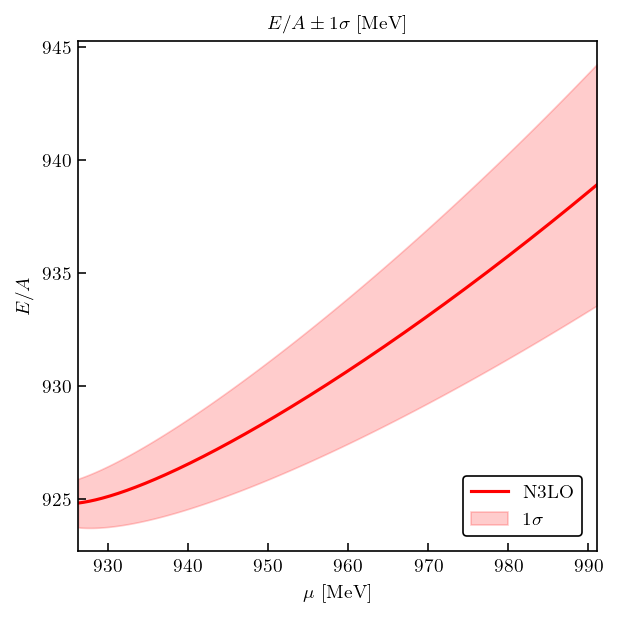

[924.82823441]


In [59]:
# new E/A for new density range from inversion
# only want N3LO; need to figure out how to do single subplot with JAM's methods
# energies_s = np.array([obs_nuclear.get_pred(order=4, deriv=0)]).T
# energy_s_stds = np.array([obs_nuclear.get_std(order=4, deriv=0, include_trunc=True)]).T

# # adding the rest mass here too
# energies_s_mn = energies_s + chiral.rest_mass

# call chiral function 
energies_s_mn, energy_s_stds = chiral.energy_per_particle(add_rest_mass=True, orders='N3LO')

# plot the two results and their bands (sigma=1)
print('Lambda = ', chiral.Lambda)
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
ax.set_title(r'$E/A \pm 1\sigma$ [MeV]')
ax.set_xlabel(r'$\mu$ [MeV]')
ax.set_ylabel(r'$E/A$')
ax.set_xlim(min(mu_N3LO_array), max(mu_N3LO_array))
print(min(mu_N3LO_array), max(mu_N3LO_array))
#ax.set_ylim(-25, 10-1e-5)
#ax.axhline(0.0, color='black', linestyle='dotted')
ax.plot(mu_N3LO_array, energies_s_mn, 'r', label='N3LO')
ax.fill_between(mu_N3LO_array, energies_s_mn[:,0]-energy_s_stds[:,0], energies_s_mn[:,0]+energy_s_stds[:,0], \
                alpha=0.2, color='r', label=r'1$\sigma$')
ax.legend(loc='lower right')
plt.show()

# Min from N3LO originally = -14.12433626
# compare to the new one here (not at saturation equivalence here but close)
print(min(energies_s_mn))

# fix the plot issue; can't remember why it's happening unless it's not cutting the stds array correctly

Lambda =  500


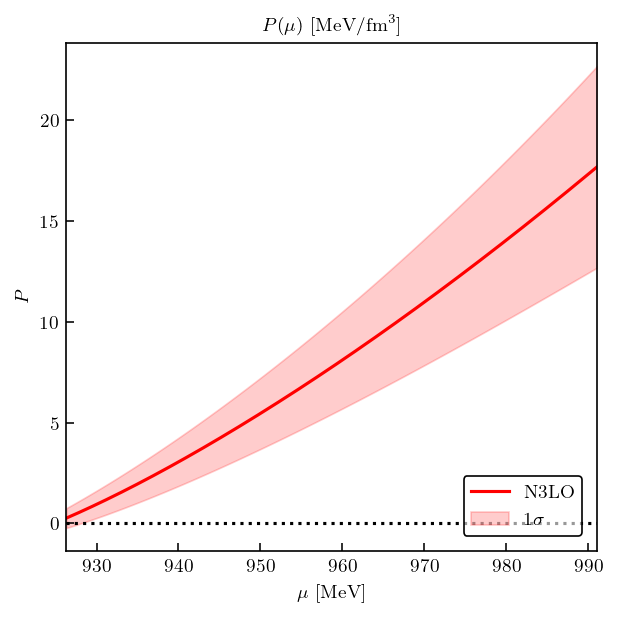

In [348]:
# new P for new density range from inversion (function of mu)
# pressures_s = []
# pressure_s_stds = []
# pressure_s_fits = []

# pressure_s = compute_pressure(
#     obs_nuclear.density_interp,
#     obs_nuclear.kf_interp,
#     dE=obs_nuclear.get_pred(order=4, deriv=1)
# )

# pressure_s_cov = compute_pressure_cov(
#     obs_nuclear.density_interp,
#     obs_nuclear.kf_interp,
#     dE_cov=obs_nuclear.get_cov(order=4, deriv1=1, deriv2=1)
# )

# pressure_s_stds = np.sqrt(np.diag(pressure_s_cov))

# pressure_alt_diff_s = compute_pressure(
#     obs_nuclear.density,
#     obs_nuclear.kf,
#     dE=obs_nuclear.poly_interp(order=4, deriv=1, wrt_kf=False),
#     wrt_kf=False
# )

# pressures_s = np.array(pressures_s).T
# pressure_s_stds = np.array(pressure_s_stds).T
# pressure_s_fits = np.array(pressure_s_fits).T

# call the chiral function
pressure_s, pressure_s_stds = chiral.pressure(orders='N3LO')

# divisive scaling factor for pressure
#pressure_scale = 3.0 * mu**4.0 / (4.0 * np.pi**2.0)

# plot the pressure (N3LO)
print('Lambda = ', chiral.Lambda)
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
ax.set_title(r'$P(\mu)$ [MeV/fm$^{3}$]')
ax.set_xlabel(r'$\mu$ [MeV]')
ax.set_ylabel(r'$P$')
ax.set_xlim(min(mu_N3LO_array), max(mu_N3LO_array))
#ax.set_ylim(-5, 25-1e-5)
ax.axhline(0.0, color='black', linestyle='dotted')
ax.plot(mu_N3LO_array, pressure_s, 'r', label='N3LO')
ax.fill_between(mu_N3LO_array, pressure_s-pressure_s_stds, pressure_s+pressure_s_stds, \
                alpha=0.2, color='r', label=r'1$\sigma$')
ax.legend(loc='lower right')
plt.show()

Lambda =  500


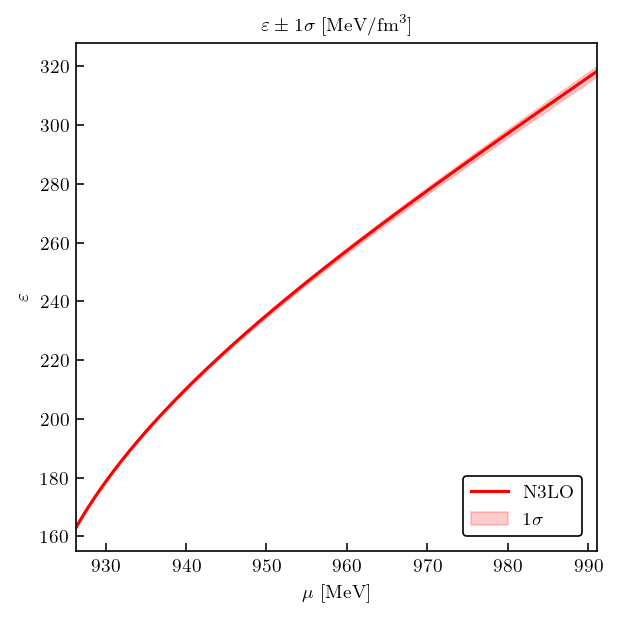

163.0069997451319


In [349]:
#  new energy density with new density from inversion (N3LO)
# energy_density_s = energies_s_mn[:,0] * density_mu_N3LO 
# energy_density_s_stds = energy_s_stds[:,0] * density_mu_N3LO

energy_density_s, energy_density_s_stds = chiral.energy_dens(add_rest_mass=True, orders='N3LO')
    
# plot the energy density
print('Lambda = ', chiral.Lambda)
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
ax.set_title(r'$\varepsilon \pm 1\sigma$ [MeV/fm$^{3}$]')
ax.set_xlabel(r'$\mu$ [MeV]')
ax.set_ylabel(r'$\varepsilon$')
ax.set_xlim(min(mu_N3LO_array), max(mu_N3LO_array))
#ax.set_ylim(-15, 7.5-1e-5)
#ax.axhline(0.0, color='black', linestyle='dotted')
ax.plot(mu_N3LO_array, energy_density_s, 'r', label='N3LO')
ax.fill_between(mu_N3LO_array, energy_density_s-energy_density_s_stds, energy_density_s+energy_density_s_stds, \
                alpha=0.2, color='r', label=r'1$\sigma$')
ax.legend(loc='lower right')
plt.show()

# min from original = -2.8082062535133434 
min_original = -2.8082062535133434
print(min(energy_density_s))

---

In [48]:
# resetting container because we need the old densities first
print('Setting up nuclear matter...', flush=True)
obs_nuclear = ObservableContainer(
    density=density,
    kf=kf_s,
    y=y_s_2_plus_3bf,
    orders=orders,
    density_interp=density_all,    # here is where density is input (could switch to n(mu) if we have numerical values)
    kf_interp=kf_s_all,
    std=std_nuclear,
    ls=ls_nuclear,
    ref=ref_nuclear,
    breakdown=breakdown,
    err_y=err_y_s,
    include_3bf=False,
    derivs=[0, 1, 2],
    verbose=verbose,
)

Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7


$$
L(n) = 3\,n \, \frac{d}{dn} E_\text{sym}(n) = 3n \frac{dk_f}{dn} \frac{d}{dn} E_\text{sym}(n)
     = 3\,n \, \frac{k_f}{3n} \frac{d}{dk_f}  E_\text{sym}(n) = k_f \frac{d}{dk_f} E_\text{sym}(n)
$$

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


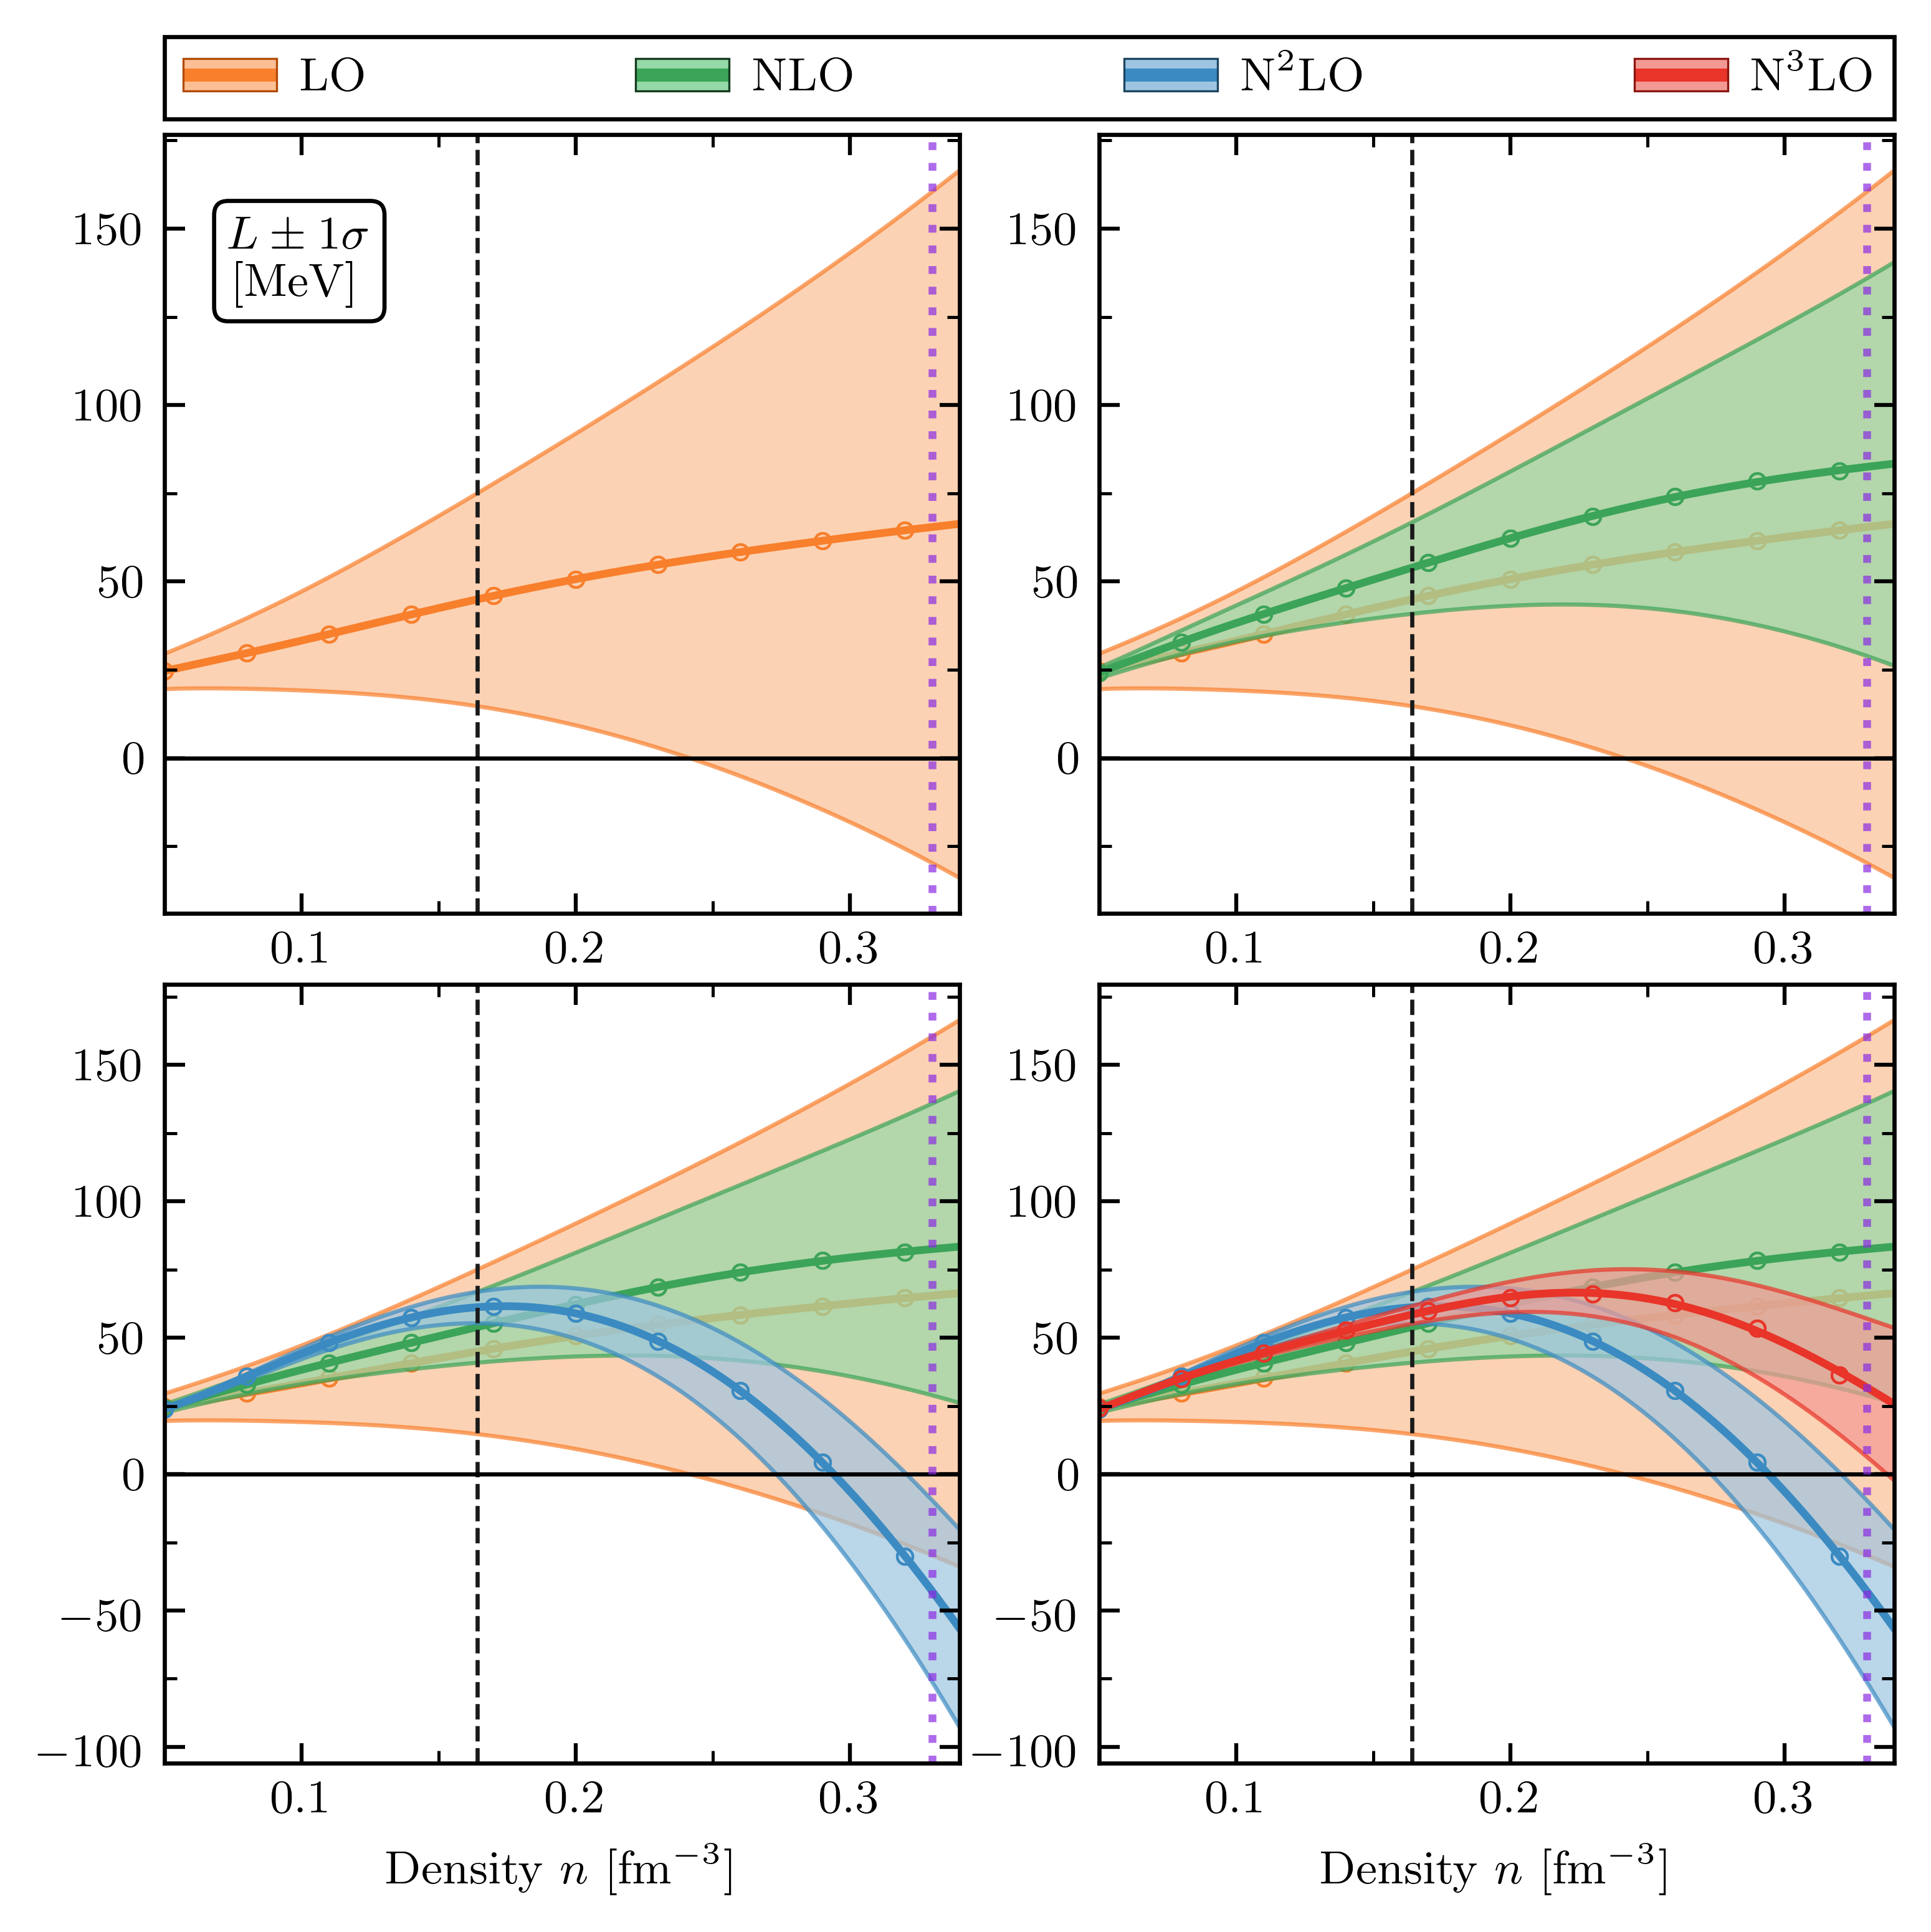

In [49]:
slopes = []
slope_stds = []
slope_fits = []

for i, n in enumerate(chiral.orders):
    slope = compute_slope(
        obs_sym_energy.density_interp,
        obs_sym_energy.kf_interp,
        dS2=obs_sym_energy.get_pred(order=n, deriv=1),
        wrt_kf=False
    )
    slope_cov = compute_slope_cov(
        obs_sym_energy.density_interp,
        obs_sym_energy.kf_interp,
        dS2_cov=obs_sym_energy.get_cov(order=n, deriv1=1, deriv2=1),
        wrt_kf=False
    )
    slope_std = np.sqrt(np.diag(slope_cov))

#     slope_alt_diff = compute_slope(
#         obs_sym_energy.density,
#         obs_sym_energy.kf,
#         dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=True)
#     )
#     slope_alt_diff = compute_slope(
#         obs_sym_energy.density,
#         obs_sym_energy.kf,
#         dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=False),
#         wrt_kf=False
#     )
    slope_alt_diff = compute_slope(
        obs_sym_energy.density,
        obs_sym_energy.kf,
        dS2=obs_sym_energy.poly_interp(order=n, deriv=1, wrt_kf=False),
        wrt_kf=False
    )
    
    slopes.append(slope)
    slope_stds.append(slope_std)
    slope_fits.append(slope_alt_diff)

slopes = np.array(slopes).T
slope_stds = np.array(slope_stds).T
slope_fits = np.array(slope_fits).T
    
fig, axes = plot_obs_panels(
    density_all, y=slopes, dy=slope_stds, orders=chiral.orders,
    density_data=chiral.density[::3], y_data=slope_fits[::3],
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

# axes[0, 0].set_ylim(-1000-1e-3, 1000)
# axes[1, 0].set_ylim(-1000, 1000-1e-3)
for ax in axes.reshape(-1):
   # ax.set_xlim(0.05, 3.2)
   # ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)
label = r"""$L \pm 1\sigma$
[MeV]"""
# for ax in axes.ravel():
#     ax.yaxis.set_major_locator(MultipleLocator(25))
axes[0, 0].text(
    0.08, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)

#fig.savefig(join(fig_path, f'slope_panels_Lambda-{Lambda}'))
plt.show()

__Note__: The break within the symmetry energy container due to the NaN values is very evident here. We need to determine what to do in those regions---they're obviously outside of our region of care wrt chiral EFT's validity--> set them to positive values?

<!-- $$ 
K(n) = 9 \, n^2 \frac{d}{dn} \frac{E}{A} = 9 \, n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = 9 \, n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = 3 \, n \, k_f \frac{d}{dk_f}  \frac{E}{A}
$$ -->

\begin{align}
    K(n) = 9 n^2 \frac{d^2}{dn^2} \frac{E}{A} = 9 n^2 \left[\frac{d^2k_f}{dn^2} \left(\frac{d}{dk_f} \frac{E}{A}\right) + \left(\frac{dk_f}{dn}\right)^2 \frac{d^2}{dk_f^2} \frac{E}{A} \right]
\end{align}

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


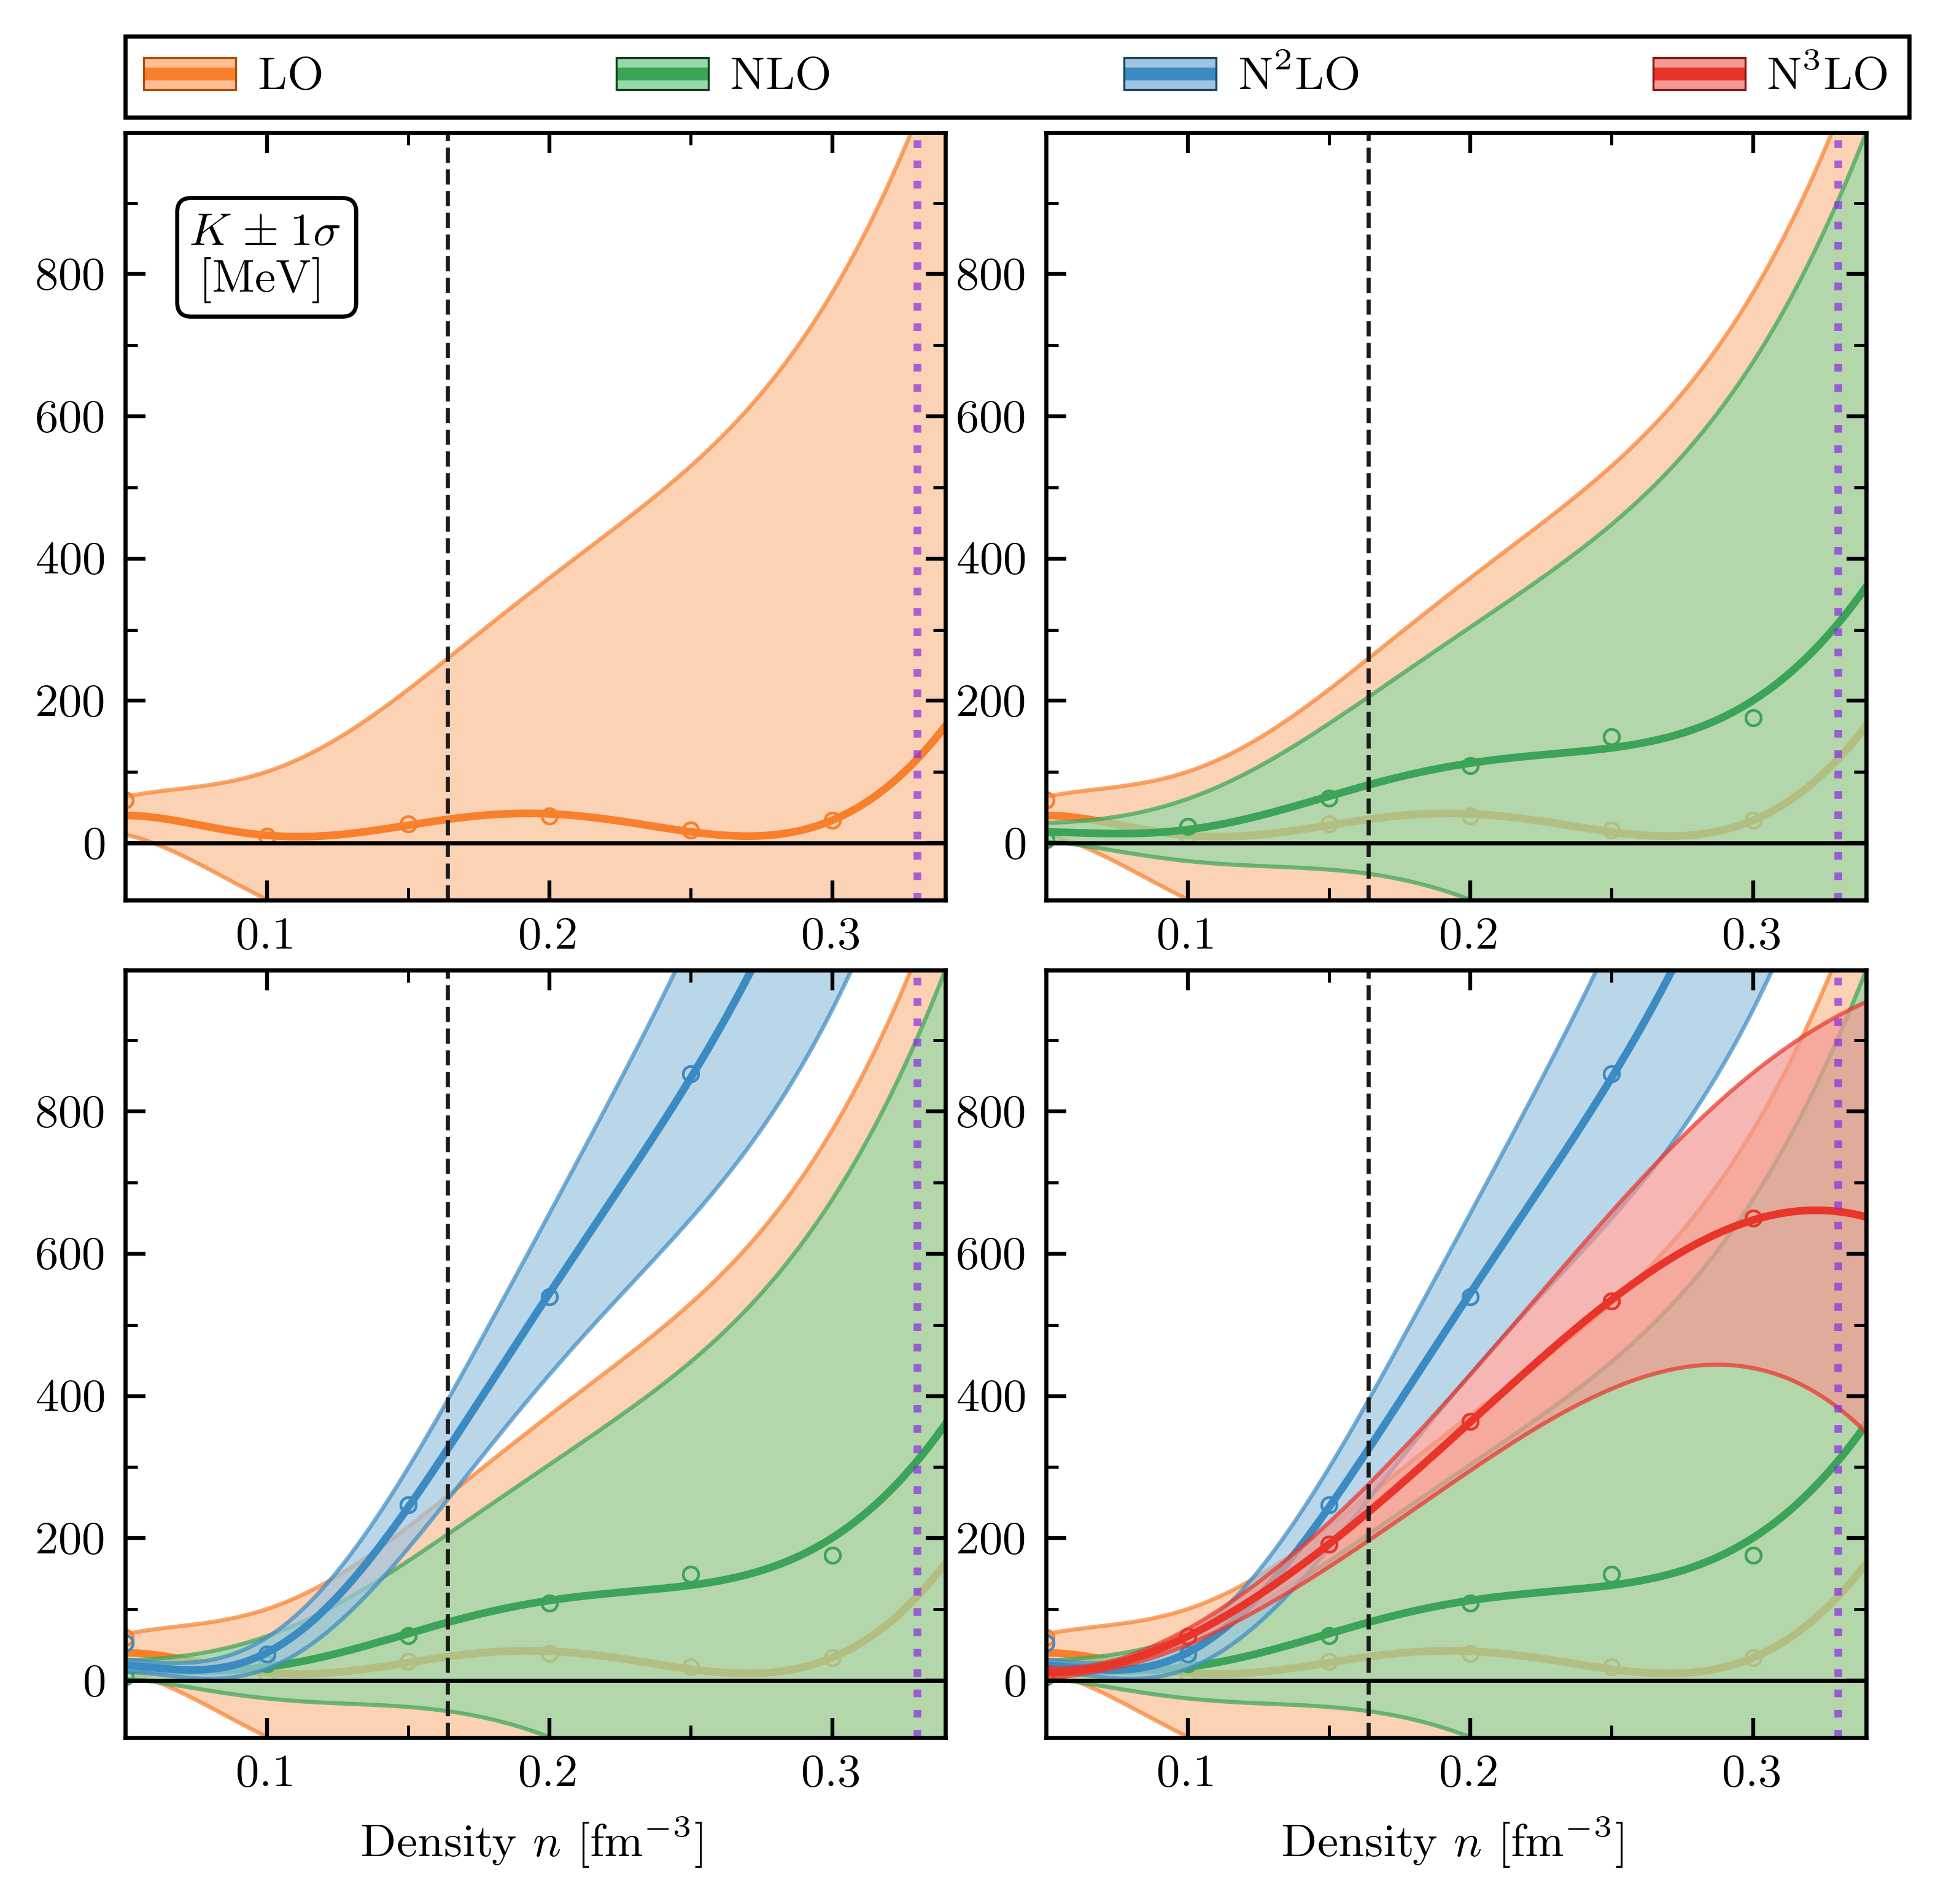

In [50]:
K_incomps = []
K_incomp_stds = []
K_incomp_fits = []

for i, n in enumerate(chiral.orders):
    K_incomp = compute_compressibility(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        d2E=obs_nuclear.get_pred(order=n, deriv=2),
        dE=obs_nuclear.get_pred(order=n, deriv=1),
    )
    K_incomp_cov = compute_compressibility_cov(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        d2E_cov=obs_nuclear.get_cov(order=n, deriv1=2, deriv2=2),
        dE_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1),
        dE_d2E_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=2),
    )
    K_incomp_std = np.sqrt(np.diag(K_incomp_cov))

    # Derivative wrt kf and n differ!
#     K_incomp_alt_diff = compute_compressibility(
#         obs_neutron.density,
#         obs_neutron.kf,
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=True),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True),
#     )
#     K_incomp_alt_diff = compute_compressibility(
#         obs_neutron.density,
#         obs_neutron.kf,
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=False),
#         wrt_kf=False
#     )
    K_incomp_alt_diff = compute_compressibility(
        obs_nuclear.density,
        obs_nuclear.kf,
        d2E=obs_nuclear.poly_interp(order=n, deriv=2, wrt_kf=False),
#         d2E=obs_nuclear.spline(obs_nuclear.density, order=n, deriv=2),
        wrt_kf=False
    )
    
    K_incomps.append(K_incomp)
    K_incomp_stds.append(K_incomp_std)
    K_incomp_fits.append(K_incomp_alt_diff)

    
K_incomps = np.array(K_incomps).T
K_incomp_stds = np.array(K_incomp_stds).T
K_incomp_fits = np.array(K_incomp_fits).T
    
fig, axes = plot_obs_panels(
    density_all, y=K_incomps, dy=K_incomp_stds, orders=chiral.orders,
    density_data=chiral.density[::5], y_data=K_incomp_fits[::5],
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(-80, 999)
axes[1, 0].set_ylim(-80, 999)
axes[0, 1].set_ylim(-80, 999)
axes[1, 1].set_ylim(-80, 999)
# axes[0, 0].set_ylim(-1000-1e-3, 1000)
# axes[1, 0].set_ylim(-1000, 1000-1e-3)
for ax in axes.reshape(-1):
#     ax.set_xlim(0.05, 3.2)
#     ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)
label = r"""$K \pm 1\sigma$
[MeV]"""
axes[0, 0].text(
    0.08, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
#fig.savefig(join(fig_path, f'incomp_sym_panels_Lambda-{Lambda}'))
plt.show()
    
# axes[0,0].set_ylabel('Compressibility $K$')
# axes[1,0].set_ylabel('Compressibility $K$')
# axes[0,0].set_xlabel('')
# axes[0,1].set_xlabel('');

## Calculating $c_{s}^{2}$ for SNM (or, how to do it completely wrong)

\begin{align}
c_S^2 & = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n} \left[ \frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{\partial P}{\partial n} \left[ \frac{E}{A} + m + n \, \frac{\partial }{\partial n} \frac{E}{A} \right]^{-1} \\
\frac{\partial P}{\partial n} & = 2n \frac{d}{dn} \frac{E}{A} + n^2 \frac{d^2}{dn^2} \frac{E}{A}
\end{align}

Here, the energy density $\varepsilon = n \left( \frac{E}{A} + m \right)$ includes the rest-mass contribution, so $\frac{E}{A}$ above does not.

We could attempt to just use 

$$
c_{s}^{2} = \frac{n}{\mu} \frac{\partial \mu}{\partial n},
$$

but we have to be aware of the rest mass there.

In [51]:
# set up the speed of sound
dpdn_one = np.zeros([len(density_all), 4])
dpdn_two = np.zeros([len(density_all), 4])
dE = np.zeros([len(density_all), 4])
dE_cov = []
dE_std = []

depsdn = mu_s   # includes the rest mass
for i, n in enumerate(chiral.orders):
    dE[:,i] = chiral.obs_nuclear.get_pred(order=n, deriv=1)
    dE_cov.append(chiral.obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1))

# cut the cov matrix to stds
for i,n in enumerate(chiral.orders):
    dE_std.append(np.sqrt(np.diag(dE_cov[i])))

# convert to array to reshape
dE_stds = np.asarray(dE_std).T

for i in range(4):
    dpdn_one[:,i] = 2 * (k_F * dE[:,i])/3.0
    
# put it together
cs2 = (dpdn_one + K_incomps/9.0) / depsdn
cs2_stds = (dE_stds + K_incomp_stds/9.0) / mu_s_stds # definitely not correct; fix this

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


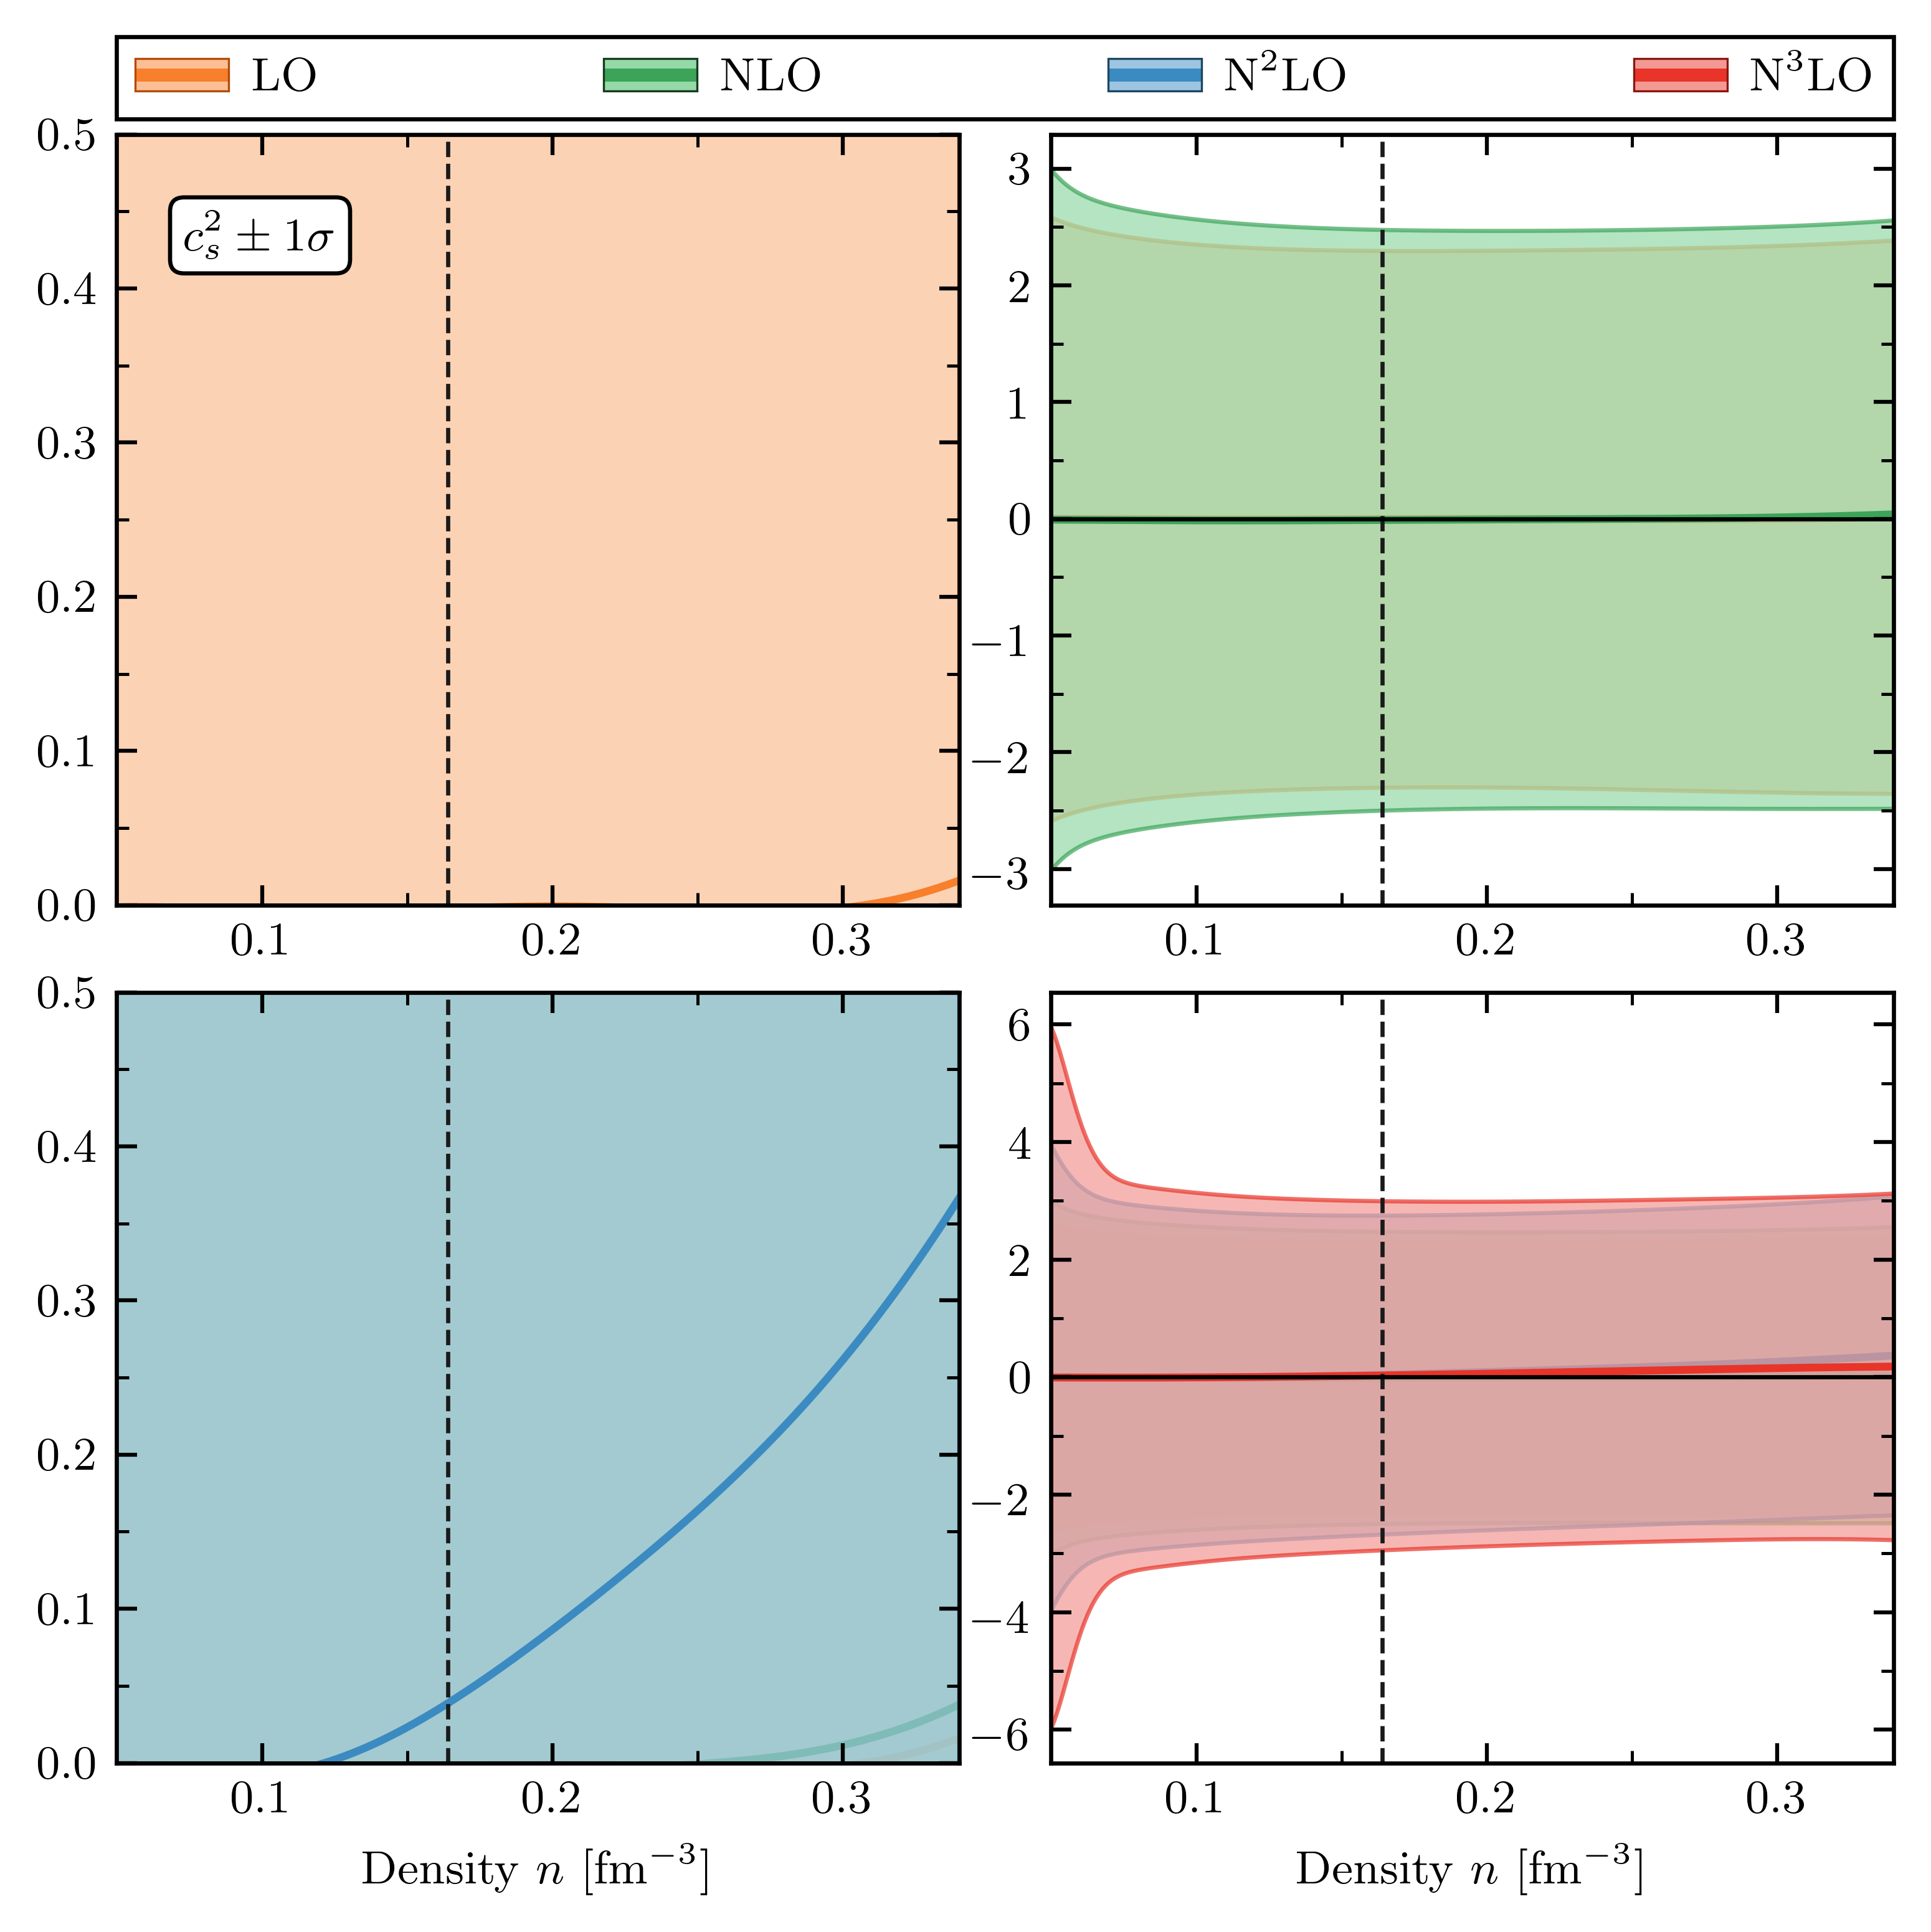

In [52]:
# plot the adiabatic speed of sound
fig, axes = plot_obs_panels(
    density_all, y=cs2, dy=cs2_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(0,0.5)
axes[1, 0].set_ylim(0,0.5)
axes[0,1].set_xlim(0.05,0.34)
axes[0,0].set_xlim(0.05,0.34)
axes[1,0].set_xlim(0.05,0.34)
label = r"""$c_{s}^{2} \pm 1\sigma$"""
axes[0, 0].text(
    0.08, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

## Sampling $c_{s}^{2}$ (or, how to do it better)

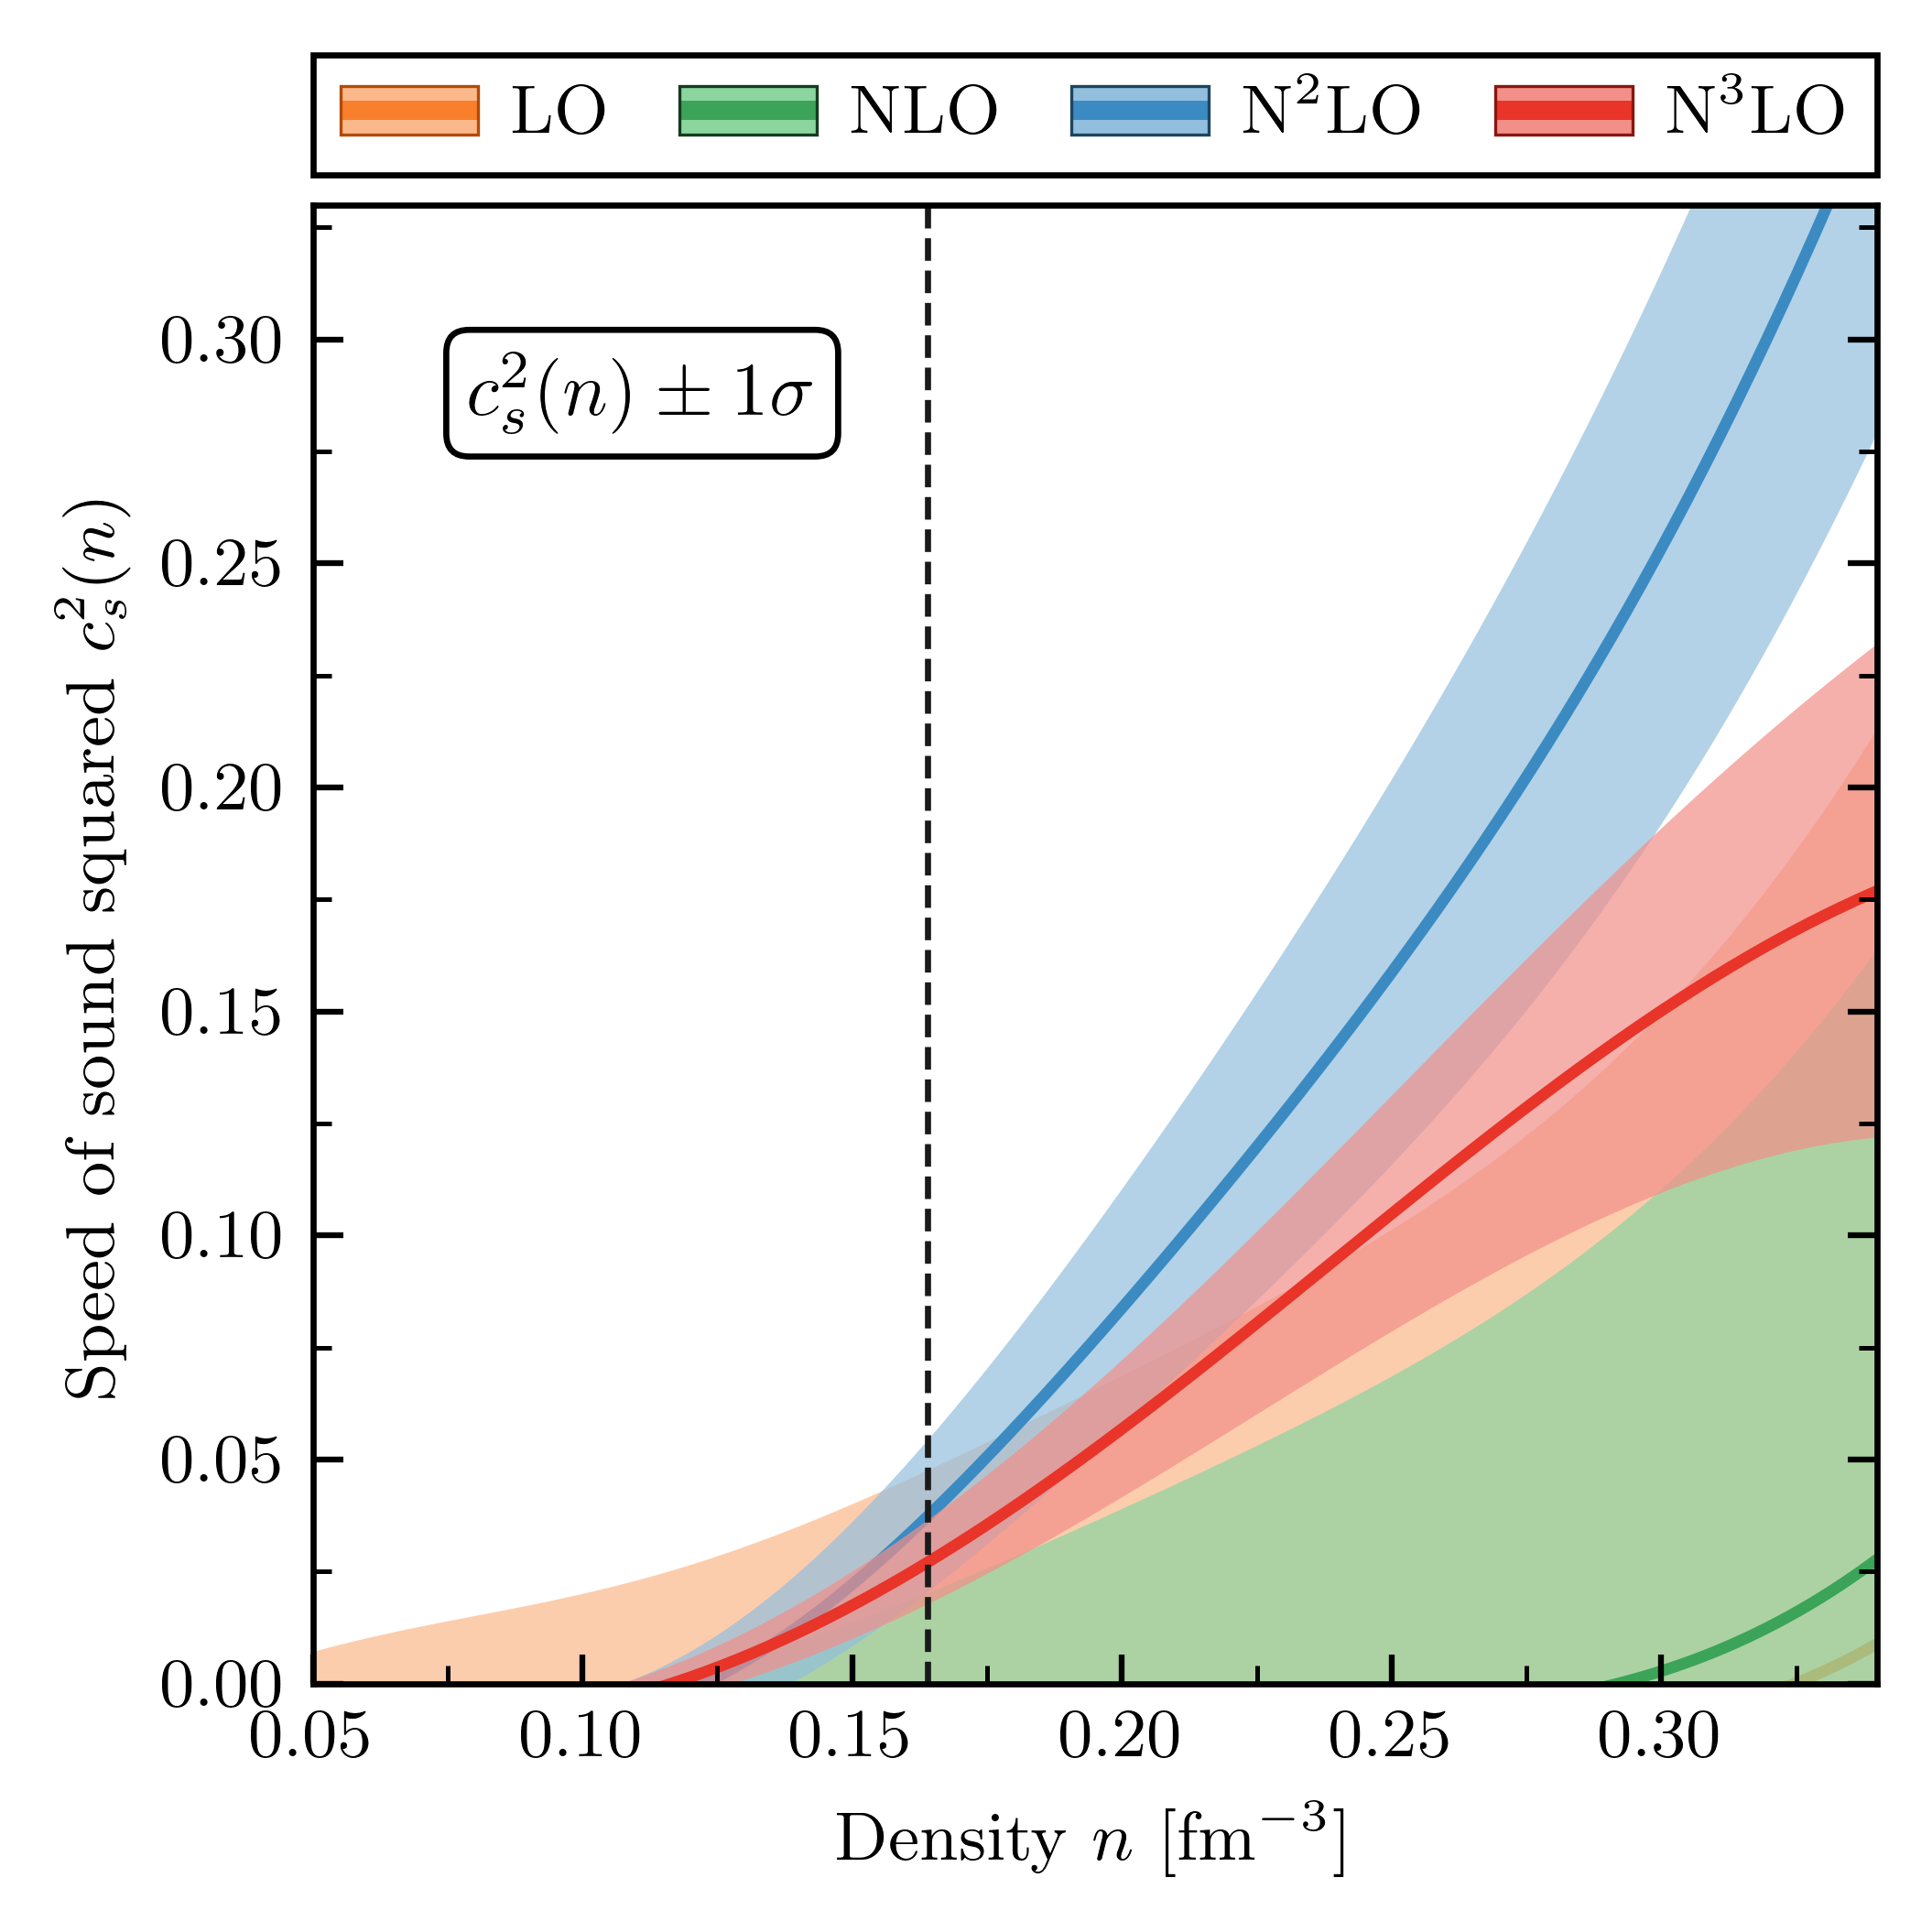

In [57]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter.matter import mass_neutron, mass_proton
mass_nucleon = (mass_neutron + mass_proton)/2.0
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

speed_of_sounds = []
speed_of_sound_stds = []
for i, n in enumerate(chiral.orders):
    E_per_A_samples_n = obs_nuclear.draw_sample(order=n, num_samp=500)
    speed_of_sound_samples = compute_speed_of_sound(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        E=E_per_A_samples_n[0].T,
        dE=E_per_A_samples_n[1].T,
        d2E=E_per_A_samples_n[2].T,
        mass=mass_nucleon
    )
    speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    speed_of_sounds.append(speed_of_sound_mean)
    speed_of_sound_stds.append(speed_of_sound_std)
    
    plot_obs_vs_density(
        density_all,
        speed_of_sound_mean,
        speed_of_sound_std,
        ax=ax,
        color_68=light_colors[i],
        c=colors[i],
        edgecolor=None,
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
        fillstyle='none',
        markeredgewidth=0.5,
    )
    
speed_of_sounds = np.array(speed_of_sounds).T
speed_of_sound_stds = np.array(speed_of_sound_stds).T
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylim(0.0, 0.33)
ax.set_xlim(0.05,0.34)
ax.tick_params(right=True, which='both')
label = r"""$c_{s}^{2}(n) \pm 1\sigma$"""
ax.text(
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.set_ylabel(r'Speed of sound squared $c_{s}^{2}(n)$')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
#fig.savefig('cs2_n_2n0.pdf')
plt.show()

# save the data to an npz file to be used later for BMM
if density_all[-1] <= 0.34:
    np.savez('data/eos_data/speedofsoundchiral.npz', density=chiral.density_all, mean=speed_of_sounds, std=speed_of_sound_stds)
    npzfile_cs2 = np.load('speedofsoundchiral.npz')
    npzfile_cs2.files
else:
    print('Not saved.')

In [174]:
print(npzfile_cs2['density'].shape, npzfile_cs2['mean'].shape, npzfile_cs2['std'].shape)

(100,) (100, 4) (100, 4)


In [135]:
num_sats

101

In [72]:
np.random.seed(1)

K_sat_samples = {}

for i, n in enumerate(orders):
    dE_and_d2E_s_sats, dE_and_d2E_s_sats_cov = obs_nuclear.predict(Kf_s_sats, order=n, derivs=[1, 2])
    dE_s_sats = dE_and_d2E_s_sats[:num_sats]
    d2E_s_sats = dE_and_d2E_s_sats[num_sats:]

    dE_s_sats_cov = dE_and_d2E_s_sats_cov[:num_sats, :num_sats]
    d2E_s_sats_cov = dE_and_d2E_s_sats_cov[num_sats:, num_sats:]
    dE_d2E_s_sats_cov = dE_and_d2E_s_sats_cov[:num_sats, num_sats:]
    # d2E_n_sats, d2E_n_sats_cov = obs_neutron.predict(D_sats, order=n, deriv=2)

    K_incomp_sats = compute_compressibility(
        d_sats,
        kf_s_sats,
        d2E=d2E_s_sats,
        dE=dE_s_sats,
    )
    K_incomp_sats_cov = compute_compressibility_cov(
        d_sats,
        kf_s_sats,
        d2E_cov=d2E_s_sats_cov,
        dE_cov=dE_s_sats_cov,
        dE_d2E_cov=dE_d2E_s_sats_cov,
    )
    K_incomp_sats_std = np.sqrt(np.diag(K_incomp_sats_cov))

    K_incomp_sats_sampled = stats.norm(K_incomp_sats, K_incomp_sats_std).rvs((1000, num_sats))
    K_sat_samples[n] = K_incomp_sats_sampled.ravel()

In [73]:
K_sat_samples

{0: array([ 512.09510163, -105.42233869,  -87.18619612, ...,  138.84933261,
        -257.82314437,  230.36424093]),
 2: array([ 220.635707  ,   38.72146372,  160.48165602, ...,  -37.33559665,
          30.4365215 , -131.79962504]),
 3: array([431.66512389, 403.56474377, 439.49200757, ..., 111.56633821,
        542.87457685, 350.81825367]),
 4: array([324.41867288, 182.92769799, 236.68315863, ..., 160.20709915,
        205.21525172, 186.63055428])}

In [74]:
K_sat_df = pd.DataFrame.from_dict(K_sat_samples)
K_sat_df.columns = order_labels
K_sat_df = pd.melt(K_sat_df, var_name='Order', value_name=r'$K$ [MeV]')

In [75]:
K_sat_df

Order   $K$ [MeV]
0              LO  512.095102
1              LO -105.422339
2              LO  -87.186196
3              LO -199.754405
4              LO  271.175831
...           ...         ...
403995  N$^{3}$LO  175.539568
403996  N$^{3}$LO  335.888660
403997  N$^{3}$LO  160.207099
403998  N$^{3}$LO  205.215252
403999  N$^{3}$LO  186.630554

[404000 rows x 2 columns]

In [76]:
K_sat_df.to_csv(f'K_sat_data_Lambda-{Lambda}.csv', index=False)

In [77]:
import seaborn as sns

In [78]:
K_sat_df['Order'].unique()

array(['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO'], dtype=object)

In [79]:
K_sat_means = {}
K_sat_stds = {}
for i, n in enumerate(orders):
    K_sat_means[n] = K_sat_df.loc[K_sat_df['Order'] == order_labels[i], r'$K$ [MeV]'].mean()
    K_sat_stds[n] = K_sat_df.loc[K_sat_df['Order'] == order_labels[i], r'$K$ [MeV]'].std()

In [80]:
K_sat_means

{0: 37.38977808834215,
 2: 88.54232654016356,
 3: 365.2888800674089,
 4: 259.56668051235647}

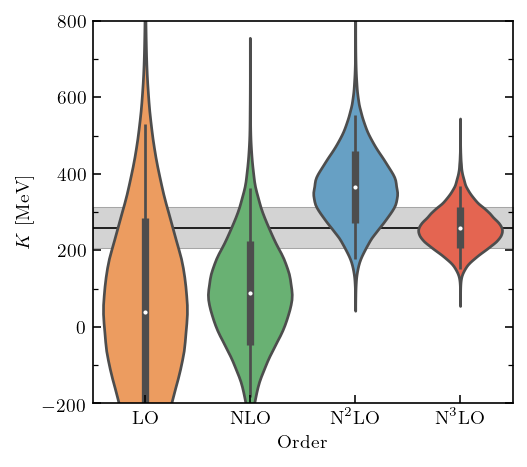

In [81]:
# (B) Figure 14 and SM 9

fig, ax = plt.subplots(figsize=(3.4, 3))
sns.violinplot(
    y='$K$ [MeV]', x='Order', data=K_sat_df, orient='v',
    palette=colors, saturation=0.8,
    scale='width', inner=None, cut=0, ax=ax, edgecolor='w', linewidth=1.3
)

my_gray = '0.3'
for col in ax.collections:
    col.set_edgecolor(my_gray)

for i, n in enumerate(orders):
    ax.plot(
        [i, i], [K_sat_means[n] - 2*K_sat_stds[n], K_sat_means[n] + 2*K_sat_stds[n]],
        c=my_gray, lw=1.3, solid_capstyle='butt', zorder=1
    )
    ax.plot(
        [i, i], [K_sat_means[n] - K_sat_stds[n], K_sat_means[n] + K_sat_stds[n]],
        c=my_gray, lw=3.5, solid_capstyle='butt', zorder=1
    )
    ax.plot([i], [K_sat_means[n]], ls='', marker='.', c='w', markersize=2, zorder=1)

ax.set_xlim(-0.5, 3.5)
ax.axhline(K_sat_means[4], 0, 1, c='k', zorder=-1, lw=0.8)
ax.fill_between(
    ax.get_xlim(),
    [K_sat_means[4] + K_sat_stds[4]]*2,
    [K_sat_means[4] - K_sat_stds[4]]*2,
    facecolor='lightgrey', edgecolor='0.65', lw=0.5, zorder=-3
)

# ax.yaxis.set_major_locator(MultipleLocator(400))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, which='both')
ax.set_ylim(-200, 800)

#fig.savefig(join(fig_path, f'K_sat_marginalized_Lambda-{Lambda}'))
plt.show()

In [82]:
K_incomp_sats

array([314.01546613, 236.59885633, 239.39323326, 221.35190676,
       287.2016472 , 182.32344539, 318.30866152, 231.62583583,
       268.20529059, 248.77938246, 308.2480495 , 189.79505608,
       246.31066783, 244.23275639, 296.632351  , 220.47123343,
       251.38685342, 227.76553776, 258.6982272 , 277.33997567,
       220.44743735, 297.01856589, 288.46960259, 274.55095014,
       288.44384273, 234.20019881, 253.06943023, 225.85620813,
       248.15292543, 275.51766184, 233.93623986, 243.8052397 ,
       234.08556473, 228.84418835, 234.61568829, 256.82375788,
       219.90200046, 265.29011889, 315.27816842, 282.88746986,
       250.72848283, 227.44306948, 232.09201311, 316.4416794 ,
       258.99208497, 235.75689261, 263.79460967, 331.02258385,
       261.36650777, 278.53598494, 267.55461931, 245.30435109,
       219.07903265, 245.40236513, 250.15016579, 277.4723602 ,
       286.27640221, 289.50461062, 267.05199928, 287.89302184,
       231.8517448 , 300.83645001, 274.91294441, 247.13

In [83]:

K_incomp_mean_marg = np.mean(K_incomp_sats_sampled)
K_incomp_std_marg = np.std(K_incomp_sats_sampled)

In [84]:
print(f'K = {K_incomp_mean_marg} +/- {K_incomp_std_marg}')

K = 259.56668051235647 +/- 53.9445671325057


In [85]:
K_incomp_mean_marg

259.56668051235647

In [86]:
K_incomp_std_marg

53.9445671325057

In [87]:
K_incomp_stds.shape

(59, 4)

In [88]:
density_all.shape

(59,)

In [89]:
density_all

array([0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
       0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
       0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225,
       0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 ,
       0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315,
       0.32 , 0.325, 0.33 , 0.335, 0.34 ])

In [90]:
(density_all - 0.16)

array([-1.10000000e-01, -1.05000000e-01, -1.00000000e-01, -9.50000000e-02,
       -9.00000000e-02, -8.50000000e-02, -8.00000000e-02, -7.50000000e-02,
       -7.00000000e-02, -6.50000000e-02, -6.00000000e-02, -5.50000000e-02,
       -5.00000000e-02, -4.50000000e-02, -4.00000000e-02, -3.50000000e-02,
       -3.00000000e-02, -2.50000000e-02, -2.00000000e-02, -1.50000000e-02,
       -1.00000000e-02, -5.00000000e-03, -5.55111512e-17,  5.00000000e-03,
        1.00000000e-02,  1.50000000e-02,  2.00000000e-02,  2.50000000e-02,
        3.00000000e-02,  3.50000000e-02,  4.00000000e-02,  4.50000000e-02,
        5.00000000e-02,  5.50000000e-02,  6.00000000e-02,  6.50000000e-02,
        7.00000000e-02,  7.50000000e-02,  8.00000000e-02,  8.50000000e-02,
        9.00000000e-02,  9.50000000e-02,  1.00000000e-01,  1.05000000e-01,
        1.10000000e-01,  1.15000000e-01,  1.20000000e-01,  1.25000000e-01,
        1.30000000e-01,  1.35000000e-01,  1.40000000e-01,  1.45000000e-01,
        1.50000000e-01,  

In [91]:
# def compute_Esym_L(kf, S2_dS2, S2_dS2_cov):
#     to_Esym_L_mat = np.array([
#         [1, 0],
#         [0, kf]
#     ])
#     S2_L = to_Esym_L_mat @ S2_dS2
#     S2_L_cov = to_Esym_L_mat @ S2_dS2_cov @ to_Esym_L_mat.T
#     return S2_L, S2_L_cov

def compute_Esym_L(n, S2_dS2, S2_dS2_cov):
    to_Esym_L_mat = np.array([
        [1, 0],
        [0, 3*n]
    ])
    S2_L = to_Esym_L_mat @ S2_dS2
    S2_L_cov = to_Esym_L_mat @ S2_dS2_cov @ to_Esym_L_mat.T
    return S2_L, S2_L_cov

In [92]:
density_emp_sat = np.array([0.164])
Density_emp_sat = density_emp_sat[:, None]
# Kf_n_sat = fermi_momentum(density_sat, 2)[:, None]
# Kf_s_sat = fermi_momentum(density_sat, 4)[:, None]
# Kf_d_sat = (Kf_n_sat + Kf_s_sat) / 2.

Esym_dEsym_mean_emp, Esym_dEsym_cov_emp = obs_sym_energy.predict(Density_emp_sat, order=4, derivs=[0, 1])
Esym_L_mean_emp, Esym_L_cov_emp = compute_Esym_L(Density_emp_sat[0, 0], Esym_dEsym_mean_emp, Esym_dEsym_cov_emp)

In [93]:

# K_n_sats = fermi_momentum(d_sats, 2)[:, None]
# K_s_sats = fermi_momentum(d_sats, 4)[:, None]
# K_d_sats = (K_n_sats + K_s_sats) / 2.
Esym_dEsym_means, Esym_dEsym_cov = obs_sym_energy.predict(D_sats, order=4, derivs=[0, 1])

Esym_L_samples = []
for n_s in range(num_sats):
    # Get S2(kf_i) and dS2(kf_i). The vector and matrices are blocks for each derivative type
    Esym_dEsym_mean_n = Esym_dEsym_means[[n_s, n_s+num_sats]]
    Esym_dEsym_cov_n = Esym_dEsym_cov[[n_s, n_s+num_sats]][:, [n_s, n_s+num_sats]]
    Esym_L_mean_n, Esym_L_cov_n = compute_Esym_L(D_sats[n_s,0], Esym_dEsym_mean_n, Esym_dEsym_cov_n)
    Esym_L_samples.append(
        stats.multivariate_normal(mean=Esym_L_mean_n, cov=Esym_L_cov_n, allow_singular=True).rvs(num_sats)
    )
Esym_L_samples = np.asarray(Esym_L_samples).reshape(-1, 2).T

# Create a mean and covariance matrix from all of the samples
Esym_L_samples_mean = np.mean(Esym_L_samples, axis=1)
Esym_L_samples_cov = np.cov(Esym_L_samples)

Show the $S_v$--$L$ plot *without* making any Gaussian approximation. Looks like a Gaussian!

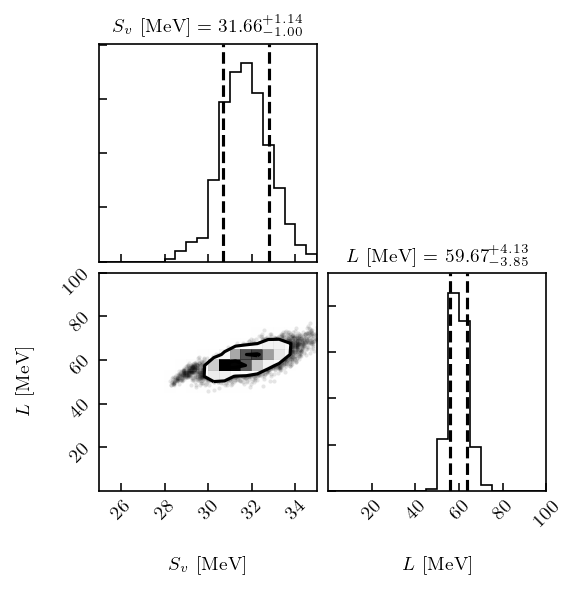

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=False)
fig = corner.corner(
    Esym_L_samples.T, range=[(25, 35), (0, 100)],
    labels=[r'$S_v$ [MeV]', r'$L$ [MeV]'], fig=fig,
    quantiles=(0.16, 0.84), levels=(1-np.exp(-0.5), 1-np.exp(-0.5*2**2)),
    show_titles=True, title_kwargs={"fontsize": 9}
)

In [95]:
print('mean:\n', Esym_L_samples_mean)
print('cov:\n', Esym_L_samples_cov)

mean:
 [31.69810539 59.830485  ]
cov:
 [[ 1.23651375  3.27499281]
 [ 3.27499281 16.95157735]]


In [96]:
print(f'S_v = {Esym_L_samples_mean[0]:0.1f} +/- {np.sqrt(Esym_L_samples_cov[0, 0]):0.1f}')
print(f'L = {Esym_L_samples_mean[1]:0.1f} +/- {np.sqrt(Esym_L_samples_cov[1, 1]):0.1f}')

S_v = 31.7 +/- 1.1
L = 59.8 +/- 4.1


In [97]:
Esym_L_mean_emp

array([30.93438443, 58.47545891])

In [98]:
Esym_L_cov_emp

array([[ 0.13982695,  1.09064825],
       [ 1.09064825, 10.61924441]])

In [99]:
np.linalg.eigh(Esym_L_cov_emp)

(array([ 0.02752099, 10.73155037]),
 array([[-0.9947402 ,  0.10243014],
        [ 0.10243014,  0.9947402 ]]))

In [100]:
Esym_L_samples_mean - Esym_L_mean_emp

array([0.76372096, 1.35502609])

Ellipse(xy=(0, 0), width=2.7532090628200723, height=0.6479505045953893, angle=0)


(0.0, 100.0)

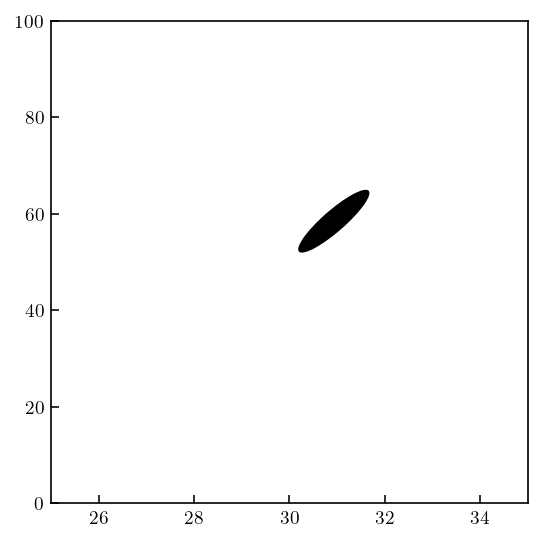

In [101]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
pat = confidence_ellipse_mean_cov(Esym_L_mean_emp, Esym_L_cov_emp, ax=ax, n_std=2, facecolor='k')
print(pat)
ax.set_xlim(25, 35)
ax.set_ylim(0, 100)

## Speed of sound in neutron matter  <a id="sound_speed"></a>

\begin{align}
c_S^2 & = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n} \left[ \frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{\partial P}{\partial n} \left[ \frac{E}{N} + m + n \, \frac{\partial }{\partial n} \frac{E}{N} \right]^{-1} \\
\frac{\partial P}{\partial n} & = 2n \frac{d}{dn} \frac{E}{N} + n^2 \frac{d^2}{dn^2} \frac{E}{N} \\
& = \frac{2P}{n} + \frac{K}{9}
\end{align}
Here, the energy density $\varepsilon = n \left( \frac{E}{N} + m \right)$ includes the rest-mass contribution.

In [105]:
from nuclear_matter.matter import mass_neutron

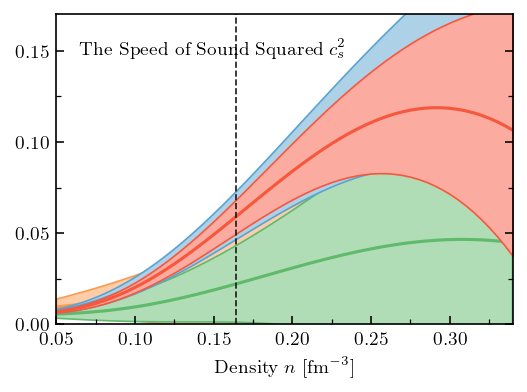

In [231]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 2.5))

speed_of_sounds = []
speed_of_sound_stds = []
for i, n in enumerate(chiral.orders):
    E_per_N_samples_n = obs_neutron.draw_sample(order=n, num_samp=500)
    speed_of_sound_samples = compute_speed_of_sound(
        obs_neutron.density_interp,
        obs_neutron.kf_interp,
        E=E_per_N_samples_n[0].T,
        dE=E_per_N_samples_n[1].T,
        d2E=E_per_N_samples_n[2].T,
        mass=mass_neutron
    )
    speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    speed_of_sounds.append(speed_of_sound_mean)
    speed_of_sound_stds.append(speed_of_sound_std)
    
#     speed_of_sound_alt_diff = compute_speed_of_sound(
#         obs_neutron.density,
#         obs_neutron.kf,
#         E=obs_neutron.finite_difference(order=n, deriv=0, wrt_kf=True),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True),
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=True),
#         mass=mass_neutron
#     )
#     speed_of_sound_alt_diff = compute_speed_of_sound(
#         obs_neutron.density,
#         obs_neutron.kf,
#         E=obs_neutron.finite_difference(order=n, deriv=0, wrt_kf=False),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=False),
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=False),
#         mass=mass_neutron,
#         wrt_kf=False,
#     )
    speed_of_sound_alt_diff = compute_speed_of_sound(
        obs_neutron.density,
        obs_neutron.kf,
        E=obs_neutron.poly_interp(order=n, deriv=0, wrt_kf=False),
        dE=obs_neutron.poly_interp(order=n, deriv=1, wrt_kf=False),
        d2E=obs_neutron.poly_interp(order=n, deriv=2, wrt_kf=False),
        mass=mass_neutron,
        wrt_kf=False,
    )
    
    plot_obs_vs_density(
        density_all,
        speed_of_sound_mean,
        speed_of_sound_std,
        ax=ax,
#         color_68=colors[i],
#         color_95=light_colors[i],
#         c=dark_colors[i],
        color_68=light_colors[i],
        c=colors[i],
        edgecolor=colors[i],
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
#         density_data=obs_neutron.density,
#         y_data=speed_of_sound_alt_diff,
        fillstyle='none',
        markeredgewidth=0.5,
    )
    
    
speed_of_sounds = np.array(speed_of_sounds).T
speed_of_sound_stds = np.array(speed_of_sound_stds).T
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylim(0, 0.17)
ax.tick_params(right=True, which='both')
ax.text(0.05, 0.92, s='The Speed of Sound Squared $c_s^2$', transform=ax.transAxes, ha='left', va='top');
#fig.savefig(join(fig_path, f'speed_of_sound_Lambda-{Lambda}'))
# ax.set_ylabel('Speed of Sound');

Now sample $E/N$ to compute a joint distribution for $\{P, c_s^2\}$.

In [108]:
n_n3lo_samples = 1000
np.random.seed(1)  # Make it reproducible
E_per_N_samples_n3lo = obs_neutron.draw_sample(order=4, num_samp=n_n3lo_samples)
speed_of_sound_samples_n3lo = compute_speed_of_sound(
    obs_neutron.density_interp,
    obs_neutron.kf_interp,
    E=E_per_N_samples_n3lo[0].T,
    dE=E_per_N_samples_n3lo[1].T,
    d2E=E_per_N_samples_n3lo[2].T,
    mass=mass_neutron
)

pressure_samples_n3lo = compute_pressure(
    obs_neutron.density_interp,
    obs_neutron.kf_interp,
    dE=E_per_N_samples_n3lo[1].T
)

Repeat these arrays so they match with the samples just created.

In [109]:
densities_repeated = np.tile(obs_neutron.density_interp[:, None], reps=n_n3lo_samples).T
kf_repeated = np.tile(obs_neutron.kf_interp[:, None], reps=n_n3lo_samples).T
sample_numbers = np.tile(np.arange(n_n3lo_samples)[:, None], reps=len(obs_neutron.density_interp))

In [110]:
densities_repeated.shape

(1000, 59)

Text(0, 0.5, '$c_s^2$')

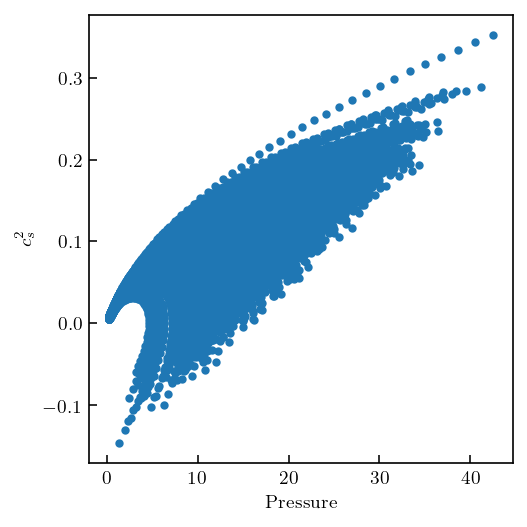

In [112]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax.plot(pressure_samples_n3lo.ravel(), speed_of_sound_samples_n3lo.ravel(), ls='', marker='.')
ax.set_xlabel('Pressure')
ax.set_ylabel('$c_s^2$')
#fig.savefig(join(fig_path, f'speed_of_sound_sq_vs_pressure_n3lo_Lambda-{Lambda}'))

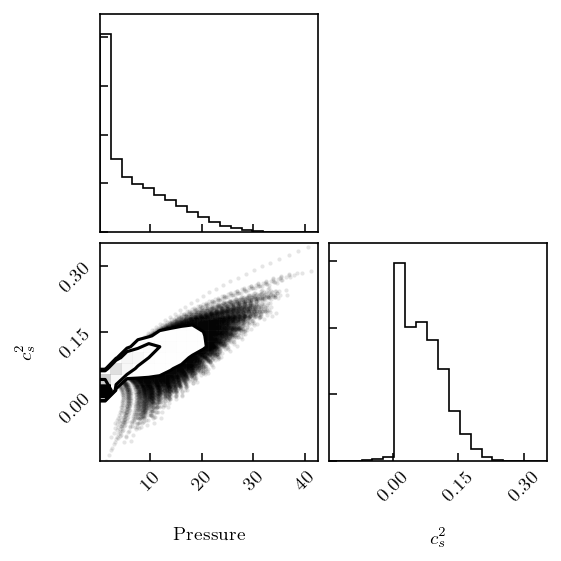

In [113]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=False)
fig = corner.corner(
    np.array([pressure_samples_n3lo.ravel(), speed_of_sound_samples_n3lo.ravel()]).T,
    labels=[r'Pressure', r'$c_s^2$'],
    fig=fig,
)
#fig.savefig(join(fig_path, f'speed_of_sound_sq_vs_pressure_n3lo_v2_Lambda-{Lambda}'))

These should be the same shape. We don't want to mix up axes.

In [114]:
sample_numbers.shape, densities_repeated.shape, kf_repeated.shape,

((1000, 59), (1000, 59), (1000, 59))

In [115]:
pressure_samples_n3lo.shape, speed_of_sound_samples_n3lo.shape

((1000, 59), (1000, 59))

In [116]:
df_p_cs2 = pd.DataFrame(
    np.array([
        sample_numbers.ravel(), densities_repeated.ravel(), kf_repeated.ravel(),
        pressure_samples_n3lo.ravel(), speed_of_sound_samples_n3lo.ravel()]).T,
    columns=['Sample Number', 'Density', 'kf', 'P', 'cs2']
)

In [117]:
df_p_cs2

Sample Number  Density        kf          P       cs2
0                0.0    0.050  1.139717   0.213697  0.007420
1                0.0    0.055  1.176507   0.250487  0.008065
2                0.0    0.060  1.211130   0.290594  0.008806
3                0.0    0.065  1.243879   0.334520  0.009659
4                0.0    0.070  1.274989   0.382841  0.010638
...              ...      ...       ...        ...       ...
58995          999.0    0.320  2.116039  21.095289  0.134428
58996          999.0    0.325  2.127003  21.798654  0.133178
58997          999.0    0.330  2.137855  22.496030  0.131605
58998          999.0    0.335  2.148599  23.185624  0.129700
58999          999.0    0.340  2.159235  23.865590  0.127456

[59000 rows x 5 columns]

Make sure the DataFrame has been set up properly. All curves should be smooth and the spread of the sample should be reasonable.

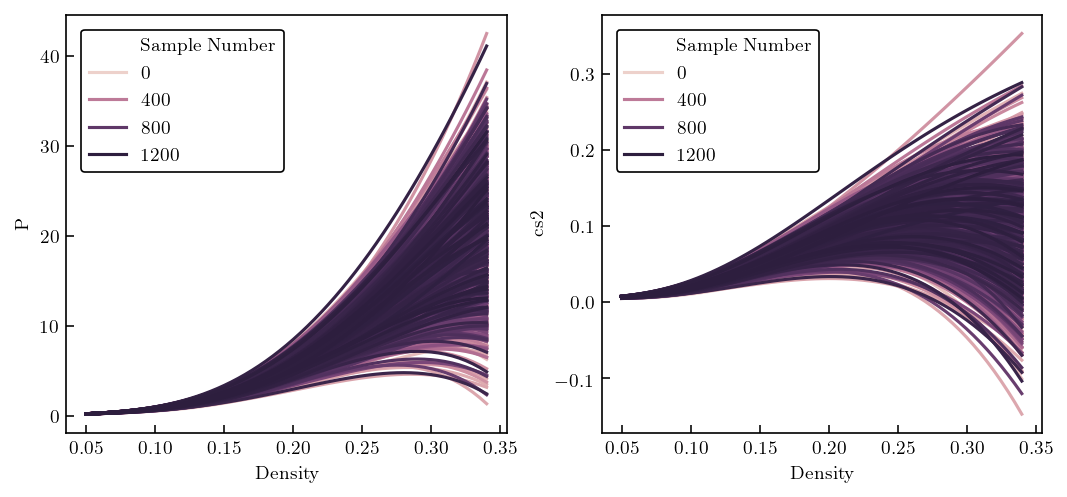

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.2))
sns.lineplot('Density', 'P', hue='Sample Number', data=df_p_cs2, ax=axes[0])
sns.lineplot('Density', 'cs2', hue='Sample Number', data=df_p_cs2, ax=axes[1]);
plt.show()

Now save the dataframe as a `csv` file to be used elsewhere.

In [119]:
df_p_cs2.to_csv('pressure_cs2_samples.csv')

C:\Users\Alexandra\anaconda3\envs\BUQEYE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


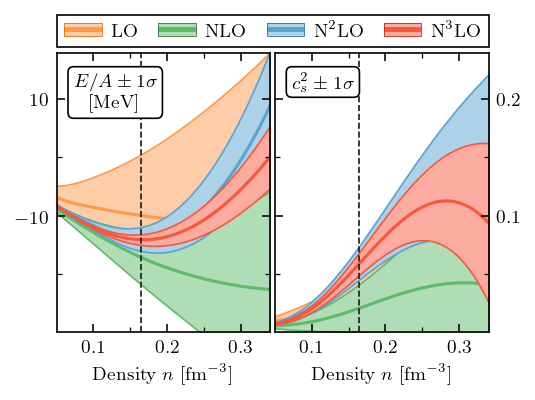

In [121]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(1, 2, sharey=False, sharex=True, figsize=(3.4, 2.5))
    for i, n in enumerate(orders):
        plot_obs_vs_density(
            density_all,
            energies_s[:, i],
            energy_s_stds[:, i],
            ax=axes[0],
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            fillstyle='none',
            markeredgewidth=0.5,
        )

        plot_obs_vs_density(
            density_all,
            speed_of_sounds[:, i],
            speed_of_sound_stds[:, i],
            ax=axes[1],
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            fillstyle='none',
            markeredgewidth=0.5,
        )


    axes[0].set_ylim(-30+1e-5, 18-1e-5)
    axes[1].set_ylim(1e-5, 0.24-1e-5)
    # axes[0].yaxis.set_major_locator(MultipleLocator(10))
#     axes[0].set_yticks([-15, -5, 5, 15])
    axes[0].set_yticks([-10, 10])
    axes[1].set_yticks([0.1, 0.2])
#     axes[1].yaxis.set_major_locator(MultipleLocator(0.05))


    label_es = r"""$E/A \pm 1\sigma$
    [MeV]"""
    label_cs = r"""$c_s^2 \pm 1\sigma$"""
    axes[0].text(
        0.08, 0.93, label_es, transform=axes[0].transAxes, ha='left', va='top',
        multialignment='center', zorder=10,
        bbox=dict(facecolor='w', boxstyle='round')
    )
    axes[1].text(
        0.08, 0.93, label_cs, transform=axes[1].transAxes, ha='left', va='top',
        multialignment='center', zorder=10,
        bbox=dict(facecolor='w', boxstyle='round')
    )
    axes[1].yaxis.tick_right()
    for ax in axes.ravel():
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(left=True, right=True, bottom=True, top=True, which='both')

    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.1/72)
    add_top_order_legend(fig, axes[0], axes[1], order_labels, colors, light_colors, dark_colors)
  #  fig.savefig(join(fig_path, f'energy-obs-s_with_speed_of_sound_Lambda-{Lambda}'))
    plt.show()

In [122]:
sat_n_emp_idx = np.where(np.abs((density_all - 0.16)) < 1e-10)[0][0]
sat_n_ham_idx = np.where(np.abs((density_all - 0.17)) < 1e-10)[0][0]

In [123]:
sat_n_emp_idx

22

In [124]:
print(f'n = {density_all[sat_n_emp_idx]:0.2f}')
print(f'P = {pressures_s[sat_n_emp_idx, -1]} +/- {pressure_s_stds[sat_n_emp_idx, -1]:0.2f}')
print(f'K = {K_incomps[sat_n_emp_idx, -1]} +/- {K_incomp_stds[sat_n_emp_idx, -1]:0.0f}')

n = 0.16
P = -0.19210950344739472 +/- 0.35
K = 223.744113243559 +/- 37


In [125]:
print(f'n = {density_all[sat_n_ham_idx]:0.2f}')
print(f'P = {pressures_s[sat_n_ham_idx, -1]} +/- {pressure_s_stds[sat_n_ham_idx, -1]:0.2f}')
print(f'K = {K_incomps[sat_n_ham_idx, -1]} +/- {K_incomp_stds[sat_n_ham_idx, -1]:0.0f}')

n = 0.17
P = 0.06652214728674623 +/- 0.43
K = 257.2560312361383 +/- 44


In [126]:
print(f'n = {density_all[-1]:0.2f}')
print(f'N2LO cs^2 = {speed_of_sounds[-1, -2]} +/- {speed_of_sound_stds[-1, -2]:0.2f}')
print(f'N3LO cs^2 = {speed_of_sounds[-1, -1]} +/- {speed_of_sound_stds[-1, -1]:0.2f}')

n = 0.34
N2LO cs^2 = 0.13895798041051474 +/- 0.08
N3LO cs^2 = 0.09394398206470375 +/- 0.07


In [128]:
obs_sym_energy.density

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26,
       0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34])

In [129]:
# obs_sym_energy.density[data_slice]

## Composite order-by-order predictions of observables: (B) figures 1 and SM 1 <a id="composite"></a>

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    text_kwargs = dict(
        x=0.1, y=0.92, ha='left', va='top',
        multialignment='center',
        bbox=dict(boxstyle='round', facecolor='w'),
        zorder=10
    )
    
    data_slice = slice(None, None, 5)
    panels_include_trunc = True
    
    make_3x2 = True
    make_2x3 = False

    if make_3x2:
        fig, axes = plt.subplots(3, 2, sharey=False, sharex='col', figsize=(3.4, 6.2), constrained_layout=True)
    elif make_2x3:
        fig, axes = plt.subplots(2, 3, sharey=False, sharex='col', figsize=(7, 6), constrained_layout=True)
    else:
        fig, axes = plt.subplots(2, 2, sharey=False, sharex='col', figsize=(3.4, 4), constrained_layout=True)
        
    if make_3x2:
        ax_EN = axes[0, 0]
        ax_S2 = axes[1, 0]
        ax_P = axes[0, 1]
        ax_L = axes[1, 1]
        ax_EA = axes[2, 0]
        ax_cs = axes[2, 1]
    elif make_2x3:
        ax_EN = axes[0, 0]
        ax_S2 = axes[0, 2]
        ax_P = axes[1, 0]
        ax_L = axes[1, 2]
        ax_EA = axes[0, 1]
        ax_cs = axes[1, 1]
    else:
        ax_EN = axes[0, 0]
        ax_S2 = axes[1, 0]
        ax_P = axes[0, 1]
        ax_L = axes[1, 1]
    
    ms_4x4 = 3


    for i, n in enumerate(orders):
        plot_obs_vs_density(
            density_all,
            obs_neutron.get_pred(order=n, deriv=0),
            obs_neutron.get_std(order=n, deriv=0, include_trunc=panels_include_trunc),
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            ax=ax_EN,
            density_data=obs_neutron.density[data_slice],
            y_data=obs_neutron.finite_difference(order=n, deriv=0)[data_slice],
            markersize=ms_4x4,
        )
    EN_text = r'$E/N$ [MeV]'
    EN_text = R"""$E/N\pm 1\sigma$
    [MeV]"""
    ax_EN.text(s=EN_text, transform=ax_EN.transAxes, **text_kwargs)
    ax_EN.set_ylim(1e-5, 50-1e-5)


    for i, n in enumerate(orders):
        plot_obs_vs_density(
            density_all,
            obs_sym_energy.get_pred(order=n, deriv=0),
            obs_sym_energy.get_std(order=n, deriv=0, include_trunc=panels_include_trunc),
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            ax=ax_S2,
            density_data=obs_sym_energy.density[data_slice],
            y_data=obs_sym_energy.finite_difference(order=n, deriv=0)[data_slice],
            markersize=ms_4x4,
        )
    S2_text = R"""$S_2 \pm 1\sigma$
    [MeV]"""
    ax_S2.text(s=S2_text, transform=ax_S2.transAxes, **text_kwargs)
    ax_S2.set_yticks([25, 35, 45])
    ax_S2.set_ylim(15+1e-5, 55-1e-4)

    for i, n in enumerate(orders):
        pressure_n = compute_pressure(
            obs_neutron.density_interp,
            obs_neutron.kf_interp,
            dE=obs_neutron.get_pred(order=n, deriv=1)
        )
        pressure_n_cov = compute_pressure_cov(
            obs_neutron.density_interp,
            obs_neutron.kf_interp,
            dE_cov=obs_neutron.get_cov(order=n, deriv1=1, deriv2=1, include_trunc=panels_include_trunc)
        )
        pressure_n_std = np.sqrt(np.diag(pressure_n_cov))
        
        pressure_alt_diff_n = compute_pressure(
            obs_neutron.density,
            obs_neutron.kf,
            dE=obs_neutron.poly_interp(order=n, deriv=1, wrt_kf=False),
            wrt_kf=False
        )
        
        plot_obs_vs_density(
            density_all,
            pressure_n,
            pressure_n_std,
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            ax=ax_P,
            markersize=ms_4x4,
            fillstyle='none',
            markeredgewidth=0.5,
        )

    P_text = r'$P$ [MeV\,fm$^{-3}$]'
    P_text = R"""$P\pm 1\sigma$
    [MeV\,fm$^{-3}$]"""
    ax_P.text(s=P_text, transform=ax_P.transAxes, **text_kwargs)
    ax_P.set_ylim(0+1e-5, 25-1e-5)

    for i, n in enumerate(orders):
        slope = compute_slope(
            obs_sym_energy.density_interp,
            obs_sym_energy.kf_interp,
            dS2=obs_sym_energy.get_pred(order=n, deriv=1),
            wrt_kf=False
        )
        slope_cov = compute_slope_cov(
            obs_sym_energy.density_interp,
            obs_sym_energy.kf_interp,
            dS2_cov=obs_sym_energy.get_cov(
                order=n, deriv1=1, deriv2=1, include_trunc=panels_include_trunc),
            wrt_kf=False
        )
        slope_std = np.sqrt(np.diag(slope_cov))
        
        slope_alt_diff = compute_slope(
            obs_sym_energy.density,
            obs_sym_energy.kf,
            dS2=obs_sym_energy.poly_interp(order=n, deriv=1, wrt_kf=False),
            wrt_kf=False,
        )
        
        plot_obs_vs_density(
            density_all,
            slope,
            slope_std,
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            ax=ax_L,
            markersize=ms_4x4,
            fillstyle='none',
            markeredgewidth=0.5,
        )
    L_text = r'$L$ [MeV]'
    L_text = R"""$L\pm 1\sigma$
    [MeV]"""
    ax_L.text(s=L_text, transform=ax_L.transAxes, **text_kwargs)
    ax_L.yaxis.set_major_locator(MultipleLocator(25))
    ax_L.set_ylim(0+1e-5, 100-1e-4)
    
    
    if make_3x2 or make_2x3:
        for i, n in enumerate(orders):
            plot_obs_vs_density(
                density_all,
                obs_nuclear.get_pred(order=n, deriv=0),
                obs_nuclear.get_std(order=n, deriv=0, include_trunc=panels_include_trunc),
                ax=ax_EA,
                color_68=light_colors[i],
                c=colors[i],
                edgecolor=colors[i],
                add_nsat=i==len(orders)-1,
                zorder=i/10,
                markersize=ms_4x4,
                density_data=obs_nuclear.density[data_slice],
                y_data=obs_nuclear.finite_difference(order=n, deriv=0)[data_slice],
            )
            
            E_per_N_samples_n = obs_neutron.draw_sample(
                order=n, num_samp=1007, include_trunc=panels_include_trunc)
            speed_of_sound_samples = compute_speed_of_sound(
                obs_neutron.density_interp,
                obs_neutron.kf_interp,
                E=E_per_N_samples_n[0].T,
                dE=E_per_N_samples_n[1].T,
                d2E=E_per_N_samples_n[2].T,
                mass=mass_neutron
            )
            speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
            speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)

            plot_obs_vs_density(
                density_all,
                speed_of_sound_mean,
                speed_of_sound_std,
                ax=ax_cs,
                color_68=light_colors[i],
                c=colors[i],
                edgecolor=colors[i],
                add_nsat=i==len(orders)-1,
                zorder=i/10,
                fillstyle='none',
                markeredgewidth=0.5,
            )

        ax_EA.set_ylim(-30+1e-5, 18-1e-5)
        ax_cs.set_ylim(1e-5, 0.24-1e-5)
        ax_EA.set_yticks([-10, 10])
        ax_cs.set_yticks([0.1, 0.2])
        
        plot_empirical_saturation(ax_EA, alpha=1)
        
        
        label_es = r"""$E/A \pm 1\sigma$
        [MeV]"""
        label_cs = r"""$c_s^2 \pm 1\sigma$
        [---]"""
        ax_EA.text(
            s=label_es, transform=ax_EA.transAxes, **text_kwargs
        )
        ax_cs.text(
            s=label_cs, transform=ax_cs.transAxes, **text_kwargs
        )

    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i, j]
            if j == 1:
                ax.yaxis.tick_right()
                ax.set_xticks(axes[0, 0].get_xticks()[2:-1])
    #             ax.xaxis.set_major_locator(MaxNLocator(nbins=3, steps=[0.05, 0.1, 0.15, 0.2], prune='lower'))
            if i < axes.shape[0] - 1:
                ax.set_xlabel('')
            ax.tick_params(left=True, bottom=True, right=True, top=True, which='both')
            ax.yaxis.set_minor_locator(AutoMinorLocator(2))
            ax.xaxis.set_major_locator(MultipleLocator(0.1))

    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.1/72)
    add_top_order_legend(fig, axes[0,  0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
  #  fig.savefig(join(fig_path, f'energies_and_related_derivatives_Lambda-{Lambda}_trunc-{panels_include_trunc}'))
    plt.show()

In [131]:
speed_of_sound_stds[-1, -1]*2

0.13690359614649963

In [132]:
speed_of_sounds[-1, -1] + speed_of_sound_stds[-1, -1]*2

0.23084757821120339

In [133]:
speed_of_sounds[-1, -1] - speed_of_sound_stds[-1, -1]*2

-0.04295961408179588

In [134]:
speed_of_sound_stds.shape

(59, 4)

In [135]:
speed_of_sound_stds[-1, -2]*2

0.165041543006704

In [136]:
speed_of_sound_stds[-1, -2]

0.082520771503352

In [137]:
speed_of_sounds[-1, -2]

0.13895798041051474

In [138]:
speed_of_sounds[-1, -2] + speed_of_sound_stds[-1, -1]*2

0.2758615765570144

In [139]:
speed_of_sounds[-1, -2] - speed_of_sound_stds[-1, -1]*2

0.0020543842640151078